# Analysis of predictions on yellow fever simulated reads

**Using the report files saved locally in `data/ncbi/infer_results/yf-ncbi/local-inf`**

Oct 1, 2024

After review previous analysis on Sep 30, 2024.

Ideas to develop:
- use a resolution of one BP for the position analysis
- analyze "mismatch/mutation" threshold level for each position that gives a poor accuracy
- use YF training subset to analyze the mutation/mismatch threshold level for 50-mers and relation to accuracy. use concept of coverage, nbr mutations, ...
- we see 4 clusters in the square plots, analyse the clusters evolutions for positions

# 1. Imports and setup environment

In [40]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [41]:
# Import all required packages
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import time

from datetime import datetime
from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from functools import partial
from IPython.display import display, update_display, Markdown, HTML
from matplotlib.gridspec import GridSpec
from nbdev import show_doc
from pandas import HDFStore
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Any, Generator

# Setup the notebook for development
nb_setup()

from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader, TextFileBaseReader
from metagentools.cnn_virus.data import OriginalLabels
from metagentools.core import ProjectFileSystem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


# 2. Setup paths to files

### Key folders and system information

In [42]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


### Selected reference YF sequences

Load **selected reference sequences**, i.e. YF reference sequences from NCBI, which are also in the envelop percentage distance matrix.

- remove the following accessions, which have too many unknown bases: OM066735 and OM066736
- add a column with a sequence information

In [43]:
p2list_refseqs = pfs.data/'ncbi/other/yf/YF_2023-accessions-in-ds-and-distance-matrix.csv'
assert p2list_refseqs.exists()

df_refseqs = pd.read_csv(p2list_refseqs, index_col=0)
# remove OM066735 and OM066736
idxs2drop = df_refseqs.loc[df_refseqs['refseq_accession'].str.contains(r'OM06673[56]', regex=True), :].index
df_refseqs = df_refseqs.drop(index=idxs2drop)
df_refseqs['info'] = df_refseqs.loc[:, ['refseq_accession', 'organism']].apply(lambda x: f'{x[0]}: {x[1]}', axis=1)
display(df_refseqs.head(5))

selected_refseqs = df_refseqs.index.to_list()
assert df_refseqs.shape[0] == len(selected_refseqs)
selected_refseqs[:3]

refseq_accession          organism                      info
refseqid                                                                 
11089:ncbi:1         AY968064       Angola_1971     AY968064: Angola_1971
11089:ncbi:2           U54798  Ivory_Coast_1982  U54798: Ivory_Coast_1982
11089:ncbi:4         AY572535       Gambia_2001     AY572535: Gambia_2001
11089:ncbi:6           U21056      Senegal_1927      U21056: Senegal_1927
11089:ncbi:7         AY968065       Uganda_1948     AY968065: Uganda_1948

['11089:ncbi:1', '11089:ncbi:2', '11089:ncbi:4']

### All inference reports

In [44]:
p2report_dir = pfs.data/'ncbi/infer_results/yf-ncbi/local-inf'
assert p2report_dir.is_dir()
report_files = sorted([p for p in p2report_dir.glob('*.csv') if not p.stem.endswith('original')])
report_files[:3]

[Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_1.csv'),
 Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_10.csv'),
 Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_12.csv')]

Load all reports into a dictionary, into one dataframe, after adding the accuracy column

In [45]:
df = None

for p in report_files:
    df_p = pd.read_csv(p, index_col=0)
    df_p['accuracy'] = df_p['lbl_pred'] == df_p['lbl_true']
    df = df_p if df is None else pd.concat([df, df_p])

report_cols = ['refseqid','accuracy','lbl_true','lbl_pred','pos_true','pos_pred','preds_score', 'probs_score',
               'top_5_lbl_pred_0','top_5_lbl_pred_1', 'top_5_lbl_pred_2', 'top_5_lbl_pred_3','top_5_lbl_pred_4']
df = df.loc[:, report_cols]
print(f"{df.shape[0]:,d} predictions; average {df.shape[0]//df_refseqs.shape[0]:,d} preds for each of the {len(df_refseqs)} reference sequences")
df.sample(3)

769,981 predictions; average 17,499 preds for each of the 44 reference sequences


refseqid  accuracy  lbl_true  lbl_pred  pos_true  \
readid                                                                       
11089:ncbi:28-3609   11089:ncbi:28      True       118       118      2903   
11089:ncbi:35-15541  11089:ncbi:35     False       118        25      9248   
11089:ncbi:12-2482   11089:ncbi:12      True       118       118      5459   

                     pos_pred  preds_score  probs_score  top_5_lbl_pred_0  \
readid                                                                      
11089:ncbi:28-3609          2     1.068047     0.339097               118   
11089:ncbi:35-15541         1     0.349852     0.215030               118   
11089:ncbi:12-2482          5     2.032914     0.700616               118   

                     top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
readid                                                                      
11089:ncbi:28-3609                  4                32                19   
11089:ncbi:35-15541                25                62                67   
11089:ncbi:12-2482                104               181               146   

                     top_5_lbl_pred_4  
readid                                 
11089:ncbi:28-3609                104  
11089:ncbi:35-15541               160  
11089:ncbi:12-2482                 83

# Inference Results Analysis

> **Important Note on metrics**: The accuracy is calculated as the percentage of the simulated reads that were correctly classified. This is calculated as the number of reads classified as the correct reference sequence divided by the total number of reads simulated for that reference sequence.
>
> In effect, we have a binary classification problem here because all the simulated reads are generated from Yellow Fever. In addition, predictions can only be either True Positive or False Negative. There cannot be True Negatives or False Positive. 
>
> Consequently, **Accuracy** = **Recall**. And we ca cannot evaluate Precision.
>
> Therefore, the entire analysis below focuses on the **Accuracy** = **Recall** metric.

## Accuracy per reference sequence

We add a column to our `df_refseq` dataframe with the mean accuracy for each reference sequence.

In [46]:
df_refseqs['mean acc'] = df.groupby('refseqid')['accuracy'].mean()
df_refseqs

refseq_accession                                      organism  \
refseqid                                                                       
11089:ncbi:1          AY968064                                   Angola_1971   
11089:ncbi:2            U54798                              Ivory_Coast_1982   
11089:ncbi:4          AY572535                                   Gambia_2001   
11089:ncbi:6            U21056                                  Senegal_1927   
11089:ncbi:7          AY968065                                   Uganda_1948   
11089:ncbi:10         GQ379163                            Peru_Hsapiens_2007   
11089:ncbi:12         MF289572                                Singapore_2017   
11089:ncbi:13         KU978764                           Sudan_Hsapiens_1941   
11089:ncbi:14         JX898878                        ArD181250_Senegal_2005   
11089:ncbi:18         JX898877                        ArD181464_Senegal_2005   
11089:ncbi:19         JX898876                    Senegal_Aedes_fucifer_2001   
11089:ncbi:20         KU978765                   Guinea_Bissau_Hsapiens_1965   
11089:ncbi:21         JX898870                       Senegal_Ae_fucifer_1996   
11089:ncbi:22         JX898868                 isolate_HD117294_Senegal_1995   
11089:ncbi:23         JX898875                    Senegal_Aedes_fucifer_2000   
11089:ncbi:24         JX898874                        ArD149194_Senegal_2000   
11089:ncbi:25         JX898873                        ArD149214_Senegal_2000   
11089:ncbi:26         MK292067              Netherlands_Hsapiens_Gambia_2018   
11089:ncbi:28         MN958078                         Nigeria_Hsapiens_2018   
11089:ncbi:29         JX898869                 CotedIvoire_Ae_africanus_1973   
11089:ncbi:30         KU978763                         Nigeria_Hsapiens_1946   
11089:ncbi:31         MF004382                         Bolivia_Hsapiens_1999   
11089:ncbi:32         JF912181                          Brazil_Hsapiens_1983   
11089:ncbi:33         JF912179                     Brazil_Haemagogus_sp_1980   
11089:ncbi:35         JF912182                          Brazil_Hsapiens_1984   
11089:ncbi:36         JF912188                          Brazil_Hsapiens_2000   
11089:ncbi:37         JF912190                          Brazil_Hsapiens_2002   
11089:ncbi:38         HM582851     TrinidadandTobago_Alouetta_seniculus_2009   
11089:ncbi:39         KM388814            Venezuela_Portuguesa_Hsapiens_2005   
11089:ncbi:40         KM388815               Venezuela_Apure_Aseniculus_2007   
11089:ncbi:41         KM388818             Venezuela_Barinas_Aseniculus_2006   
11089:ncbi:44         MH666058                        Brazil_Sapajus_sp_2016   
11089:ncbi:45         MK583152                 Brazil_SaoPaulo_Hsapiens_2017   
11089:ncbi:47         MK760660                       Netherlands_brazil_2018   
11089:ncbi:49         MF370549                            Brazil_monkey_2015   
11089:ncbi:52         MK333805  Brazil_IlhaGrande_Sabethes_chloropterus_2018   
11089:ncbi:55         JN620362                          Uganda_Hsapiens_2010   
11089:ncbi:57         KU949599                                 shanghai_2016   
11089:ncbi:58         MG589641                           China_Hsapiens_2016   
11089:ncbi:61         MH633692                           China_Hsapiens_2016   
11089:ncbi:64         ON323052                                  Nigeria_2020   
11089:ncbi:65         ON323053                                  Nigeria_2020   
11089:ncbi:66         ON323054                                  Nigeria_2020   
11089:ncbi:69         OM066737                   VHF-21-037/GHA/Damongo/2021   

                                                            info  mean acc  
refseqid                                                                    
11089:ncbi:1                               AY968064: Angola_1971  0.166765  
11089:ncbi:2                            U54798: Ivory_Coast_1982  0.876000  
11089:ncbi:4             

Bar plot of these accuracies, with `info` as the label for readibility.

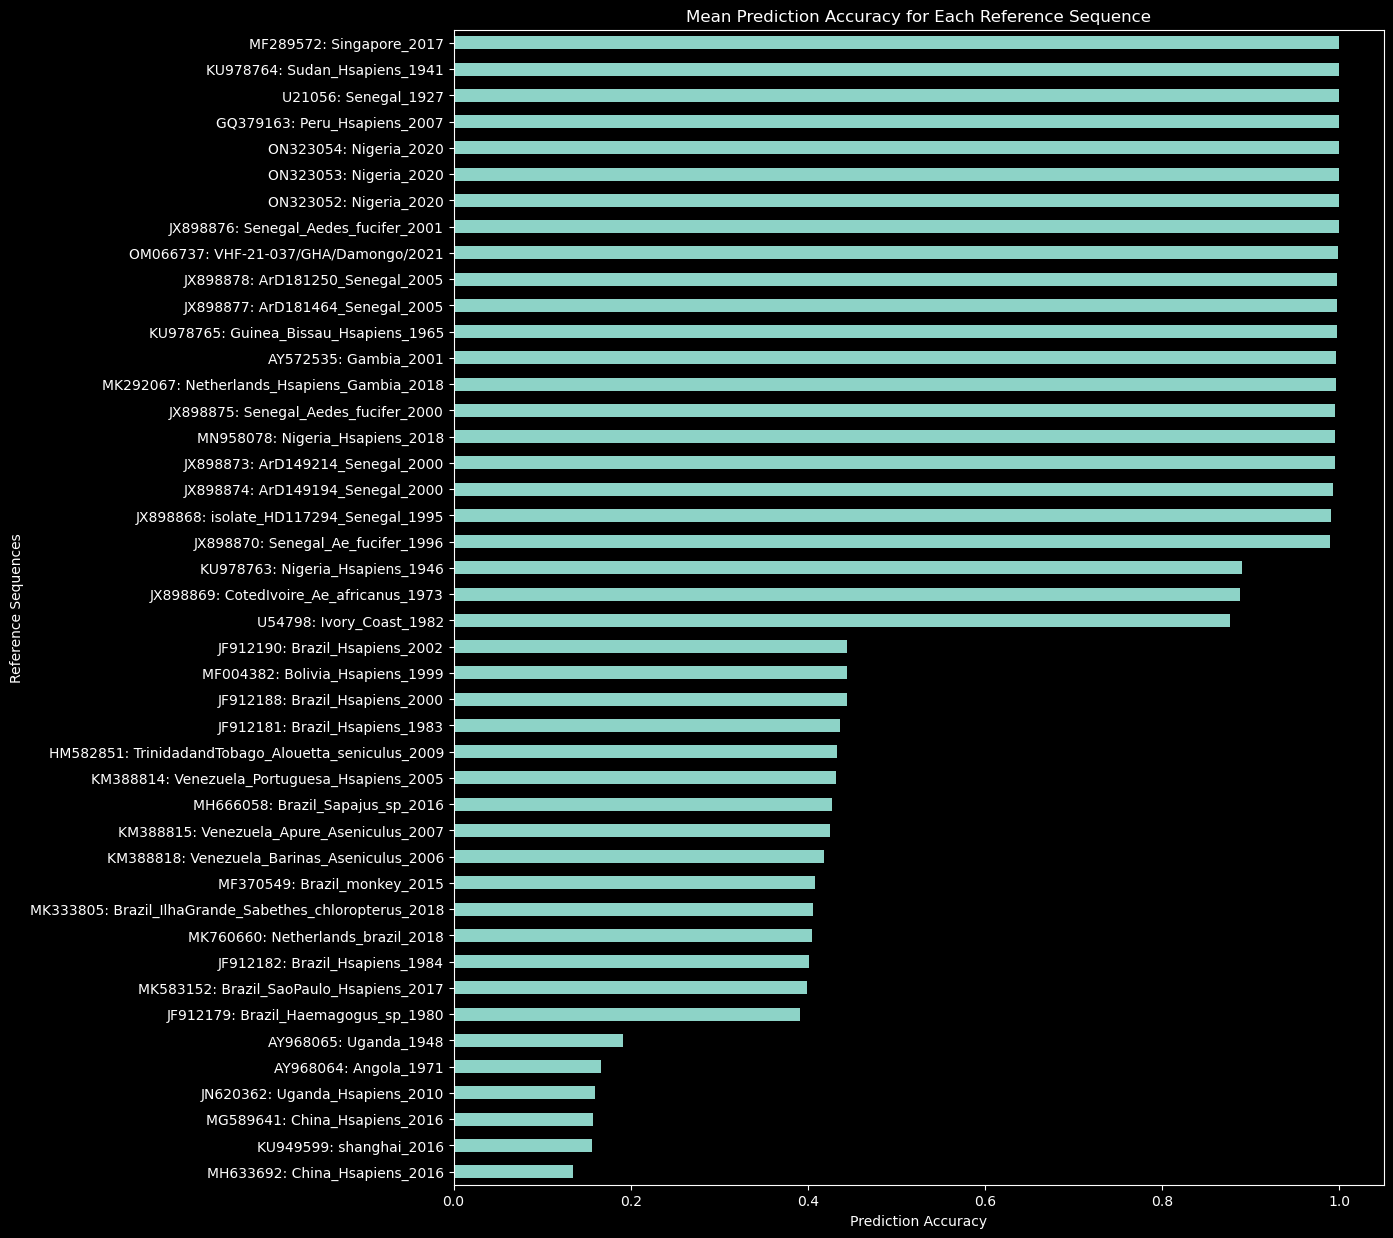

In [47]:
to_plot = df_refseqs.copy()
to_plot.index = to_plot['info']
fig, ax = plt.subplots(figsize=(12, 15))
to_plot.sort_values(by='mean acc')['mean acc'].plot(ax=ax,kind='barh', x='mean acc')
ax.set_title('Mean Prediction Accuracy for Each Reference Sequence');
ax.set_xlabel('Prediction Accuracy');
ax.set_ylabel('Reference Sequences');

Note: all reference sequence have the same lenght, that is 10,237 bp

In [48]:
refseq_length = 10_237

## Impact of Distance on Accuracy

Load the YF variants enveloppe percentage **distance matrix**

In [49]:
p2distances = pfs.data / 'ncbi/other/yf/YF_2023_envelop_percentage_distance_matrix.csv'
dist_mx = pd.read_csv(p2distances, index_col=0)
for col in dist_mx.columns:
    dist_mx[col] = dist_mx[col].str.rstrip('%').astype(float)/100
dist_mx

YFV_Cameroon_2023  YFV_CAR_2019  \
                                                                   
YFV_Cameroon_2023                             0.00          0.04   
YFV_CAR_2019                                  0.04          0.00   
U21056_senegal_1927                           0.19          0.19   
JX898870_senegal_1996                         0.19          0.18   
U23574_Senegal_1965                           0.19          0.18   
...                                            ...           ...   
MK760660_Netherlands_2018                     0.19          0.19   
MK333805_Brazil_IlhaGrande_2018               0.19          0.19   
MW308135_Brazil_2019                          0.19          0.19   
MZ604867_Brazil_2019                          0.19          0.19   
MZ712143_Brazil_2021                          0.19          0.19   

                                 U21056_senegal_1927  JX898870_senegal_1996  \
                                                                              
YFV_Cameroon_2023                               0.19                   0.19   
YFV_CAR_2019                                    0.19                   0.18   
U21056_senegal_1927                             0.00                   0.04   
JX898870_senegal_1996                           0.04                   0.00   
U23574_Senegal_1965                             0.04                   0.03   
...                                              ...                    ...   
MK760660_Netherlands_2018                       0.15                   0.15   
MK333805_Brazil_IlhaGrande_2018                 0.15                   0.15   
MW308135_Brazil_2019                            0.15                   0.15   
MZ604867_Brazil_2019                            0.15                   0.15   
MZ712143_Brazil_2021                            0.15                   0.15   

                                 U23574_Senegal_1965  JX898868_Senegal_1995  \
                                                                              
YFV_Cameroon_2023                               0.19                   0.19   
YFV_CAR_2019                                    0.18                   0.18   
U21056_senegal_1927                             0.04                   0.04   
JX898870_senegal_1996                           0.03                   0.00   
U23574_Senegal_1965                             0.00                   0.03   
...                                              ...                    ...   
MK760660_Netherlands_2018                       0.15                   0.15   
MK333805_Brazil_IlhaGrande_2018                 0.15                   0.15   
MW308135_Brazil_2019                            0.15                   0.15   
MZ604867_Brazil_2019                            0.15                   0.15   
MZ712143_Brazil_2021                            0.15                   0.15   

                                 JX898873_ArD149214_Senegal_2000  \
                                                                   
YFV_Cameroon_2023                                           0.19   
YFV_CAR_2019                                                0.18   
U21056_senegal_1927                                         0.05   
JX898870_senegal_1996                                       0.03   
U23574_Senegal_1965                                         0.04   
...                                                          ...   
MK760660_Netherlands_2018                                   0.15   
MK333805_Brazil_IlhaGrande_2018                             0.15   
MW308135_Brazil_2019                                        0.15   
MZ604867_Brazil_2019                                        0.16   
MZ712143_Brazil_2021                                        0.15   

                                 JX898874_ArD149194_Senegal_2000  \
                                                                   
YFV_Cameroon_2023                                           0.19   
YFV

We need to map the index/column in the distance matrix to the reference sequence accession.
- extract the accession and other metadata from the distance matrix column names (`distance_accessions`)
- compare accessions in the matrix and those in the our selected reference sequence list
- create `refseqid2index`, a map (dict) between `refseqid`'s and distance matric index/column names

In [50]:
distance_accessions = {}
missing=[]
for col in dist_mx.columns:
    regex = re.compile(r'^(?P<accession>\w{1,2}\d*)_(?P<country>.*)_(?P<year>\d\d\d\d)$')
    match = regex.search(col)
    if match: 
        accession = match.group('accession')
        subdict = {
            'accession': accession, 
            'country': match.group('country'), 
            'year': match.group('year'),
            'definition line': col
            } 
        distance_accessions[accession] = subdict
    else:
        missing =+ 1
        print(col, 'could not find the accession')

distance_accessions['U21056']

YFV_Cameroon_2023 could not find the accession
YFV_CAR_2019 could not find the accession
Yellow_fever_YF118_CAR_2018 could not find the accession


{'accession': 'U21056',
 'country': 'senegal',
 'year': '1927',
 'definition line': 'U21056_senegal_1927'}

In [51]:
fa = FastaFileReader(pfs.data/'ncbi/refsequences/yf/yf_2023_yellow_fever.fa')
aln = AlnFileReader(pfs.data/'ncbi/simreads/yf/single_69seq_150bp/single_69seq_150bp.aln')
refseq_metadata = aln.parse_header_reference_sequences()

In [52]:
for i, refseqid in enumerate(df_refseqs.index):
    accession = df_refseqs.loc[refseqid, 'refseq_accession']
    print(f"{i+1:2d}. {accession:10s} {refseqid:15s} {distance_accessions.get(accession, 'not found')['definition line']}")

 1. AY968064   11089:ncbi:1    AY968064_angola_1971
 2. U54798     11089:ncbi:2    U54798_Ivory_Coast_1982
 3. AY572535   11089:ncbi:4    AY572535_Gambia_2001
 4. U21056     11089:ncbi:6    U21056_senegal_1927
 5. AY968065   11089:ncbi:7    AY968065_Uganda_1948
 6. GQ379163   11089:ncbi:10   GQ379163_Peru_2007
 7. MF289572   11089:ncbi:12   MF289572_Singapore_2017
 8. KU978764   11089:ncbi:13   KU978764_Sudan_1941
 9. JX898878   11089:ncbi:14   JX898878_ArD181250_Senegal_2005
10. JX898877   11089:ncbi:18   JX898877_ArD181464_Senegal_2005
11. JX898876   11089:ncbi:19   JX898876_Senegal_2001
12. KU978765   11089:ncbi:20   KU978765_GuineaBissau_1965
13. JX898870   11089:ncbi:21   JX898870_senegal_1996
14. JX898868   11089:ncbi:22   JX898868_Senegal_1995
15. JX898875   11089:ncbi:23   JX898875_Senegal_2000
16. JX898874   11089:ncbi:24   JX898874_ArD149194_Senegal_2000
17. JX898873   11089:ncbi:25   JX898873_ArD149214_Senegal_2000
18. MK292067   11089:ncbi:26   MK292067_Netherlands_2018
19.

In [53]:
refseqid2index = {refseqid:distance_accessions[accession]['definition line'] for refseqid,accession in zip(df_refseqs.index, df_refseqs.refseq_accession)}
refseqid2index['11089:ncbi:10']

'GQ379163_Peru_2007'

Now we can create a new distance matrix whose index/column names only include the selected references

In [54]:
dist_mx = dist_mx.loc[refseqid2index.values(), refseqid2index.values()]
print(dist_mx.shape)
dist_mx.iloc[:5,:5]

(44, 44)


AY968064_angola_1971  U54798_Ivory_Coast_1982  \
                                                                         
AY968064_angola_1971                     0.00                     0.20   
U54798_Ivory_Coast_1982                  0.20                     0.00   
AY572535_Gambia_2001                     0.18                     0.09   
U21056_senegal_1927                      0.18                     0.10   
AY968065_Uganda_1948                     0.13                     0.19   

                         AY572535_Gambia_2001  U21056_senegal_1927  \
                                                                     
AY968064_angola_1971                     0.18                 0.18   
U54798_Ivory_Coast_1982                  0.09                 0.10   
AY572535_Gambia_2001                     0.00                 0.05   
U21056_senegal_1927                      0.05                 0.00   
AY968065_Uganda_1948                     0.18                 0.18   

                         AY968065_Uganda_1948  
                                               
AY968064_angola_1971                     0.13  
U54798_Ivory_Coast_1982                  0.19  
AY572535_Gambia_2001                     0.18  
U21056_senegal_1927                      0.18  
AY968065_Uganda_1948                     0.00

### Pick a base variant from which to measure distances

Select the **basis sequence** for distance, as one of the sequence with perfect accuracy:

In [55]:
df_refseqs.loc[df_refseqs['mean acc'] ==1.0, :]

refseq_accession             organism  \
refseqid                                              
11089:ncbi:6            U21056         Senegal_1927   
11089:ncbi:10         GQ379163   Peru_Hsapiens_2007   
11089:ncbi:12         MF289572       Singapore_2017   
11089:ncbi:13         KU978764  Sudan_Hsapiens_1941   

                                        info  mean acc  
refseqid                                                
11089:ncbi:6            U21056: Senegal_1927       1.0  
11089:ncbi:10   GQ379163: Peru_Hsapiens_2007       1.0  
11089:ncbi:12       MF289572: Singapore_2017       1.0  
11089:ncbi:13  KU978764: Sudan_Hsapiens_1941       1.0

Pick `'11089:ncbi:6' U21056	Senegal_1927`, as it the the oldest one with 100% accuracy

In [56]:
basis_sequence = '11089:ncbi:6'

Create a distances `Series`: one dimension array of distance from basis sequence to each of the other sequences

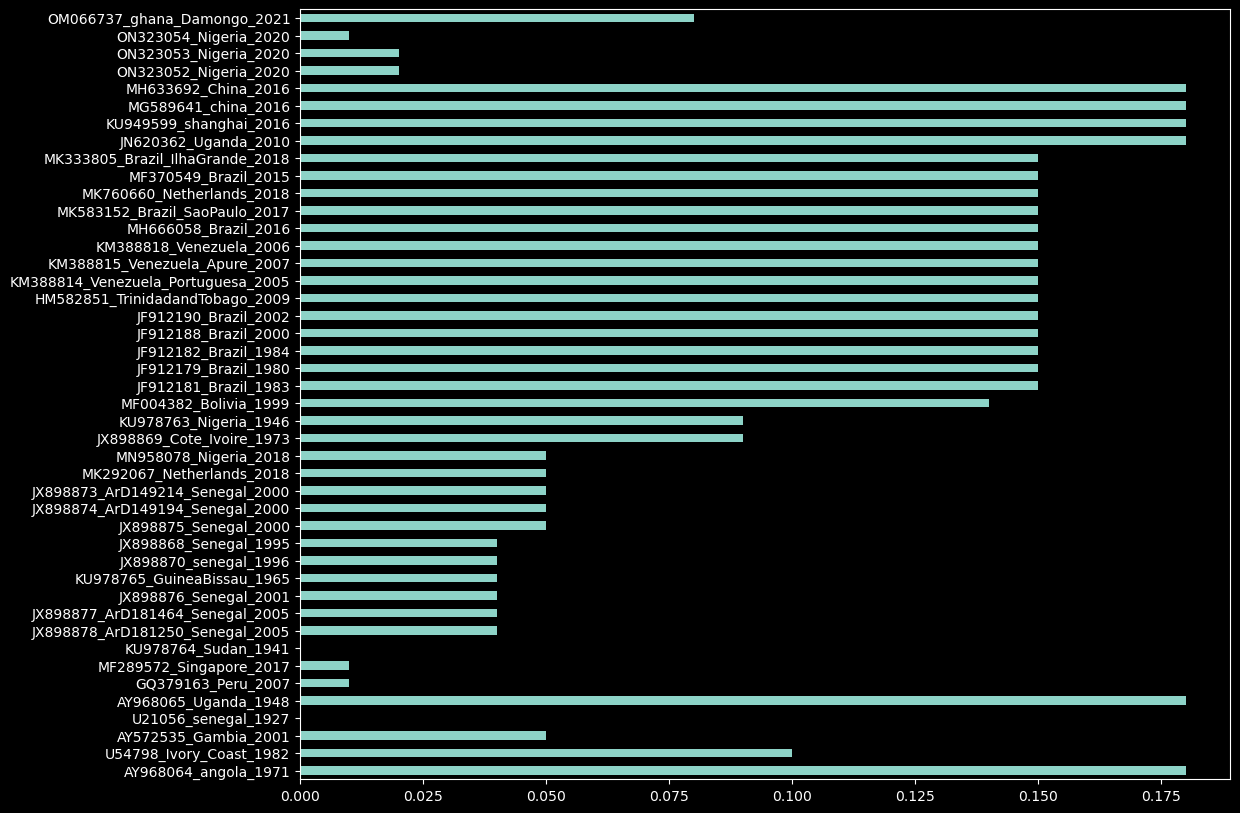

In [57]:
distances = dist_mx.loc[refseqid2index[basis_sequence], :]
distances.plot(kind='barh', figsize=(12, 10));

Create a set of index lists to sort both `df_refseq` and `distances` in the same order, i.e. decreasing order of accuracy. Then reorder the `df_refseqs` and `distances` dataframe

In [58]:
ordered_accuracies = df_refseqs.sort_values('mean acc', ascending=False)
ordered_index = ordered_accuracies.index
print('df_refseqs by decreasing accuracies:')
display(ordered_accuracies.head(3))

ordered_distance_index = list(map(refseqid2index.get, ordered_index))
ordered_distances = distances.loc[ordered_distance_index]
print('distances ordered by decreasing accuracies of the reference sequence:')
display(ordered_distances[:3])

# Add distances to the df_refseqs
df_refseqs.loc[ordered_index, 'distance'] = ordered_distances.values
print('df_refseqs with distance columns, ordered by decreasing accuracies:')
display(df_refseqs.loc[ordered_index].head(3))
print('df_refseqs with distance columns, ordered in normal order:')
display(df_refseqs.head(3))

distances = distances.loc[ordered_distance_index]
distances.head(3)

df_refseqs by decreasing accuracies:


refseq_accession            organism  \
refseqid                                             
11089:ncbi:6            U21056        Senegal_1927   
11089:ncbi:10         GQ379163  Peru_Hsapiens_2007   
11089:ncbi:12         MF289572      Singapore_2017   

                                       info  mean acc  
refseqid                                               
11089:ncbi:6           U21056: Senegal_1927       1.0  
11089:ncbi:10  GQ379163: Peru_Hsapiens_2007       1.0  
11089:ncbi:12      MF289572: Singapore_2017       1.0

distances ordered by decreasing accuracies of the reference sequence:


U21056_senegal_1927        0.00
GQ379163_Peru_2007         0.01
MF289572_Singapore_2017    0.01
Name: U21056_senegal_1927, dtype: float64

df_refseqs with distance columns, ordered by decreasing accuracies:


refseq_accession            organism  \
refseqid                                             
11089:ncbi:6            U21056        Senegal_1927   
11089:ncbi:10         GQ379163  Peru_Hsapiens_2007   
11089:ncbi:12         MF289572      Singapore_2017   

                                       info  mean acc  distance  
refseqid                                                         
11089:ncbi:6           U21056: Senegal_1927       1.0      0.00  
11089:ncbi:10  GQ379163: Peru_Hsapiens_2007       1.0      0.01  
11089:ncbi:12      MF289572: Singapore_2017       1.0      0.01

df_refseqs with distance columns, ordered in normal order:


refseq_accession          organism                      info  \
refseqid                                                                    
11089:ncbi:1         AY968064       Angola_1971     AY968064: Angola_1971   
11089:ncbi:2           U54798  Ivory_Coast_1982  U54798: Ivory_Coast_1982   
11089:ncbi:4         AY572535       Gambia_2001     AY572535: Gambia_2001   

              mean acc  distance  
refseqid                          
11089:ncbi:1  0.166765      0.18  
11089:ncbi:2  0.876000      0.10  
11089:ncbi:4  0.996000      0.05

U21056_senegal_1927        0.00
GQ379163_Peru_2007         0.01
MF289572_Singapore_2017    0.01
Name: U21056_senegal_1927, dtype: float64

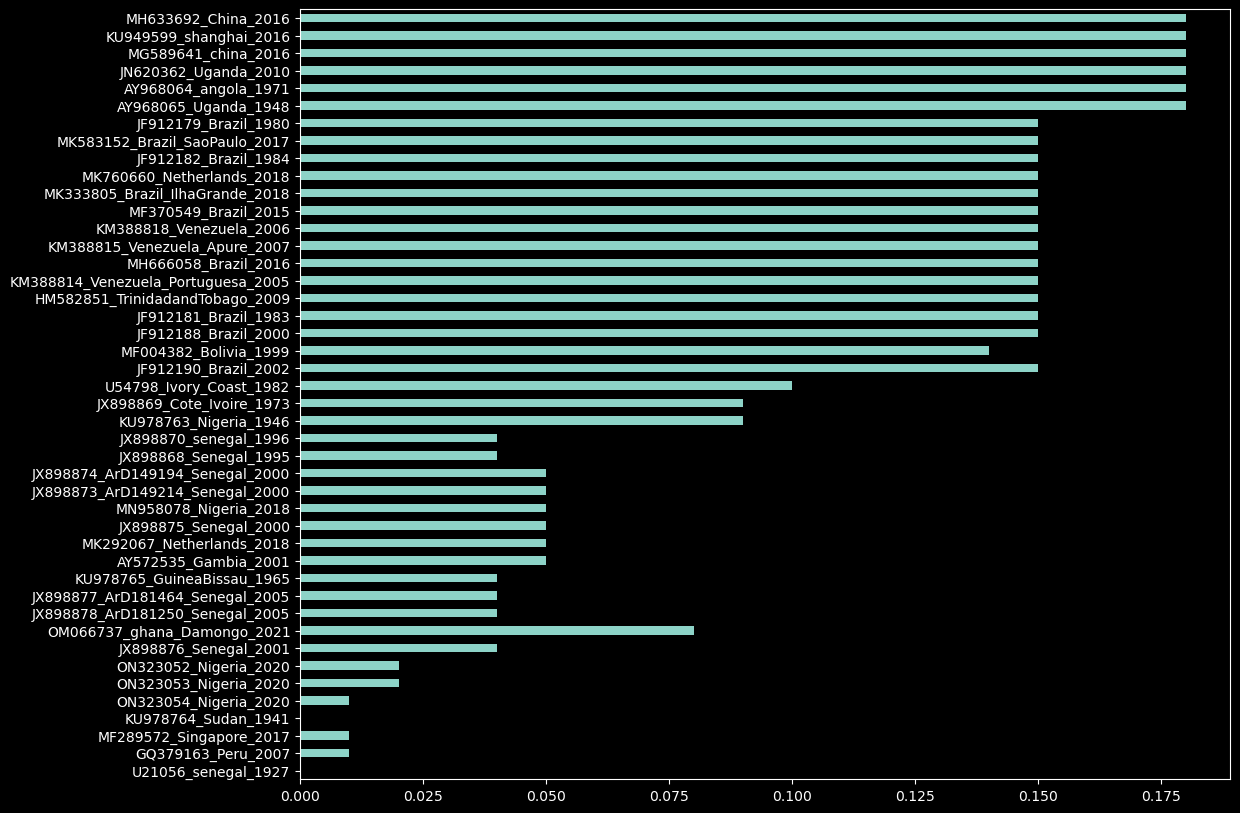

In [59]:
distances.loc[ordered_distance_index].plot(kind='barh', figsize=(12, 10));

Plot the relationship between distance and accuracy for each reference sequence

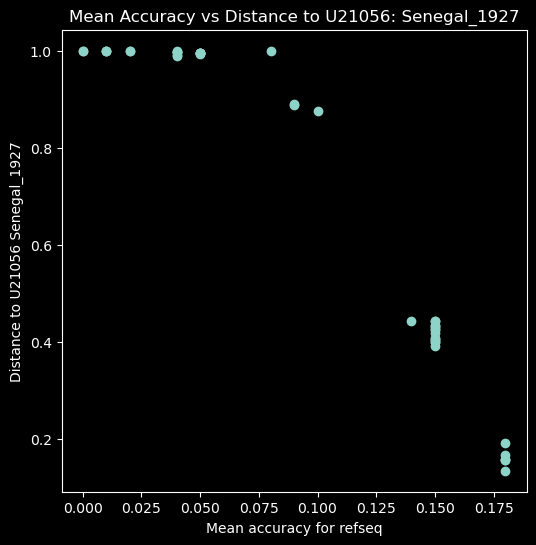

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df_refseqs['distance'], y=df_refseqs['mean acc'])
ax.set_title(f"Mean Accuracy vs Distance to U21056: Senegal_1927")
ax.set_xlabel('Mean accuracy for refseq')
ax.set_ylabel('Distance to U21056 Senegal_1927')
plt.show()

In [61]:
correlations = df_refseqs.loc[:, ['mean acc', 'distance']].corr()
print(f"Correlation between mean accuracy and distance to U21056: Senegal_1927: {correlations.loc['mean acc', 'distance']:.1%}")

Correlation between mean accuracy and distance to U21056: Senegal_1927: -96.0%


Clear negative correlation between the mean accuracy and the distance between a sequence and U21056-Senegal_1927. (-96.0%)

## Impact of Read Position on Accuracy

Instead of binning `pos_true`, we will just use the value itself as the bin

In [78]:
nb_bins = refseq_length
print(f"Using {nb_bins:,d} position bins. Each bin includes {refseq_length//nb_bins} nucleotides")
df['bin'], pos_bins = df['pos_true'], df['pos_true']
nb_reads_per_position = df.groupby(by='bin')['bin'].count().mean()
print(f"Average of {int(nb_reads_per_position):,d} reads per position bin")
df.head(3)

Using 10,237 position bins. Each bin includes 1 nucleotides
Average of 76 reads per position bin


refseqid  accuracy  lbl_true  lbl_pred  pos_true  \
readid                                                                     
11089:ncbi:1-17000  11089:ncbi:1     False       118        10      7804   
11089:ncbi:1-16999  11089:ncbi:1     False       118         2      6069   
11089:ncbi:1-16998  11089:ncbi:1     False       118       144      5317   

                    pos_pred  preds_score  probs_score  top_5_lbl_pred_0  \
readid                                                                     
11089:ncbi:1-17000         0     0.296598     0.122977               118   
11089:ncbi:1-16999         4    -0.024773     0.003527                62   
11089:ncbi:1-16998         4     0.090977     0.233104               144   

                    top_5_lbl_pred_1  top_5_lbl_pred_2  top_5_lbl_pred_3  \
readid                                                                     
11089:ncbi:1-17000                32                10                62   
11089:ncbi:1-16999                 2                32                 9   
11089:ncbi:1-16998               146                62               118   

                    top_5_lbl_pred_4   bin  
readid                                      
11089:ncbi:1-17000                94  7804  
11089:ncbi:1-16999                 1  6069  
11089:ncbi:1-16998               143  5317

In [83]:
fa.reset_iterator()
for o in fa:
    if len(o['sequence']) != refseq_length:
        print(f"Sequence {o['header']} has length {len(o['sequence'])}")

The true position is the position of the first BP in the simulated reads. As the reads are 150-mers reads in this datasets, we will not find any true position greater than 10,087.

In [165]:
unique_positions = df['pos_true'].unique()
missing_pos = set(range(refseq_length)).difference(set(df['pos_true'].unique()))
print(f"Sequences have {refseq_length:,d} positions (from 0 to {refseq_length-1:,d})")
print(f"Simulated reads (150-mer) start at one of {len(unique_positions):,d} unique positions.")
print(f"The difference {refseq_length:,d} - {len(unique_positions):,d} = {refseq_length-len(unique_positions):,d} is due to the 150 bp lenghts of the reads")
print(f"The largest position in dataset is {max(unique_positions)} (from 0 to {max(unique_positions)})")
print(f"There are {len(missing_pos)} positions from {min(missing_pos)} to {max(missing_pos)} that are not possible in the reads")

Sequences have 10,237 positions (from 0 to 10,236)
Simulated reads (150-mer) start at one of 10,087 unique positions.
The difference 10,237 - 10,087 = 150 is due to the 150 bp lenghts of the reads
The largest position in dataset is 10086 (from 0 to 10086)
There are 150 positions from 10087 to 10236 that are not possible in the reads


In [172]:
# df.loc[df['refseqid'] == refseqid, :].groupby('bin')['accuracy'].mean().index.max()
df.loc[df['refseqid'] == refseqid, :].bin.max()

10085

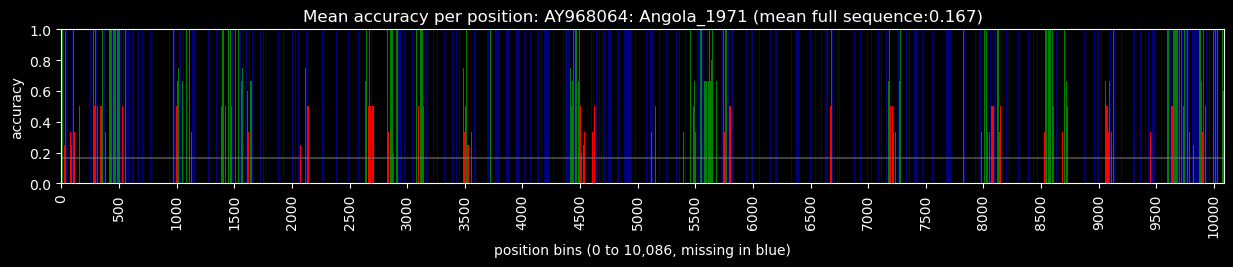

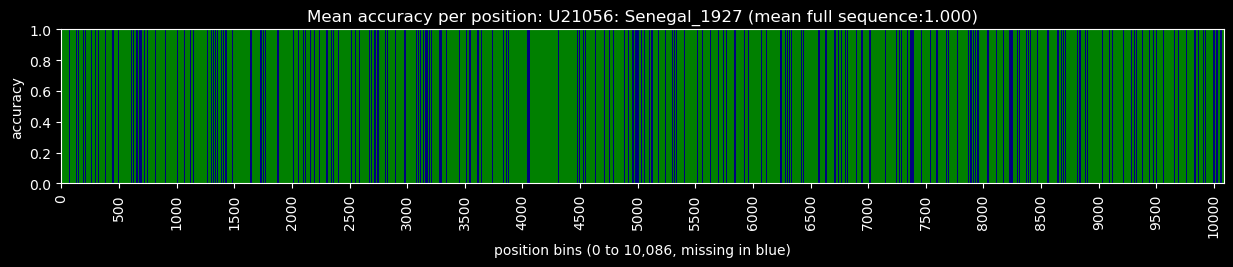

In [203]:
def plot_accuracy_per_position(df: pd.DataFrame, refseqid:str, figsize=(15,3), ax=None):
    df_ = df.loc[df['refseqid'] == refseqid, :]
    nb_position_bins = df_.bin.max()
    info = df_refseqs.loc[refseqid,'info']
    accuracy = df_['accuracy'].mean()
    acc_per_bin = df_.groupby('bin')['accuracy'].mean()
    acc_reindexed = acc_per_bin.reindex(range(nb_position_bins+1), fill_value=np.nan)
    missing_bins = pd.Series(index=acc_reindexed.index, data=1)
    missing_bins.loc[acc_reindexed.notna()] = np.nan

    if ax is None: 
        fig,ax = plt.subplots(figsize=figsize)
        show_this_axis = True
    else:
        show_this_axis = False

    bar_w = 1 
    colors = acc_reindexed.apply(lambda x: 'red' if x < 0.6 else 'green')

    acc_reindexed.plot(ax=ax, kind='bar', ylim=(0,1), width=bar_w, color=colors, legend=False)
    missing_bins.plot(ax=ax, kind='bar', ylim=(0,1), width=bar_w, color='blue', alpha=0.5, legend=False)
    ax.set_title(f"Mean accuracy per position: {info} (mean full sequence:{accuracy:.3f})")
    ax.hlines(y=accuracy, xmin=0, xmax=nb_position_bins, color='gray', linestyles='solid', alpha=0.5)
    ax.set_xlabel(f"position bins (0 to {nb_position_bins:,d}, missing in blue)")
    ax.set_ylabel('accuracy')
    ticks = range(0,nb_position_bins+1,500)
    ax.set_xticks(ticks, ticks)

    if show_this_axis: plt.show()

plot_accuracy_per_position(df, '11089:ncbi:1',figsize=(15,2), ax=None)
plot_accuracy_per_position(df, '11089:ncbi:6',figsize=(15,2), ax=None)

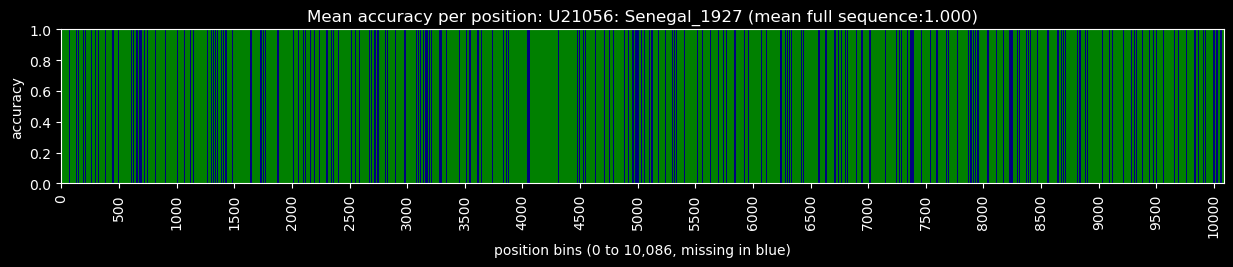

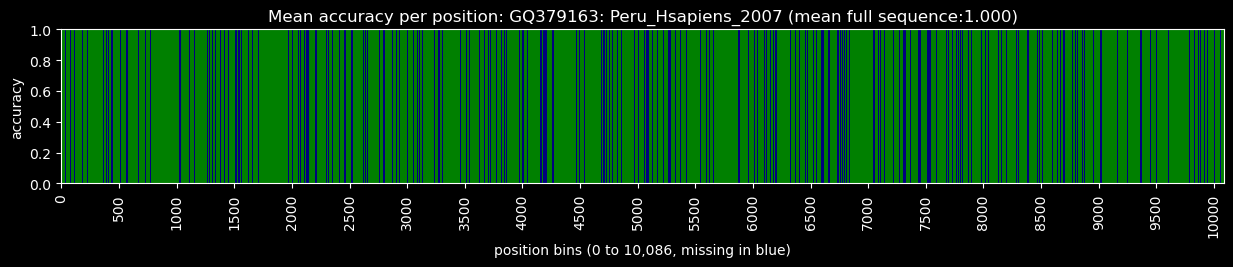

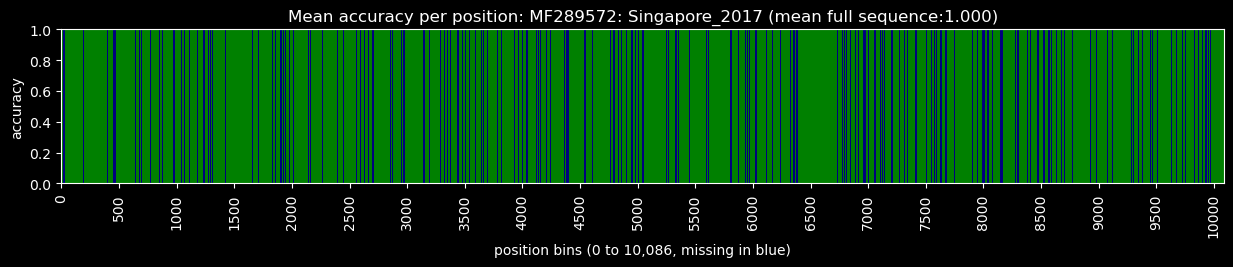

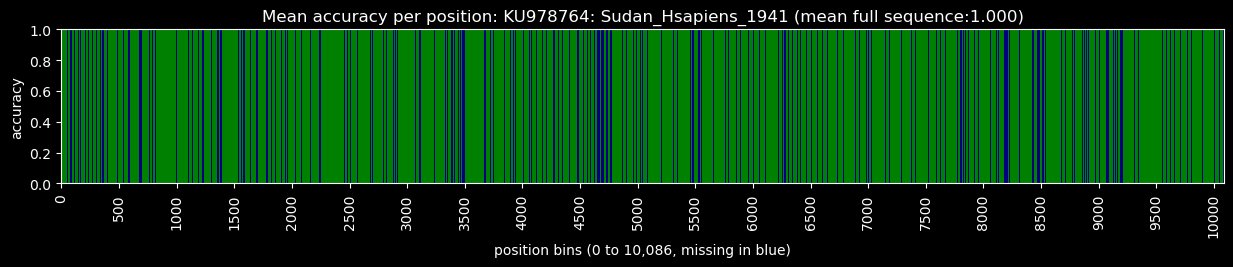

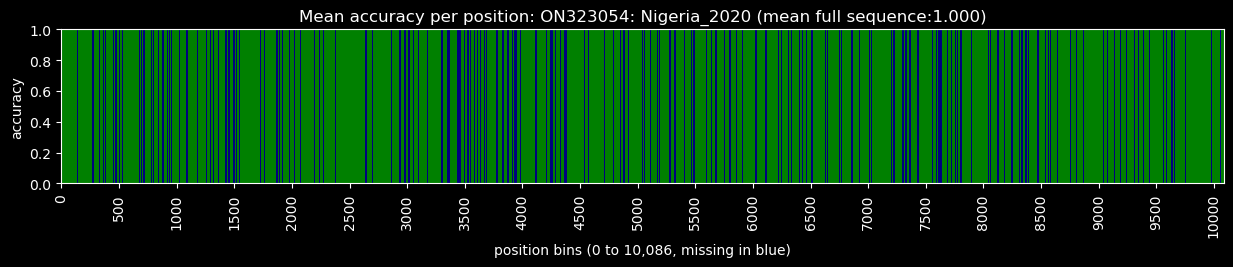

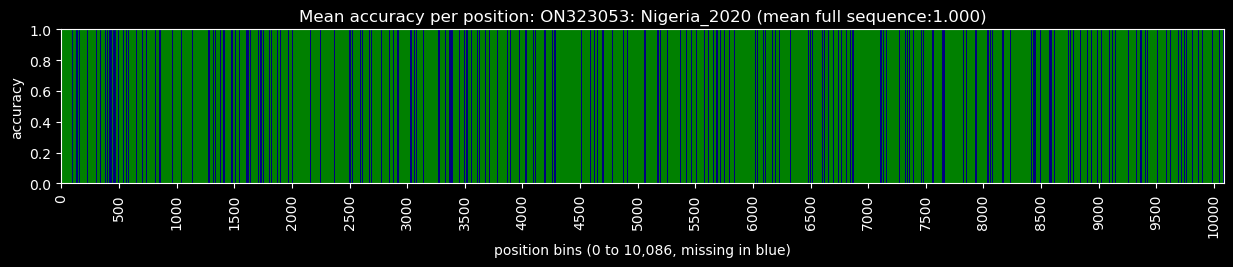

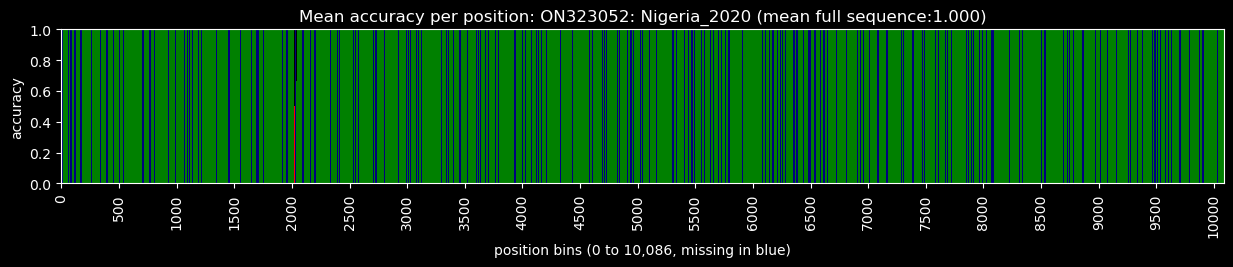

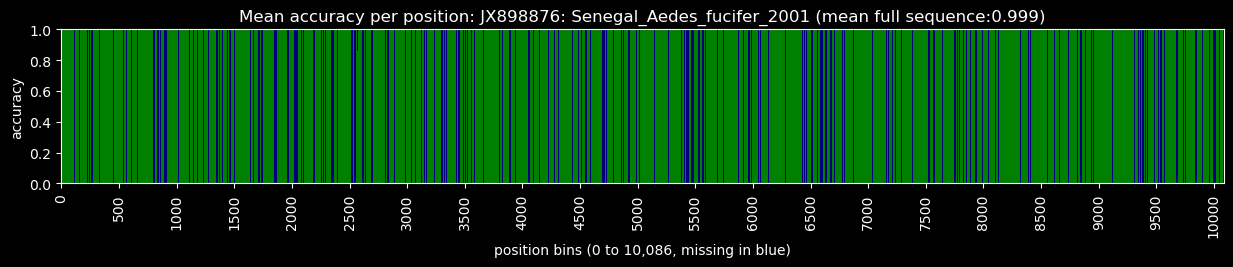

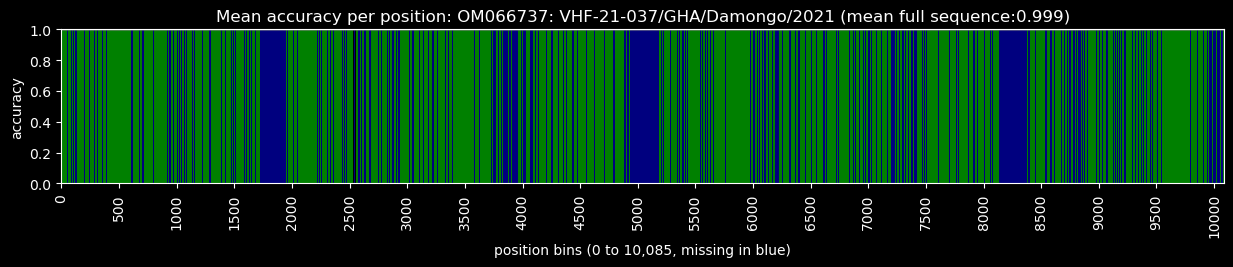

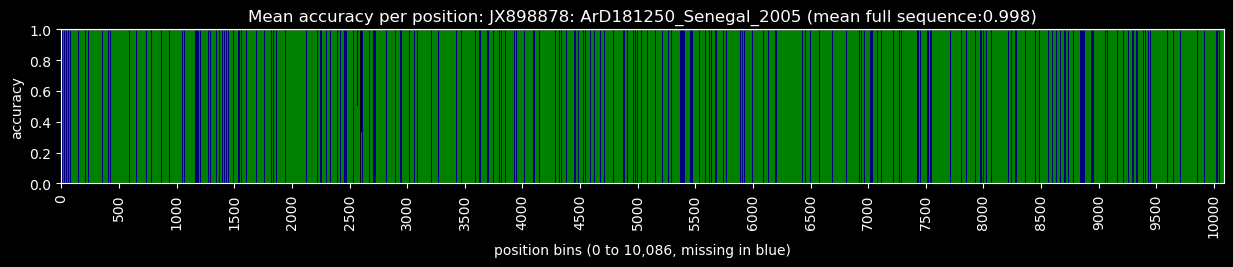

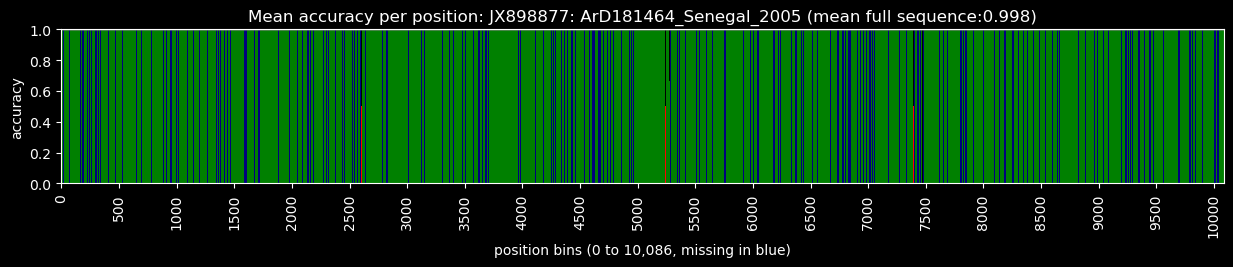

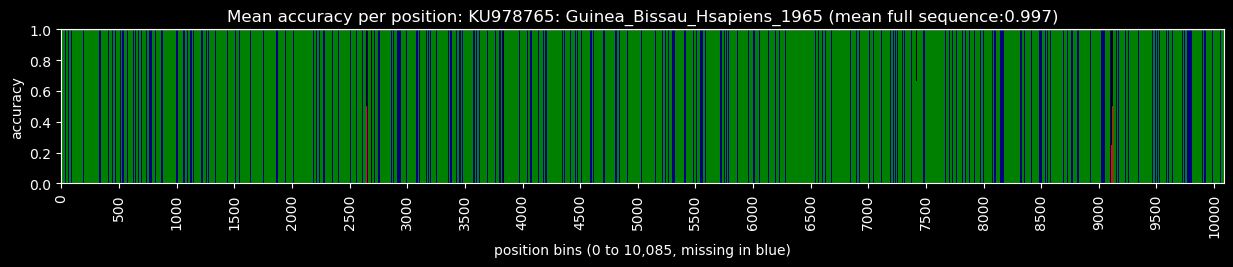

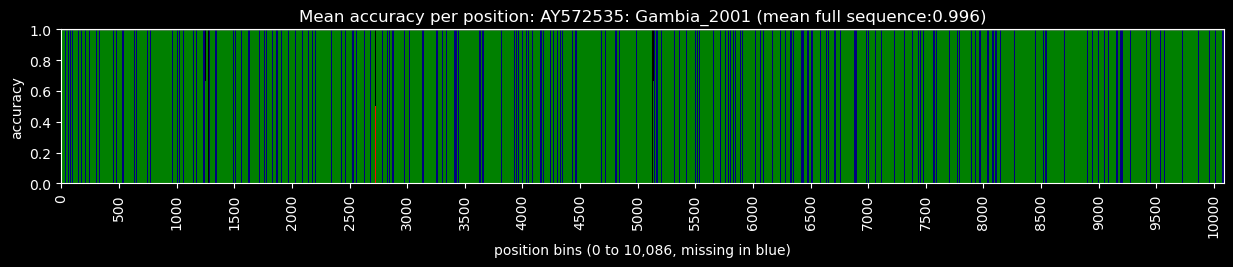

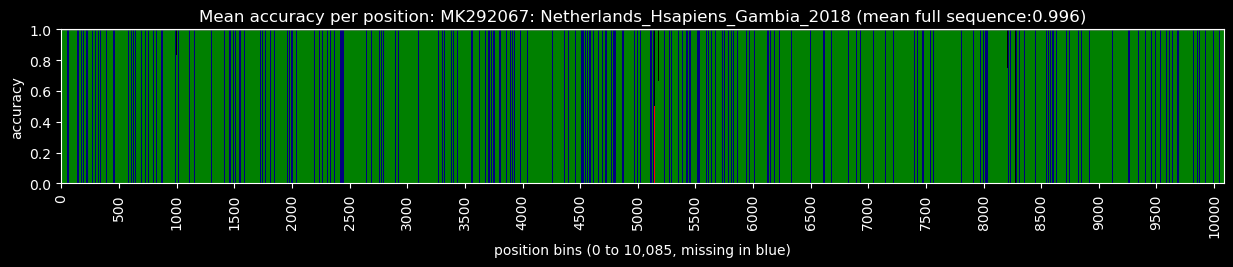

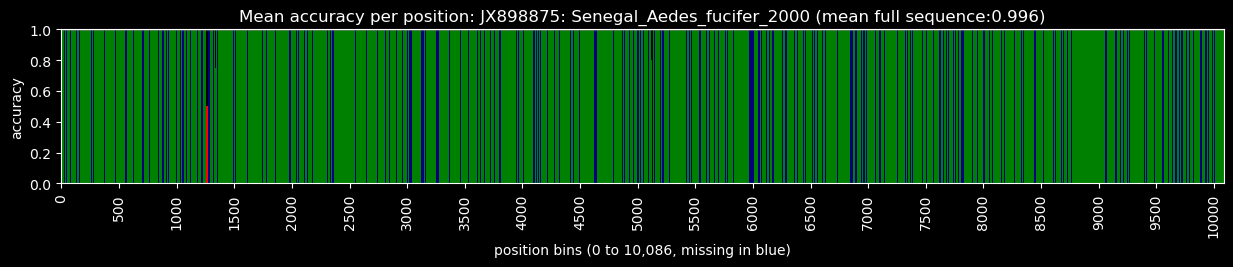

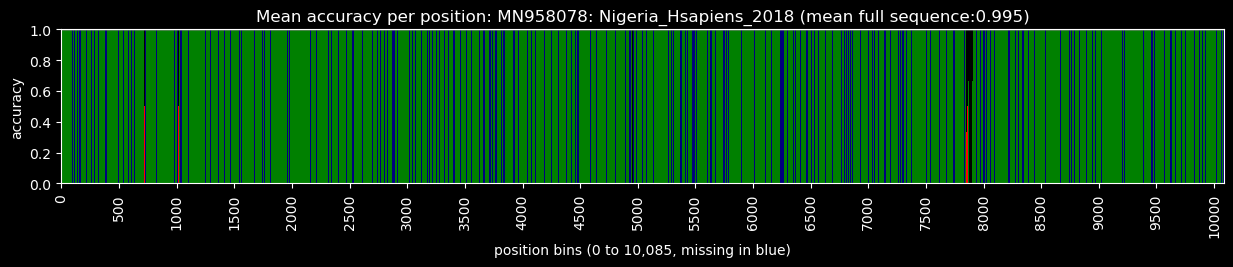

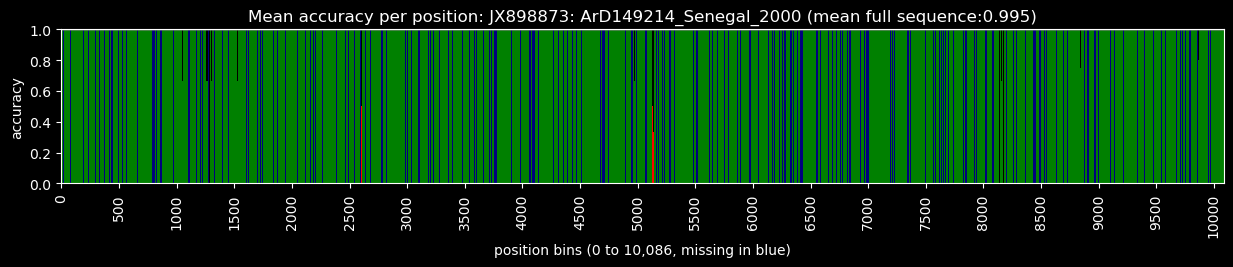

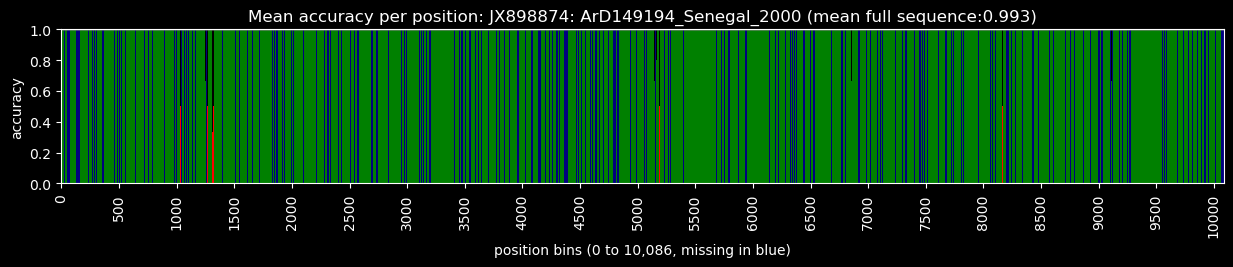

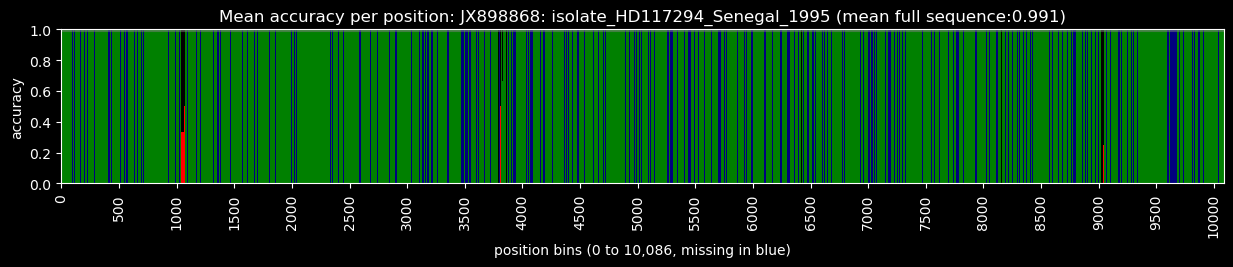

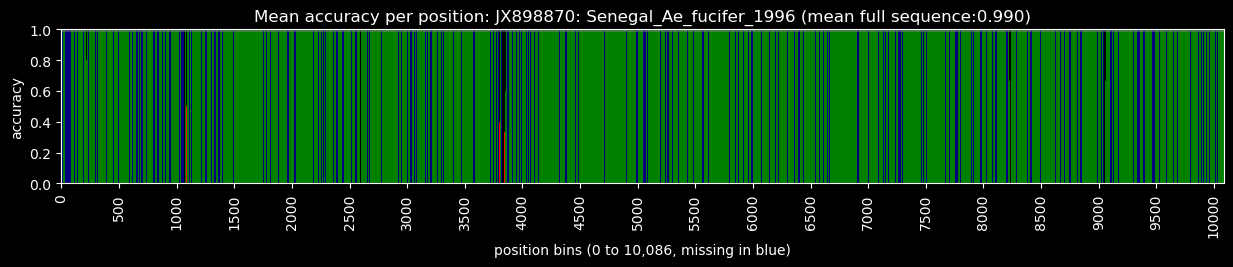

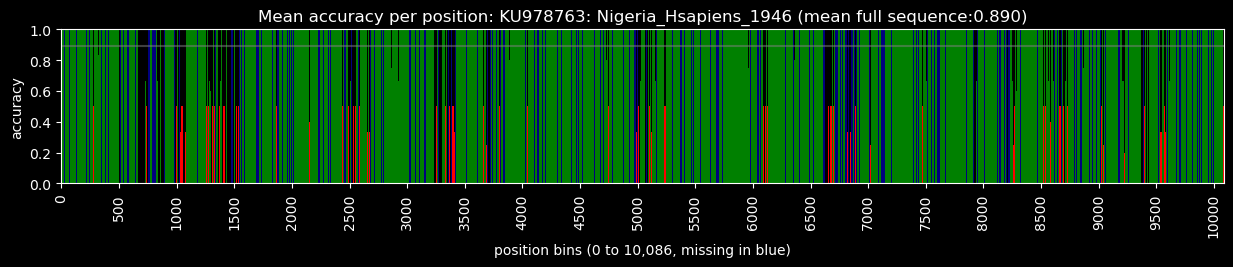

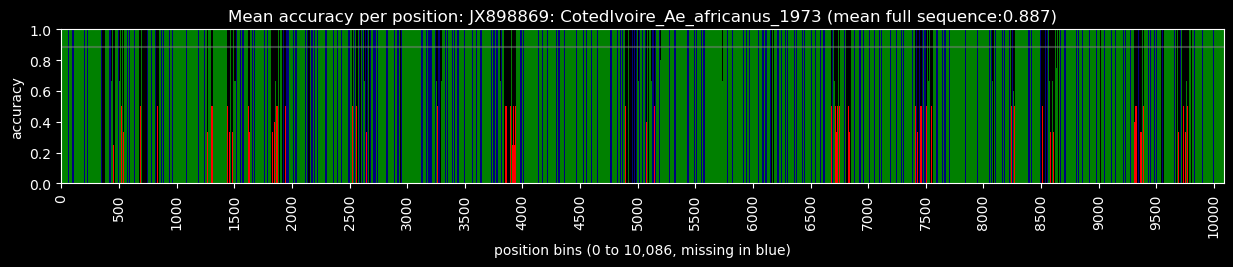

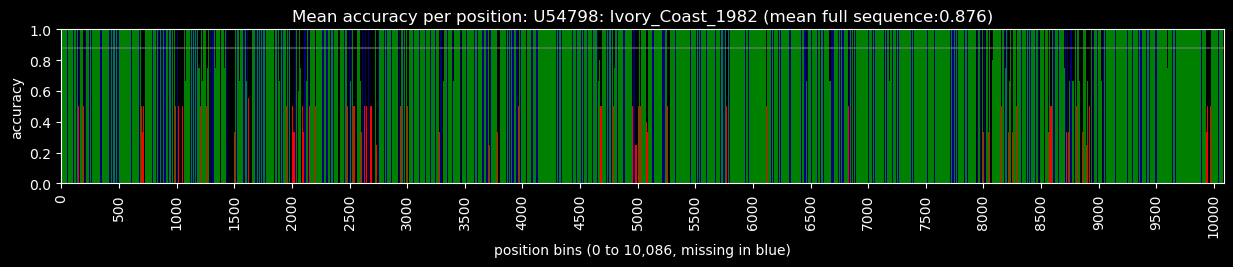

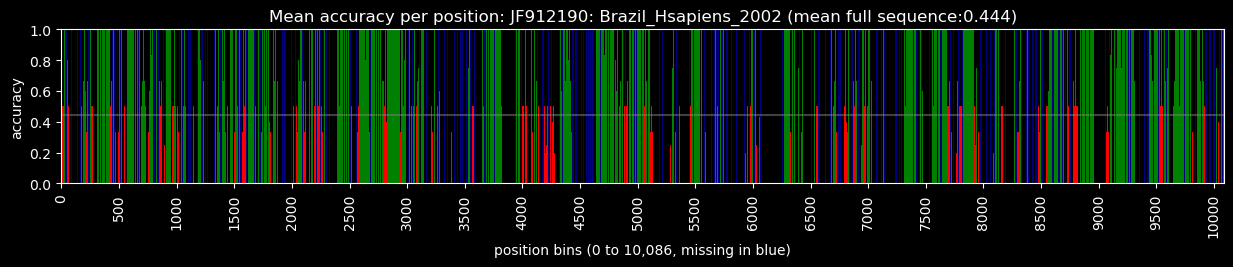

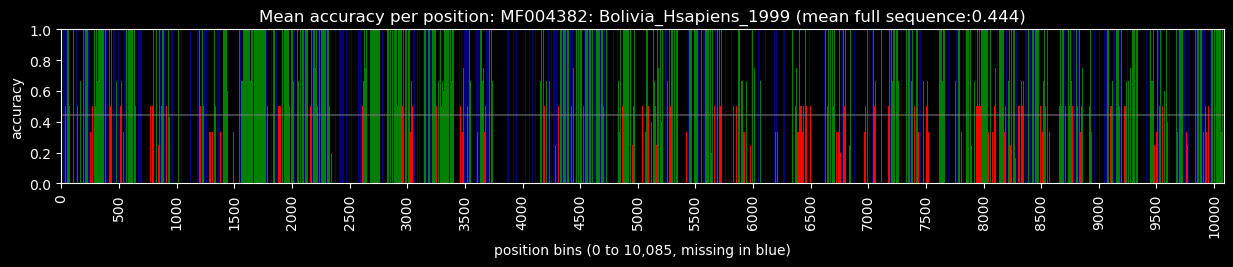

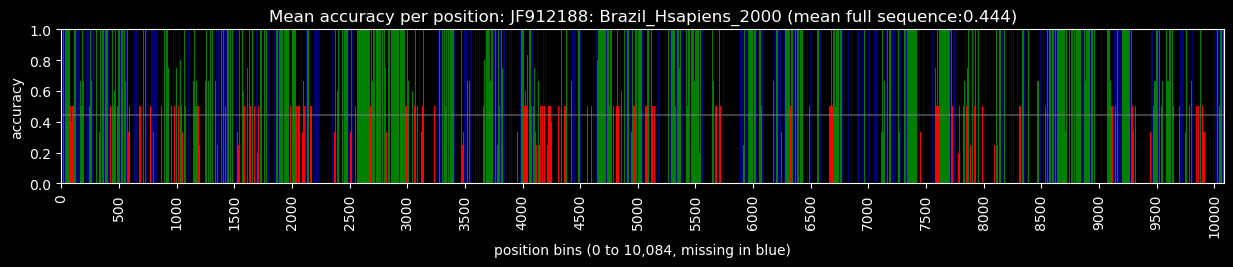

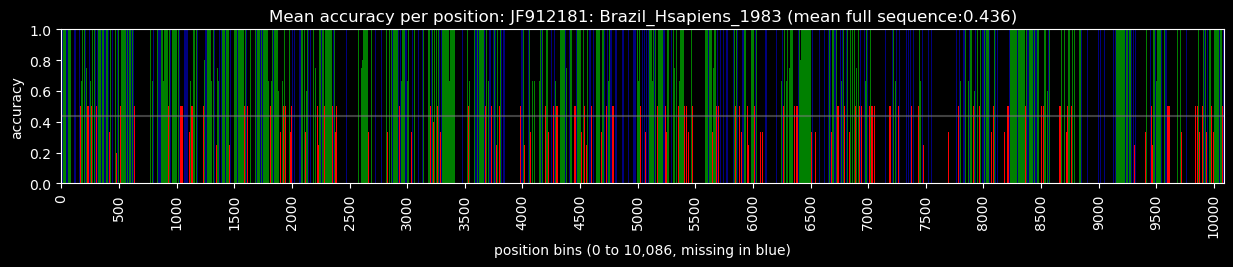

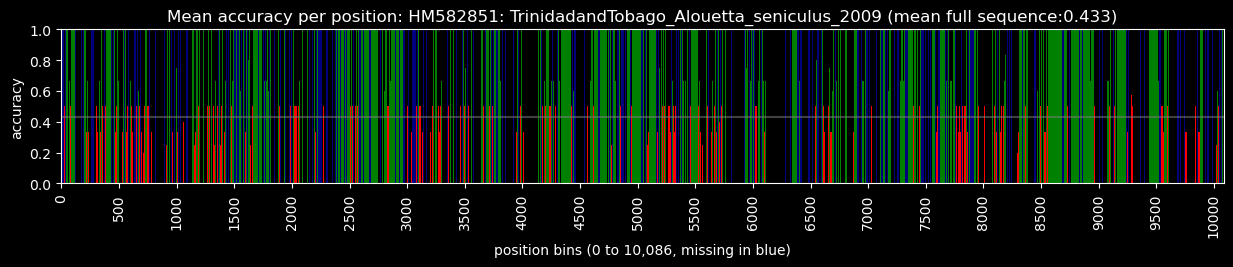

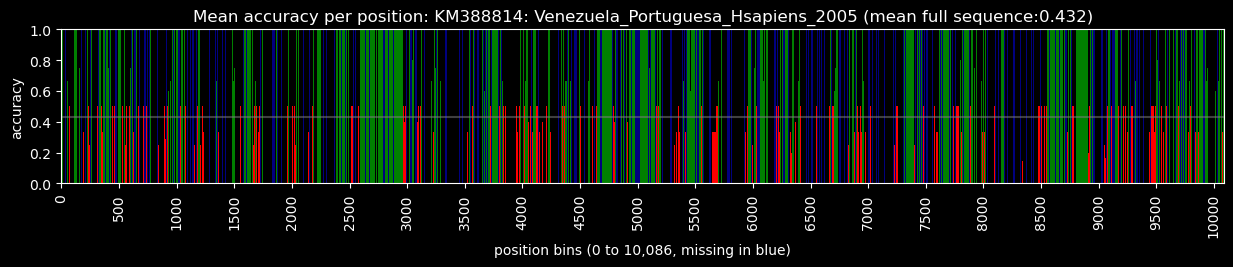

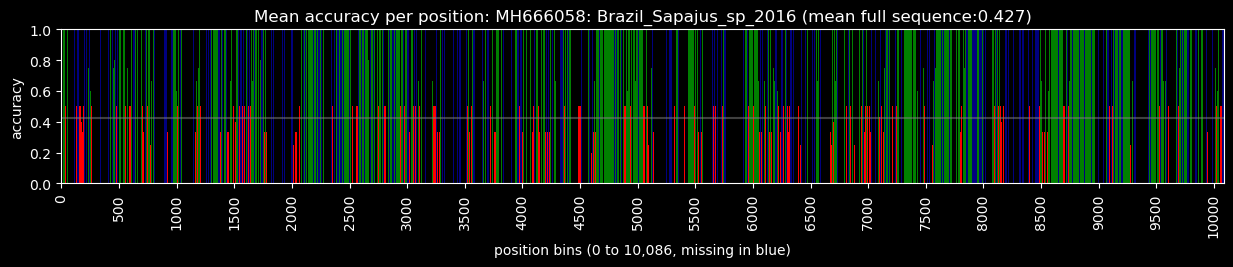

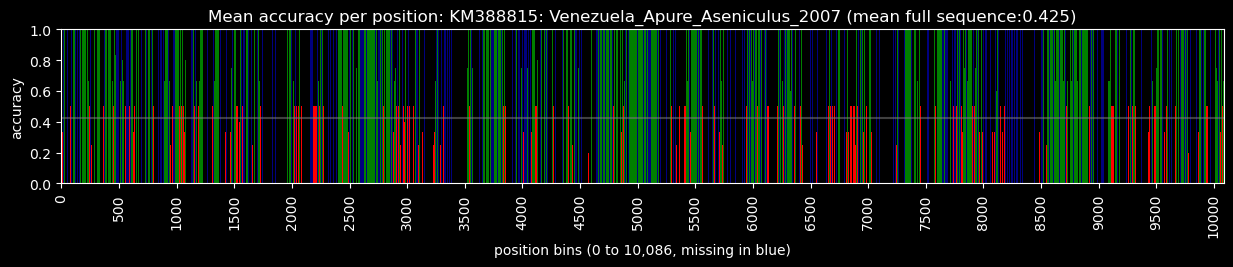

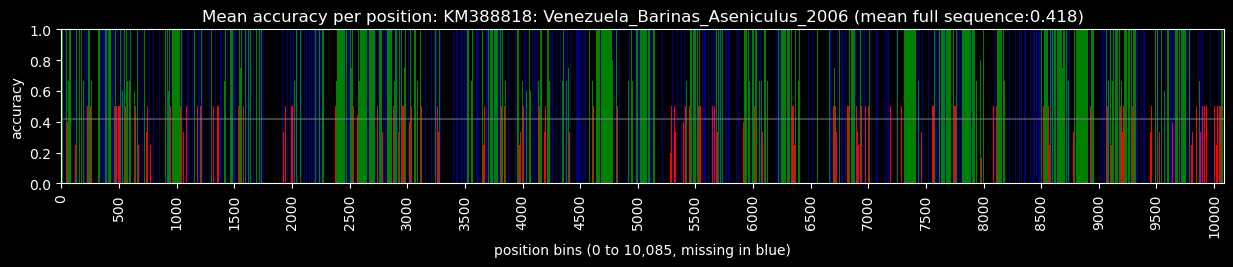

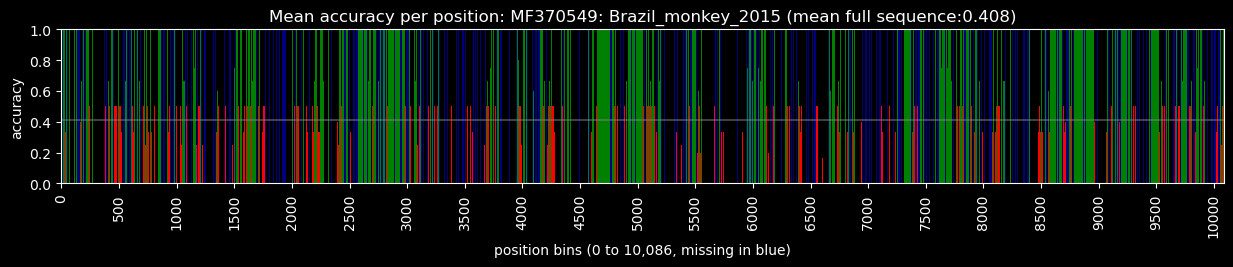

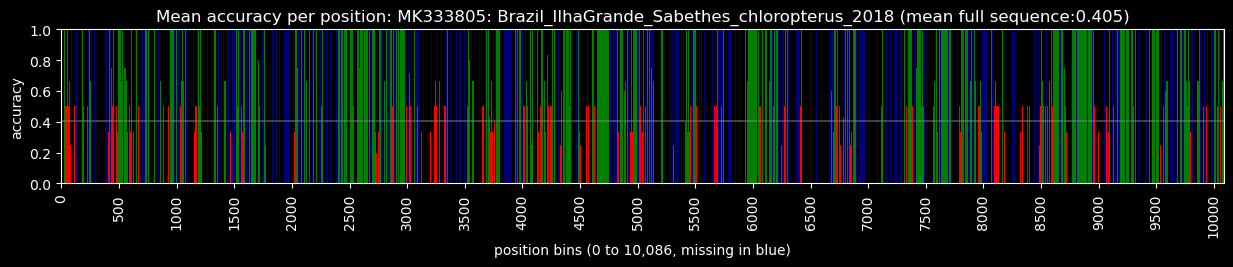

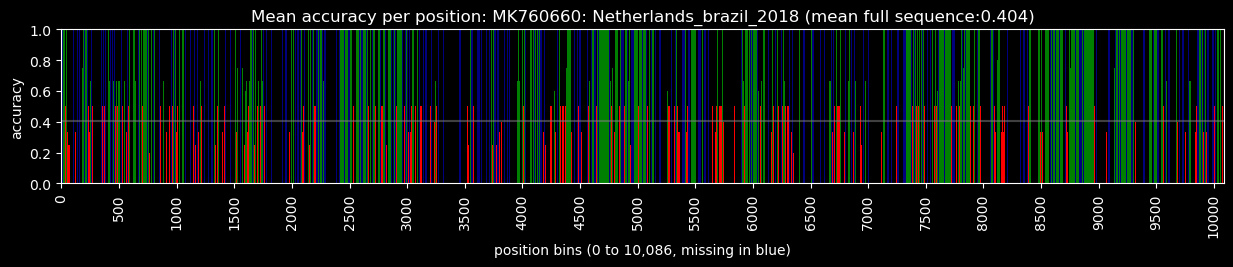

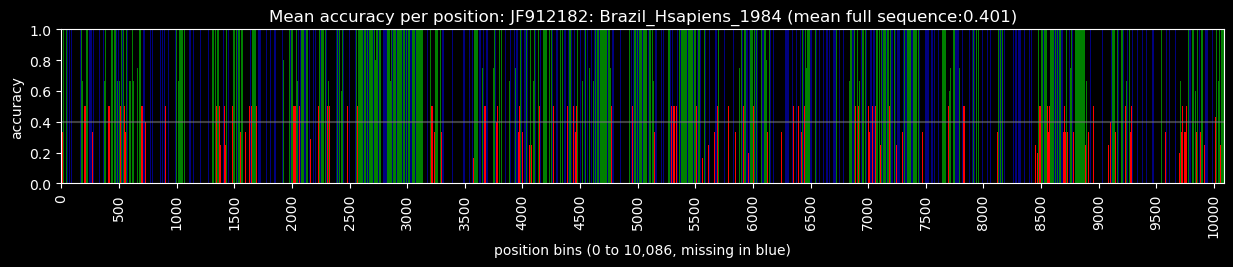

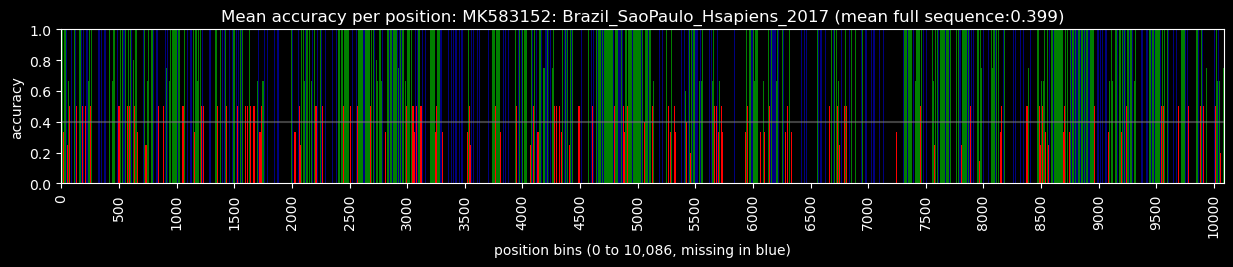

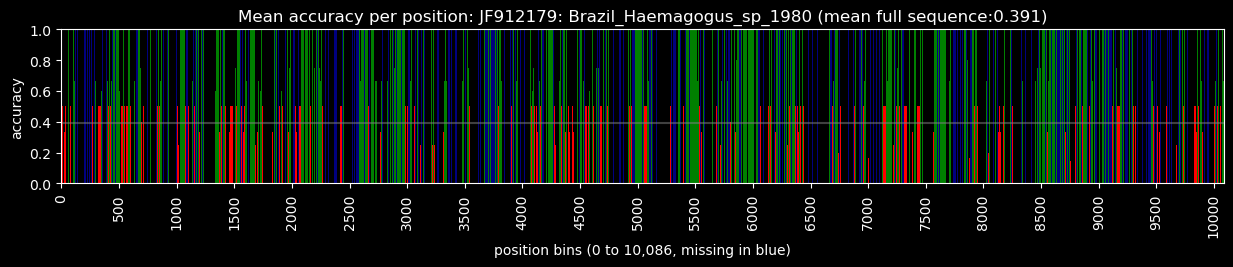

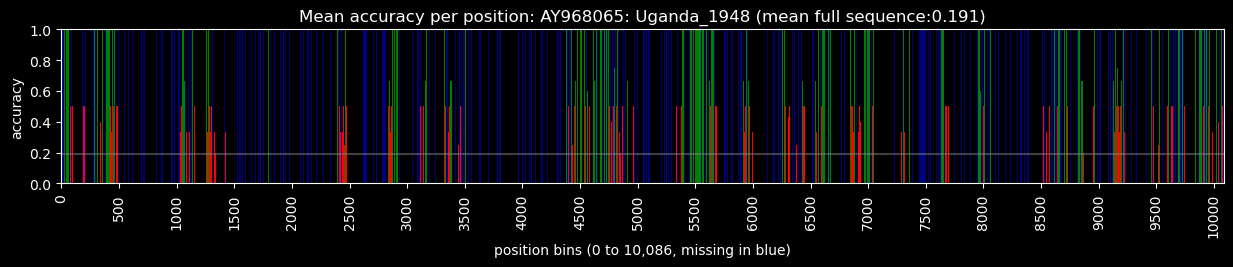

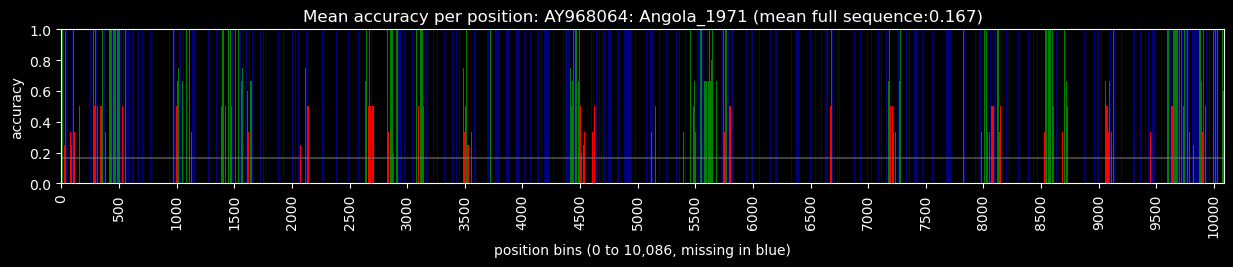

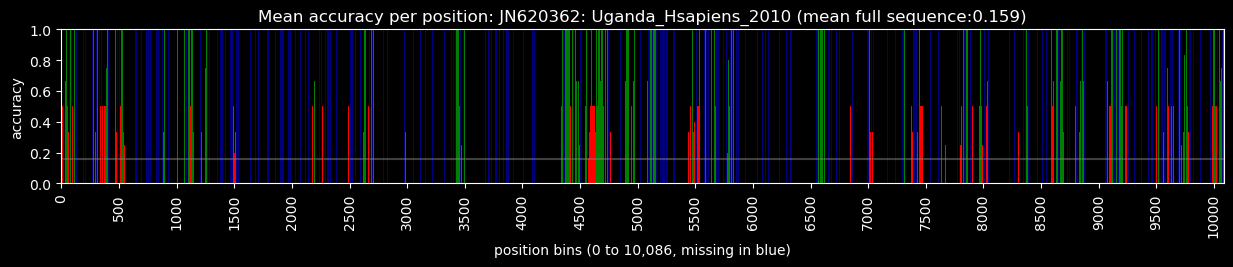

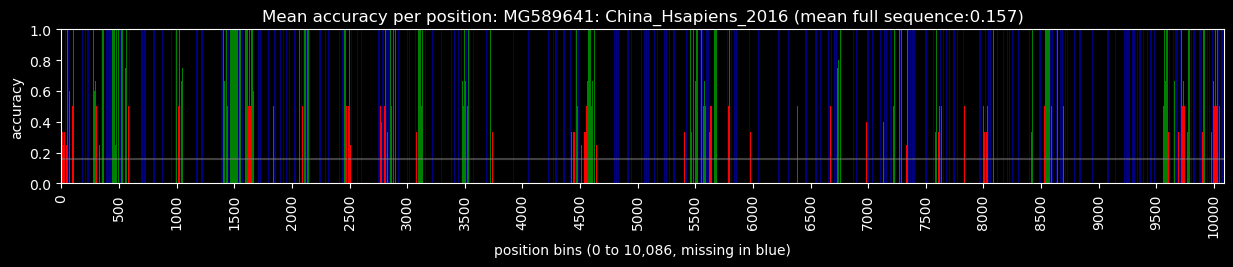

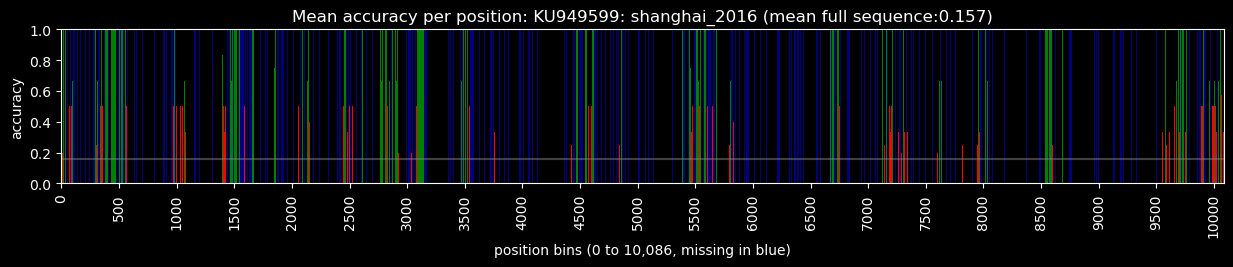

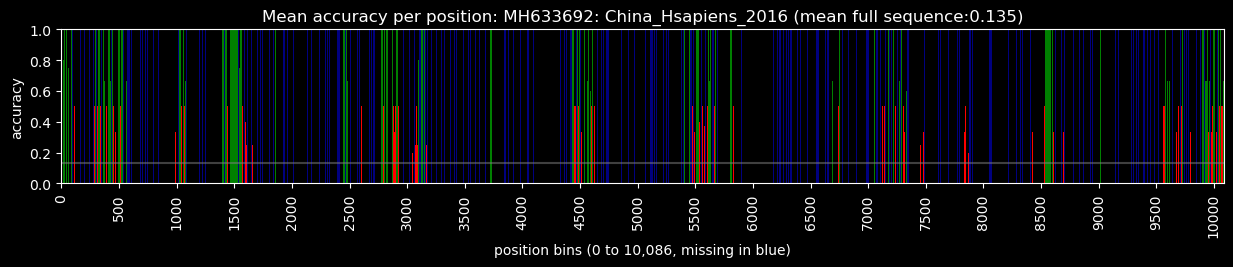

In [204]:
for idx in ordered_index:
    plot_accuracy_per_position(df, idx, figsize=(15,2), ax=None)

## Analysis of Label Probabilities

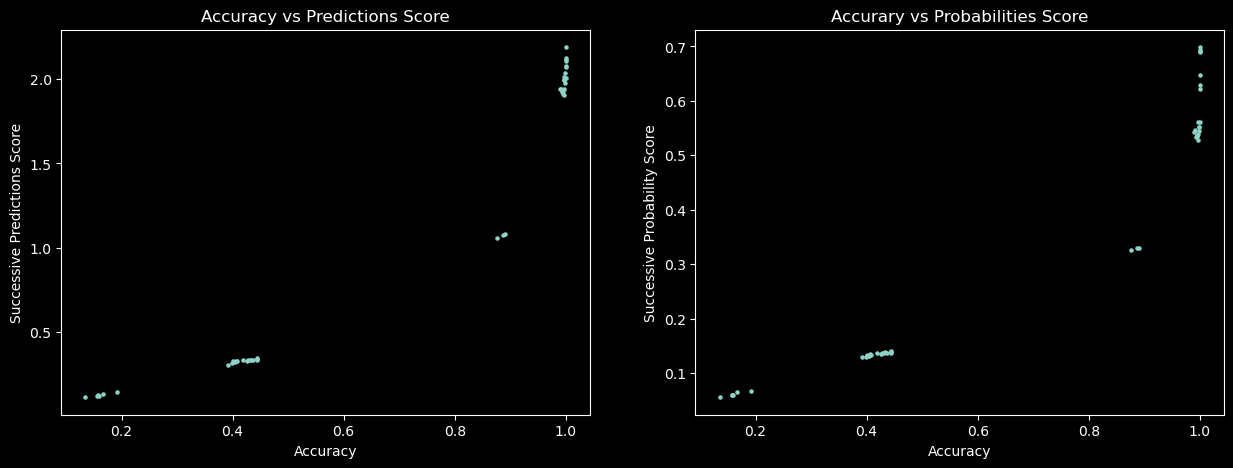

In [215]:
coi = ['preds_score','probs_score','accuracy']
grouped = df.groupby(by='refseqid')[coi].mean().loc[ordered_index, :]
grouped.index = ordered_distance_index

n = 5
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3 * n, n))
# ax1.scatter(x=grouped['accuracy'], y=np.log(grouped['preds_score']), s=5)
ax1.scatter(x=grouped['accuracy'], y=grouped['preds_score'], s=5)
ax1.set_title('Accuracy vs Predictions Score')
ax1.set_xlabel('Accuracy')
# ax1.set_ylabel('Successive Predictions Score (log)')
ax1.set_ylabel('Successive Predictions Score')
# ax2.scatter(x=grouped['accuracy'], y=np.log(grouped['probs_score']),s=5)
ax2.scatter(x=grouped['accuracy'], y=grouped['probs_score'],s=5)
ax2.set_title('Accurary vs Probabilities Score');
ax2.set_xlabel('Accuracy')
# ax2.set_ylabel('Successive Probability Score (log)');
ax2.set_ylabel('Successive Probability Score');

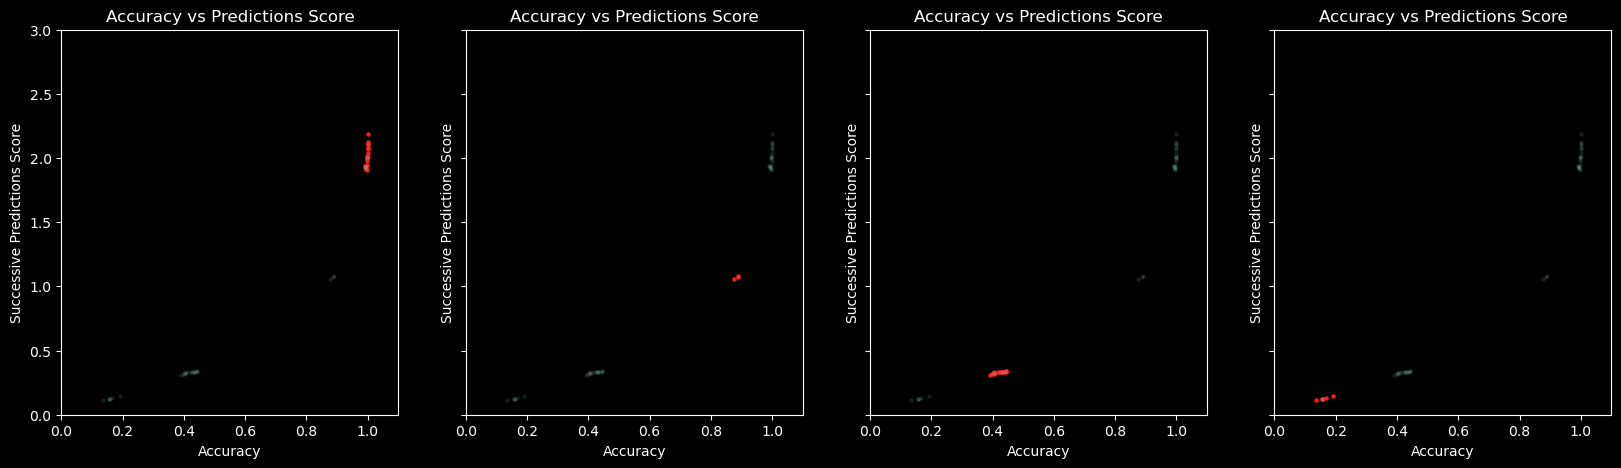

In [266]:
def plot_cluster(ax, cluster, df):
    ax.scatter(x=cluster['accuracy'], y=cluster['preds_score'], s=5, c='red')
    ax.scatter(x=df['accuracy'], y=df['preds_score'], s=5, alpha=0.1)
    ax.set_title('Accuracy vs Predictions Score')
    ax.set_xlim((0,1.1))
    ax.set_ylim((0,3))
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Successive Predictions Score')

top_right = grouped.loc[grouped.preds_score > 1.5, :].loc[grouped.accuracy > 0.8, :]
top_middle = grouped.loc[grouped.preds_score < 1.5, :].loc[grouped.accuracy > 0.6, :]
bottom_middle = grouped.loc[grouped.preds_score < 1, :].loc[grouped.accuracy > 0.3, :]
bottom_left = grouped.loc[grouped.preds_score < 0.5, :].loc[grouped.accuracy < 0.3, :]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4* n, n), sharey=True)
for ax,df in zip(axs.flatten(), [top_right, top_middle, bottom_middle, bottom_left]):
    plot_cluster(ax, df, grouped)

plt.show()

In [267]:
print(f"{'Cluster Top Right:':<40s}{'Preds Score':^10s}{'Distance':^10s}{'Accuracy':^10s}")
for idx, row in top_right.iterrows():
    print(f" - {idx:40s}  {row['preds_score']:.2f}       {distances.loc[idx]:.2f}    {row['accuracy']:.3f}")

Cluster Top Right:                      Preds Score Distance  Accuracy 
 - U21056_senegal_1927                       2.10       0.00    1.000
 - GQ379163_Peru_2007                        2.07       0.01    1.000
 - MF289572_Singapore_2017                   2.01       0.01    1.000
 - KU978764_Sudan_1941                       2.08       0.00    1.000
 - ON323054_Nigeria_2020                     2.19       0.01    1.000
 - ON323053_Nigeria_2020                     2.11       0.02    1.000
 - ON323052_Nigeria_2020                     2.12       0.02    1.000
 - JX898876_Senegal_2001                     2.04       0.04    0.999
 - OM066737_ghana_Damongo_2021               1.98       0.08    0.999
 - JX898878_ArD181250_Senegal_2005           2.00       0.04    0.998
 - JX898877_ArD181464_Senegal_2005           2.00       0.04    0.998
 - KU978765_GuineaBissau_1965                2.01       0.04    0.997
 - AY572535_Gambia_2001                      1.94       0.05    0.996
 - MK292067_Nether

In [268]:
print(f"{'Cluster Top Middle:':<40s}{'Preds Score':^10s}{'Distance':^10s}{'Accuracy':^10s}")
for idx, row in top_middle.iterrows():
    print(f" - {idx:40s}  {row['preds_score']:.2f}       {distances.loc[idx]:.2f}    {row['accuracy']:.3f}")

Cluster Top Middle:                     Preds Score Distance  Accuracy 
 - KU978763_Nigeria_1946                     1.08       0.09    0.890
 - JX898869_Cote_Ivoire_1973                 1.07       0.09    0.887
 - U54798_Ivory_Coast_1982                   1.06       0.10    0.876


In [269]:
print(f"{'Cluster Bottom Middle:':<40s}{'Preds Score':^10s}{'Distance':^10s}{'Accuracy':^10s}")
for idx, row in bottom_middle.iterrows():
    print(f" - {idx:40s}  {row['preds_score']:.2f}       {distances.loc[idx]:.2f}    {row['accuracy']:.3f}")

Cluster Bottom Middle:                  Preds Score Distance  Accuracy 
 - JF912190_Brazil_2002                      0.34       0.15    0.444
 - MF004382_Bolivia_1999                     0.33       0.14    0.444
 - JF912188_Brazil_2000                      0.34       0.15    0.444
 - JF912181_Brazil_1983                      0.33       0.15    0.436
 - HM582851_TrinidadandTobago_2009           0.33       0.15    0.433
 - KM388814_Venezuela_Portuguesa_2005        0.34       0.15    0.432
 - MH666058_Brazil_2016                      0.33       0.15    0.427
 - KM388815_Venezuela_Apure_2007             0.33       0.15    0.425
 - KM388818_Venezuela_2006                   0.34       0.15    0.418
 - MF370549_Brazil_2015                      0.33       0.15    0.408
 - MK333805_Brazil_IlhaGrande_2018           0.33       0.15    0.405
 - MK760660_Netherlands_2018                 0.32       0.15    0.404
 - JF912182_Brazil_1984                      0.33       0.15    0.401
 - MK583152_Brazil

In [270]:
print(f"{'Cluster Bottom Left:':<40s}{'Preds Score':^10s}{'Distance':^10s}{'Accuracy':^10s}")
for idx, row in bottom_left.iterrows():
    print(f" - {idx:40s}  {row['preds_score']:.2f}       {distances.loc[idx]:.2f}    {row['accuracy']:.3f}")

Cluster Bottom Left:                    Preds Score Distance  Accuracy 
 - AY968065_Uganda_1948                      0.14       0.18    0.191
 - AY968064_angola_1971                      0.13       0.18    0.167
 - JN620362_Uganda_2010                      0.12       0.18    0.159
 - MG589641_china_2016                       0.13       0.18    0.157
 - KU949599_shanghai_2016                    0.12       0.18    0.157
 - MH633692_China_2016                       0.11       0.18    0.135


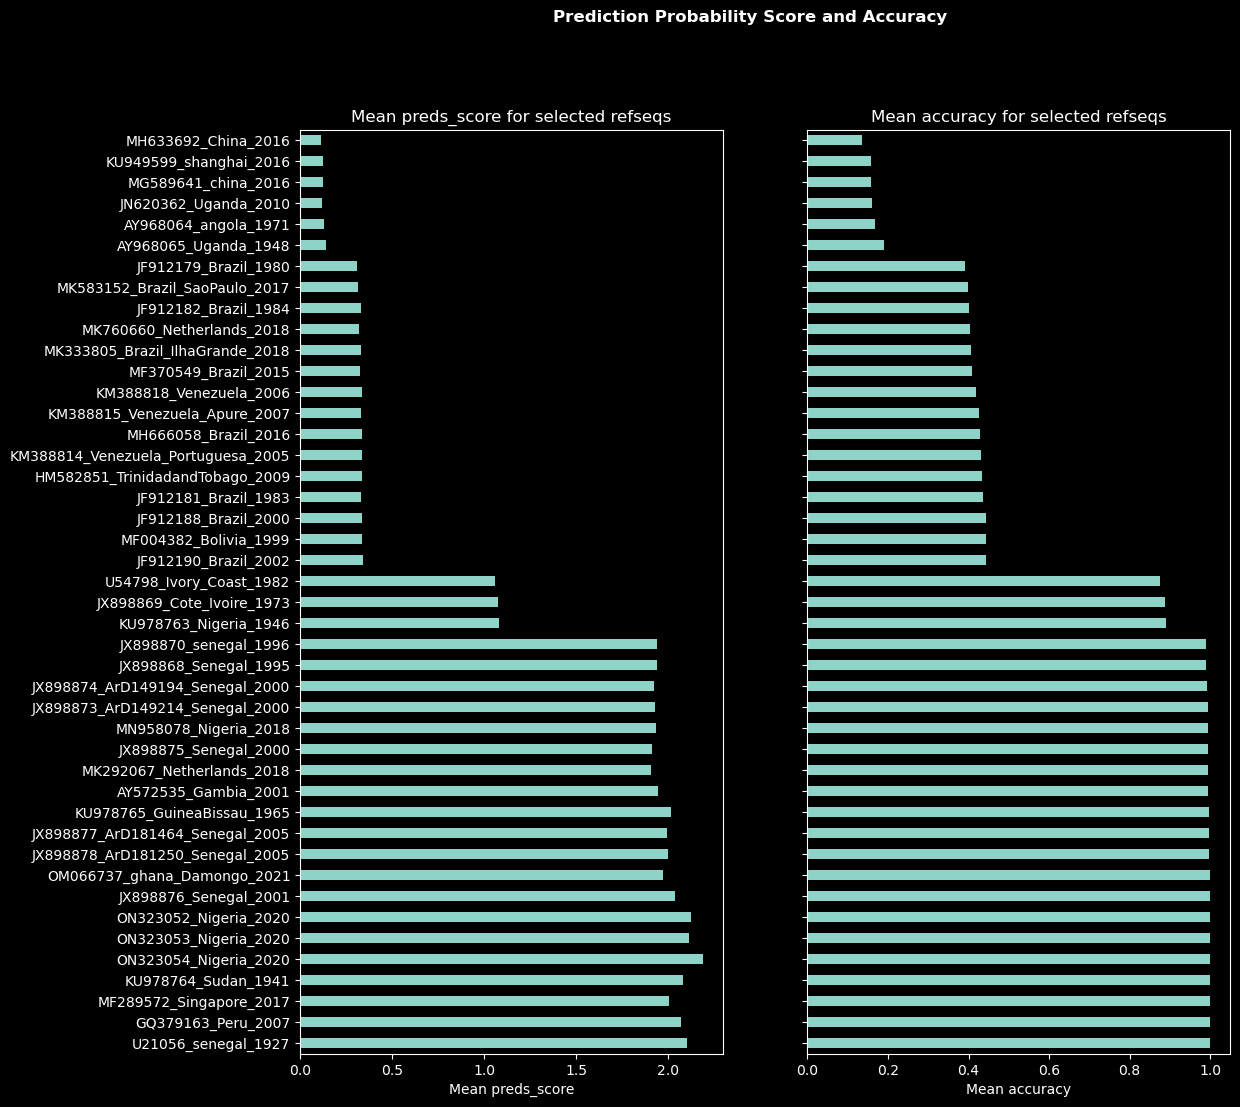

In [271]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12, 12), sharey=True)
fig.suptitle('Prediction Probability Score and Accuracy', fontweight='bold')
grouped.preds_score.plot(ax=ax1, kind='barh', title='Mean preds_score for selected refseqs');
ax1.set_xlabel('Mean preds_score')

grouped.accuracy.plot(ax=ax2, kind='barh',  title='Mean accuracy for selected refseqs');
ax2.set_xlabel('Mean accuracy');

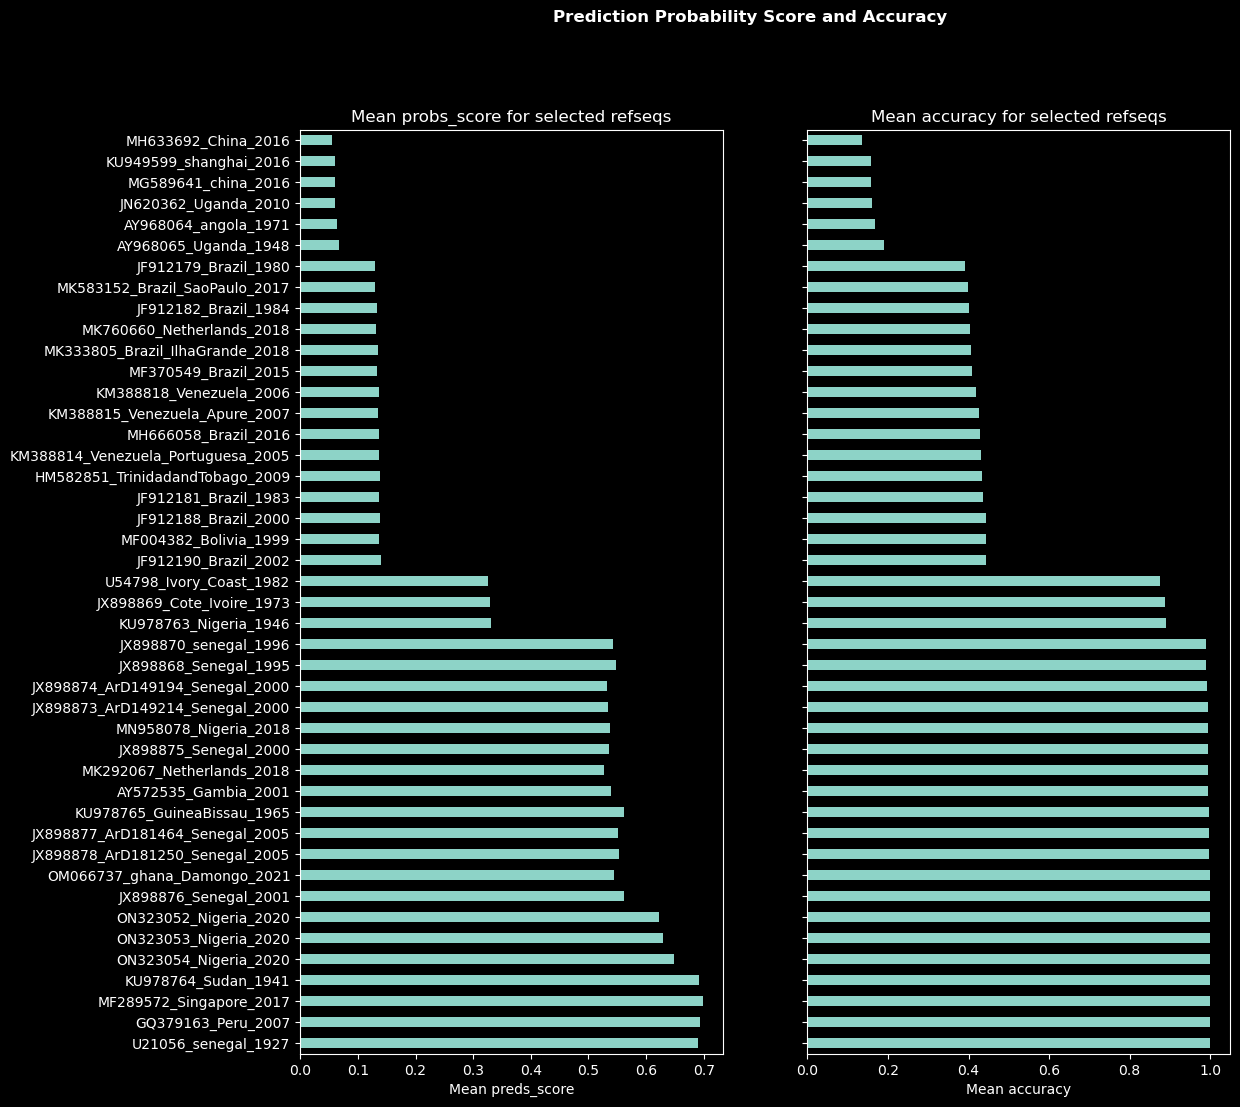

In [272]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12, 12), sharey=True)
fig.suptitle('Prediction Probability Score and Accuracy', fontweight='bold')
grouped.probs_score.plot(ax=ax1, kind='barh', title='Mean probs_score for selected refseqs');
ax1.set_xlabel('Mean preds_score')

grouped.accuracy.plot(ax=ax2, kind='barh',  title='Mean accuracy for selected refseqs');
ax2.set_xlabel('Mean accuracy');

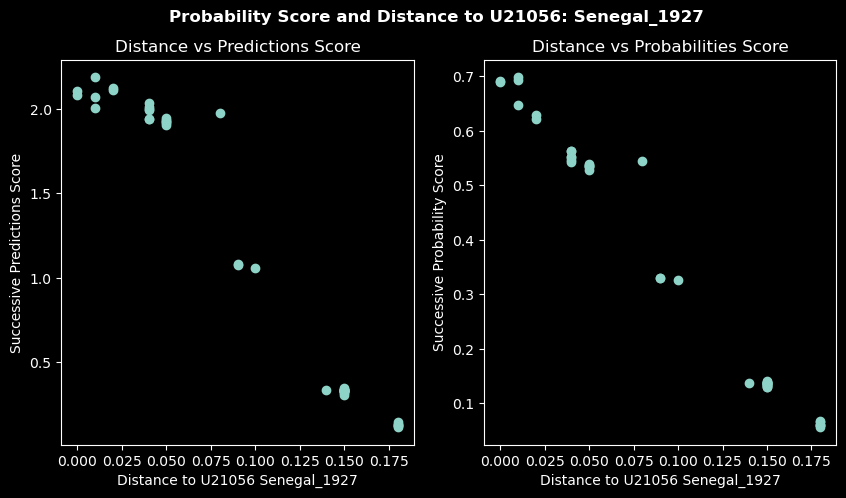

In [273]:
n = 5
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2 * n, n))
fig.suptitle('Probability Score and Distance to U21056: Senegal_1927', fontweight='bold')

ax1.scatter(x=distances.loc[ordered_distance_index], y=grouped['preds_score']);
ax1.set_title('Distance vs Predictions Score')
ax1.set_xlabel('Distance to U21056 Senegal_1927')
ax1.set_ylabel('Successive Predictions Score')

ax2.scatter(x=distances.loc[ordered_distance_index], y=grouped['probs_score']);
ax2.set_title('Distance vs Probabilities Score')
ax2.set_xlabel('Distance to U21056 Senegal_1927')
ax2.set_ylabel('Successive Probability Score');


## Probability per position

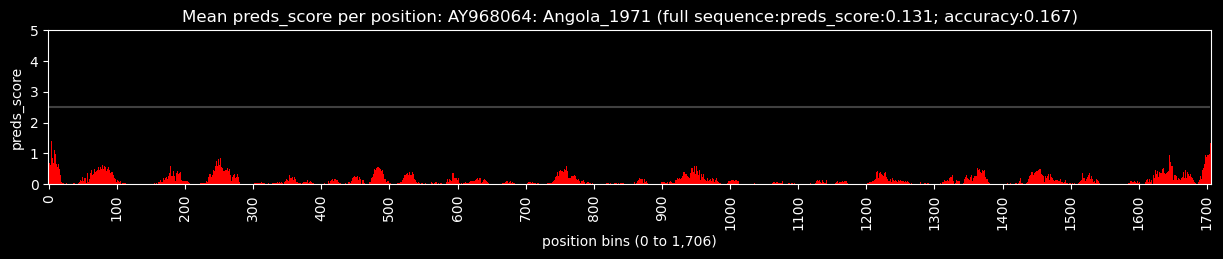

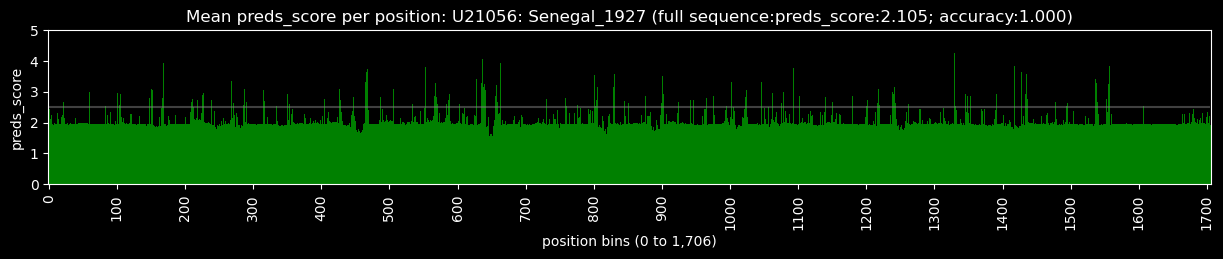

In [36]:
def plot_probs_per_position(df: pd.DataFrame, refseqid:str, metric='preds_score', figsize=(15,3), ax=None, dense=False):
    df_ = df.loc[df['refseqid'] == refseqid, :]
    n_position_bins = df_.bin.max()
    info = df_refseqs.loc[refseqid,'info']
    accuracy = df_refseqs.loc[refseqid,'mean acc']
    score = df_[metric].mean()
    score_per_bin = df_.groupby('bin')[metric].mean()

    if ax is None: 
        fig,ax = plt.subplots(figsize=figsize)
        show_this_axis = True
    else:
        show_this_axis = False

    bar_w = 1 if dense else .6
    if metric == 'preds_score':
        colors = score_per_bin.apply(lambda x: 'red' if x < 1.5 else 'green')
        ylim = (0,5)
    elif metric == 'probs_score':
        colors = score_per_bin.apply(lambda x: 'red' if x < 0.3 else 'green')
        ylim = (0,1)
    else:
        colors = 'green'
    # print(score_per_bin.min(), score_per_bin.max())
    score_per_bin.plot(ax=ax, kind='bar', ylim=ylim, width=bar_w, color=colors, legend=False)
    ax.set_title(f"Mean {metric} per position: {info} (full sequence:{metric}:{score:.3f}; accuracy:{accuracy:.3f})")
    if dense:
        ax.hlines(y=2.5, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid', alpha=0.5)
    else:
        ax.hlines(y=0.6, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.7, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.8, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.9, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
    ax.set_xlabel(f"position bins (0 to {nb_bins:,d})")
    ax.set_ylabel(metric)
    ax.set_xticks(range(0,n_position_bins,100))

    if show_this_axis: plt.show()

plot_probs_per_position(df, '11089:ncbi:1',figsize=(15,2), dense=True, ax=None)
plot_probs_per_position(df, '11089:ncbi:6',figsize=(15,2), dense=True, ax=None)

In [34]:
# for idx in ordered_index:
#     plot_probs_per_position(df, idx, figsize=(15,2), dense=True, ax=None)

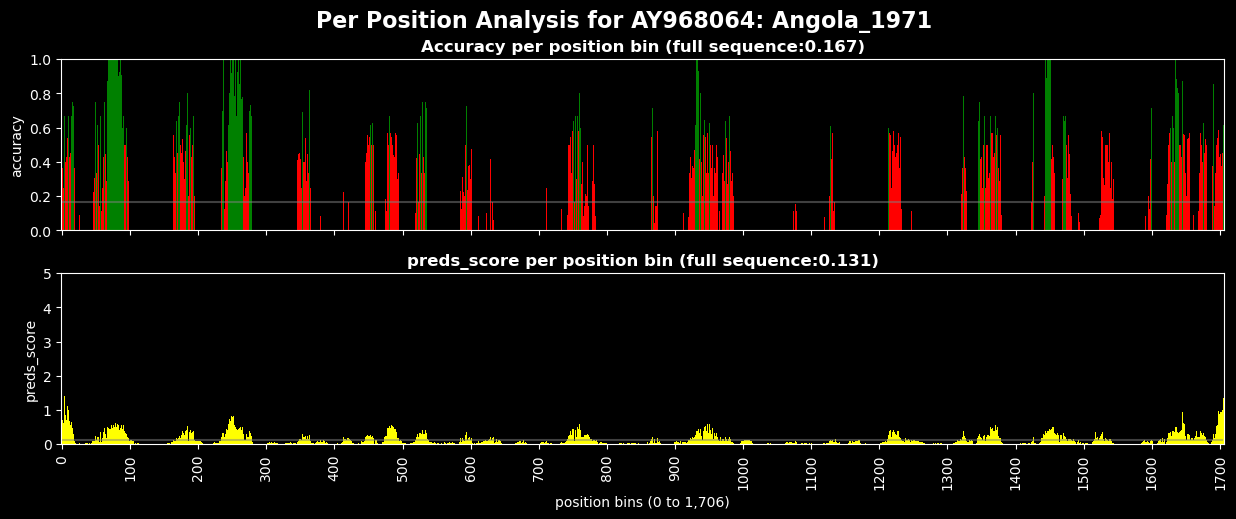

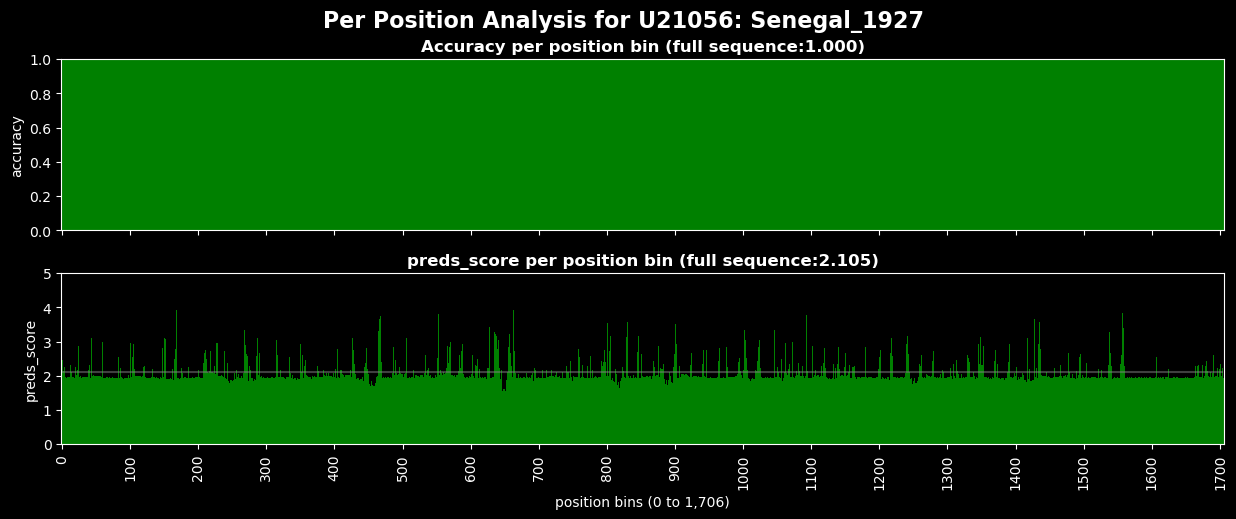

In [42]:
def plot_analysis_per_position(df: pd.DataFrame, refseqid:str, metric='preds_score', figsize=(15,2*2+1)):
    df_ = df.loc[df['refseqid'] == refseqid, :]
    n_position_bins = df_.bin.max()
    info = df_refseqs.loc[refseqid,'info']

    accuracy = df_refseqs.loc[refseqid,'mean acc']
    acc_per_bin = df_.groupby('bin')['accuracy'].mean()
    score = df_[metric].mean()
    score_per_bin = df_.groupby('bin')[metric].mean()

    fig,(ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True)
    fig.suptitle(f"Per Position Analysis for {info}", fontsize=16,fontweight='bold')

    # Plot Accuracy
    bar_w = 1
    colors_acc = acc_per_bin.apply(lambda x: 'red' if x < 0.6 else 'green')
    acc_per_bin.plot(ax=ax1, kind='bar', ylim=(0,1), width=bar_w, color=colors_acc, legend=False)
    ax1.set_title(f"Accuracy per position bin (full sequence:{accuracy:.3f})",fontweight='bold')
    ax1.hlines(y=accuracy, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid', alpha=0.5)
    ax1.set_xlabel(f"position bins (0 to {nb_bins:,d})")
    ax1.set_ylabel('accuracy')
    ax1.set_xticks(range(0,n_position_bins,100))

    # Plot scores 
    if metric == 'preds_score':
        colors_score = score_per_bin.apply(lambda x: 'yellow' if x < 1.5 else 'green')
        ylim = (0,5)
    elif metric_score == 'probs_score':
        colors = score_per_bin.apply(lambda x: 'yellow' if x < 0.3 else 'green')
        ylim = (0,1)
    else:
        colors_score = 'green'
        ylim = (0,5)

    score_per_bin.plot(ax=ax2, kind='bar', ylim=ylim, width=bar_w, color=colors_score, legend=False)
    ax2.set_title(f"{metric} per position bin (full sequence:{score:.3f})",fontweight='bold')
    ax2.hlines(y=score, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid', alpha=0.5)
    ax2.set_xlabel(f"position bins (0 to {nb_bins:,d})")
    ax2.set_ylabel(metric)
    ax2.set_xticks(range(0,n_position_bins,100))

    plt.subplots_adjust(hspace=.25)
    plt.show()

plot_analysis_per_position(df, '11089:ncbi:1')
plot_analysis_per_position(df, '11089:ncbi:6')

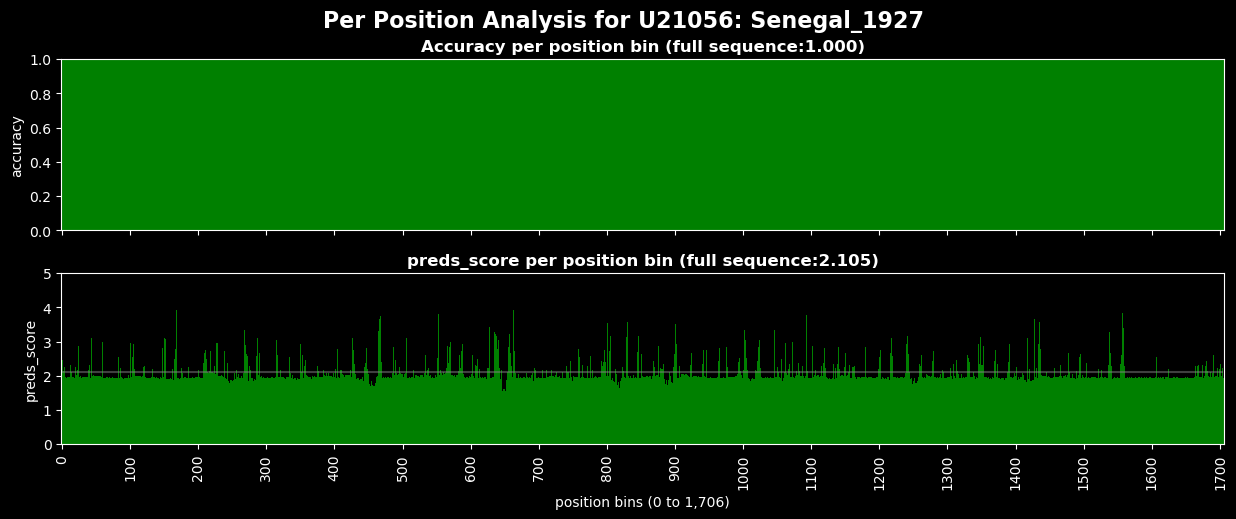

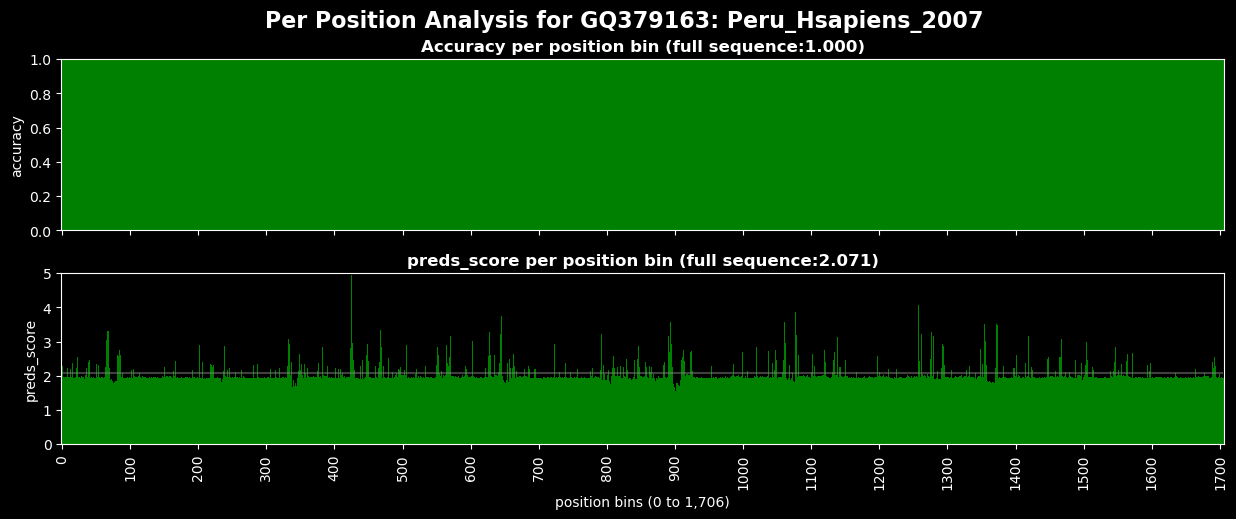

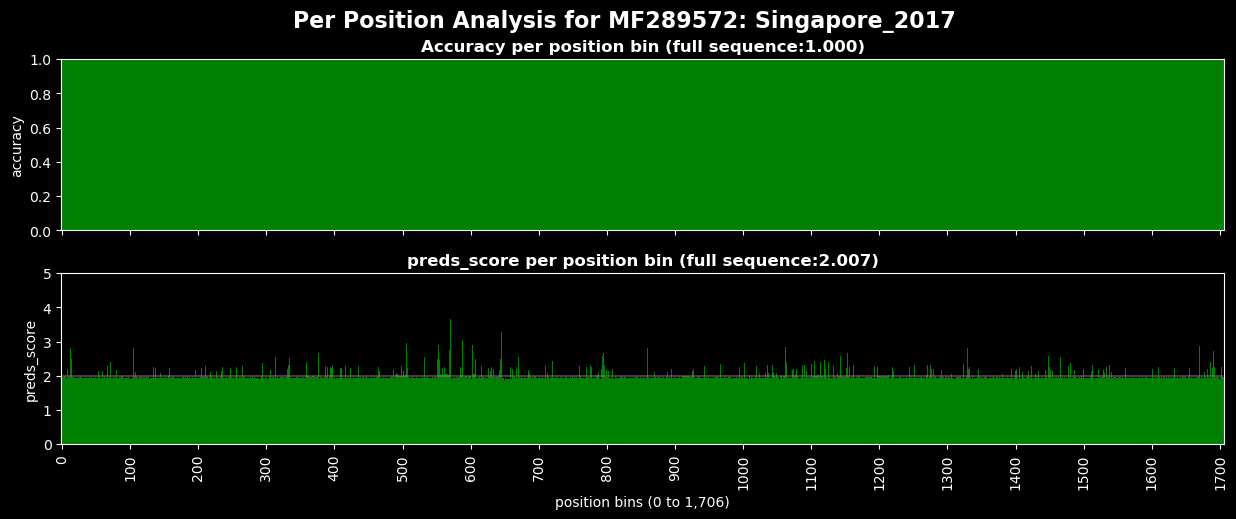

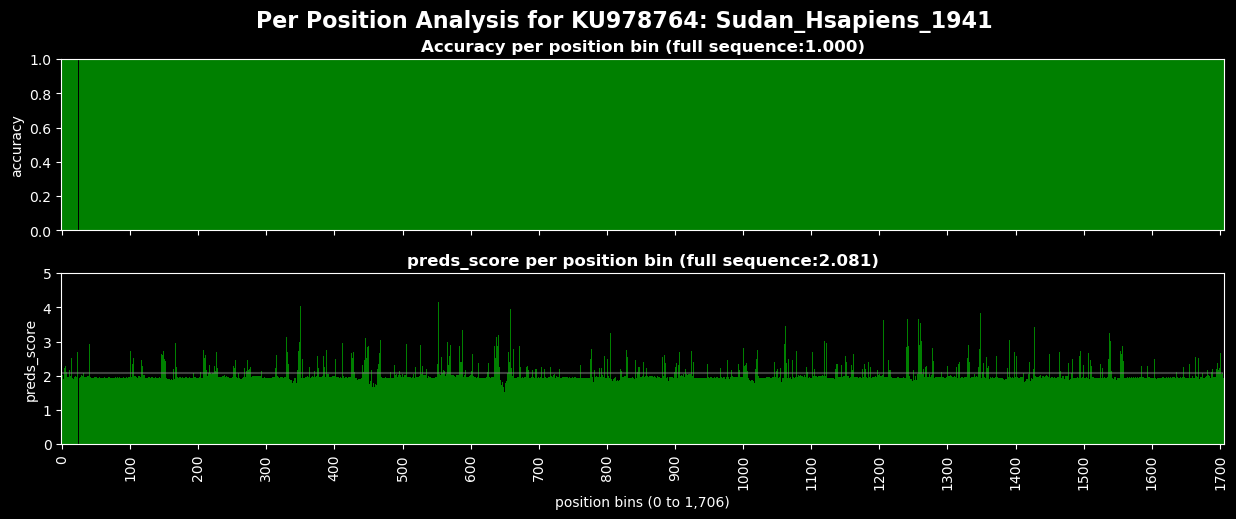

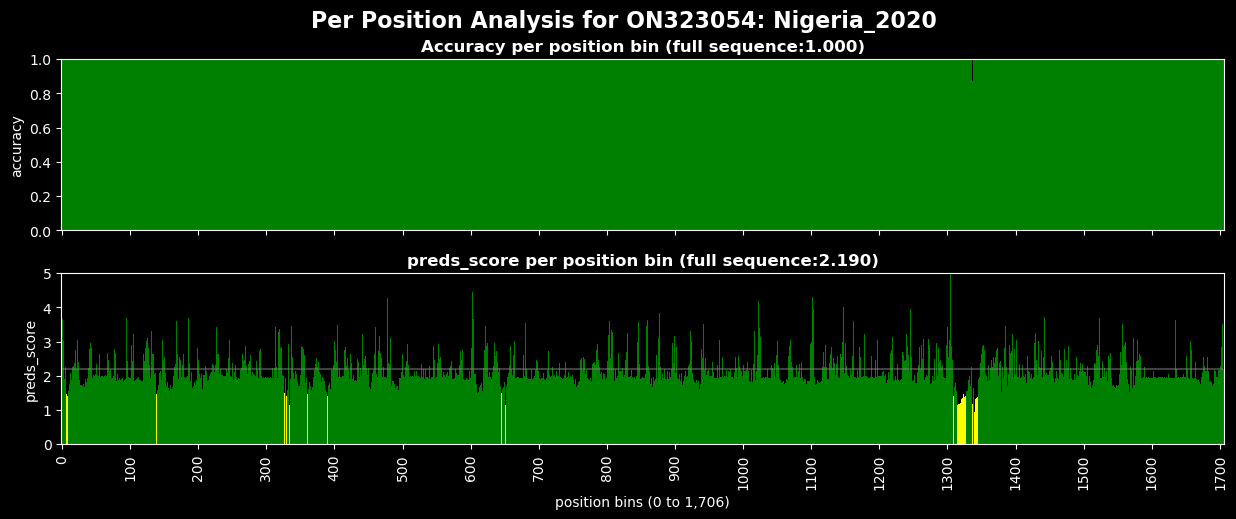

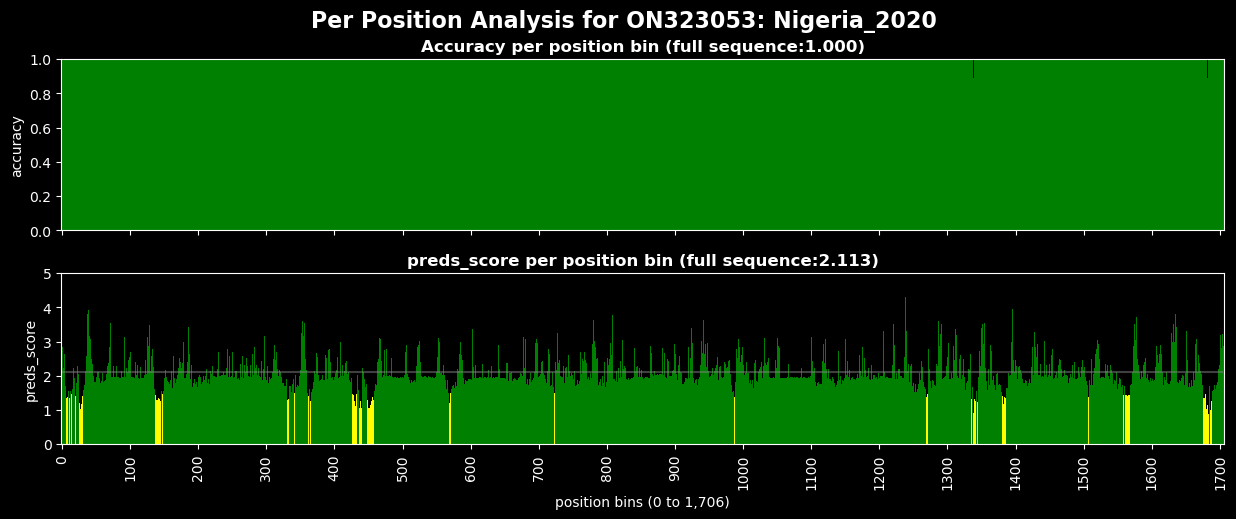

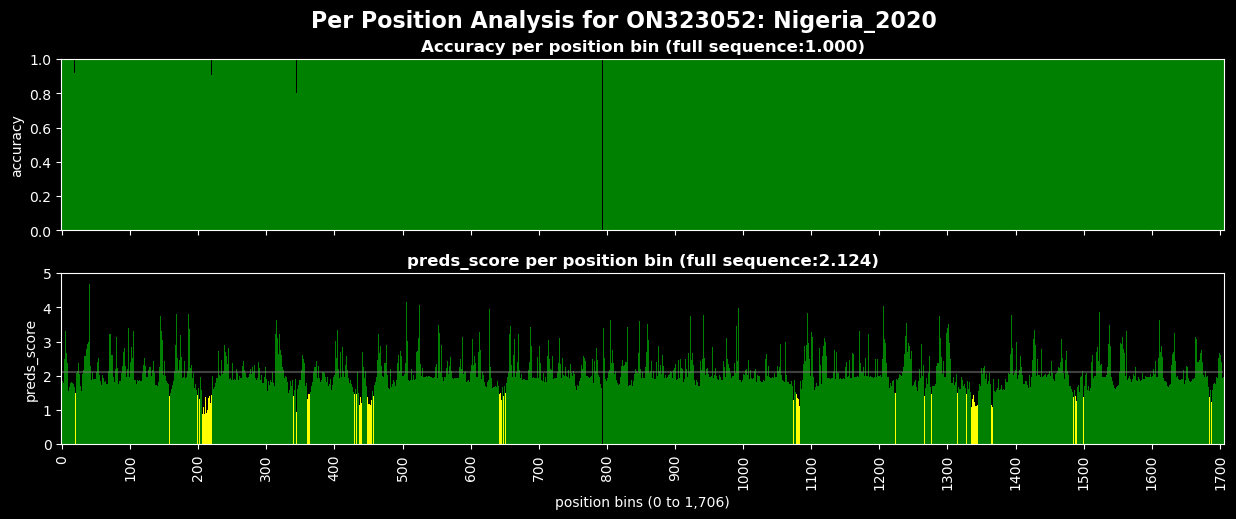

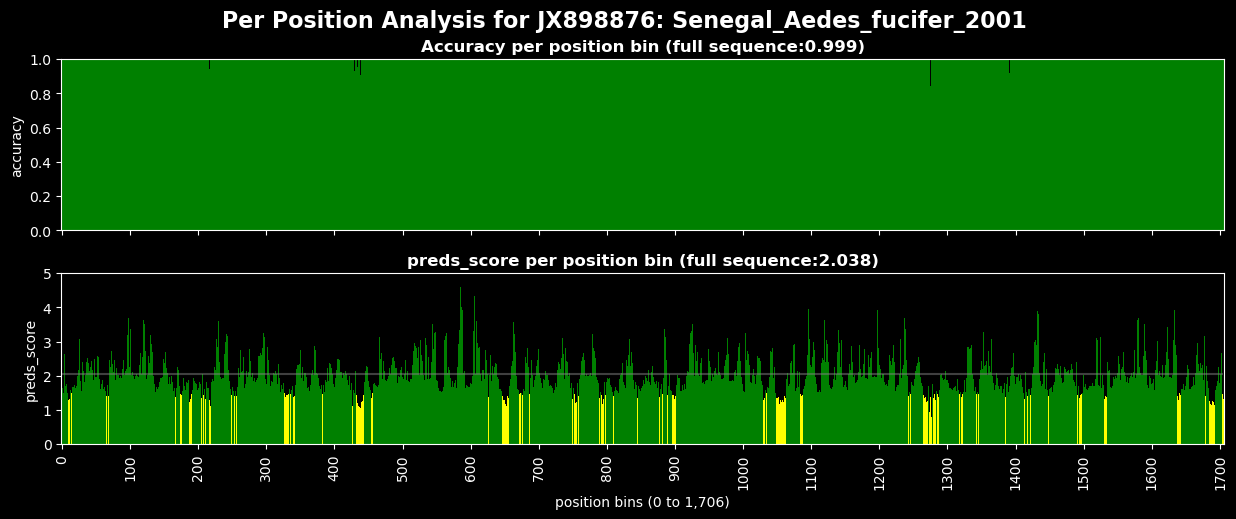

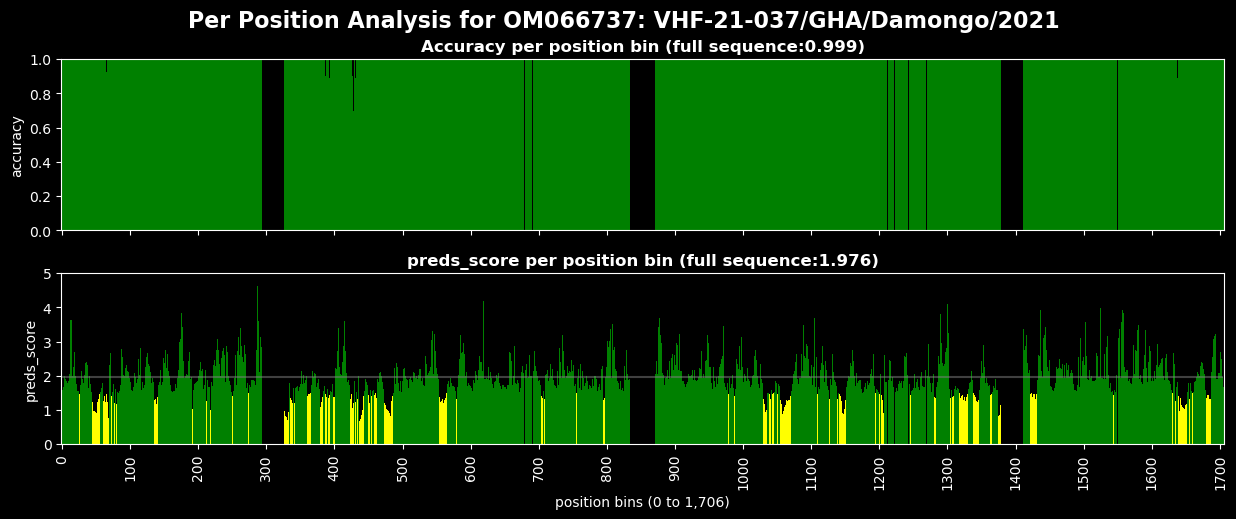

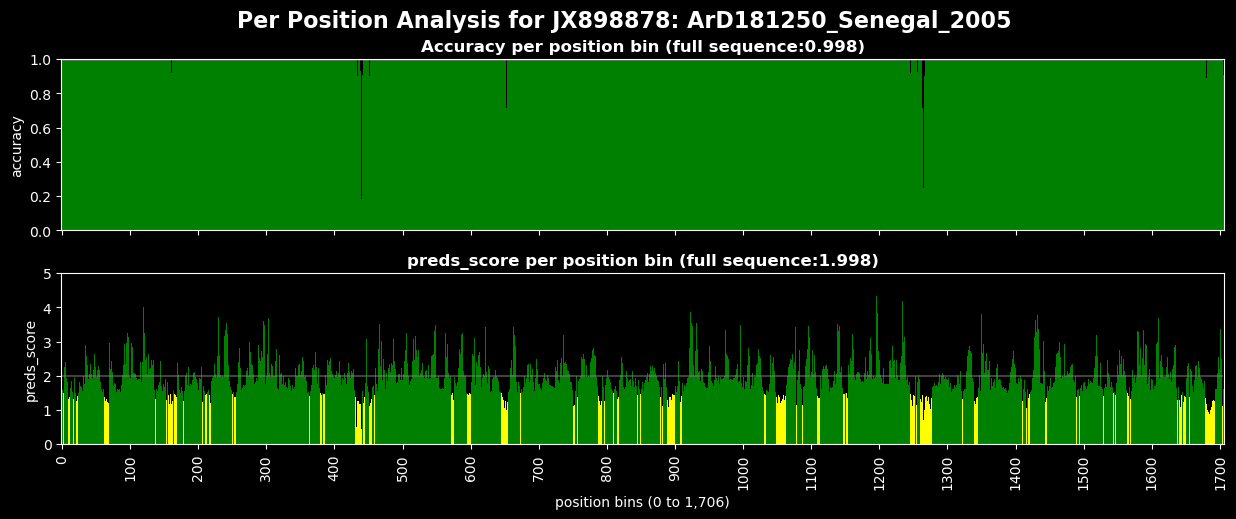

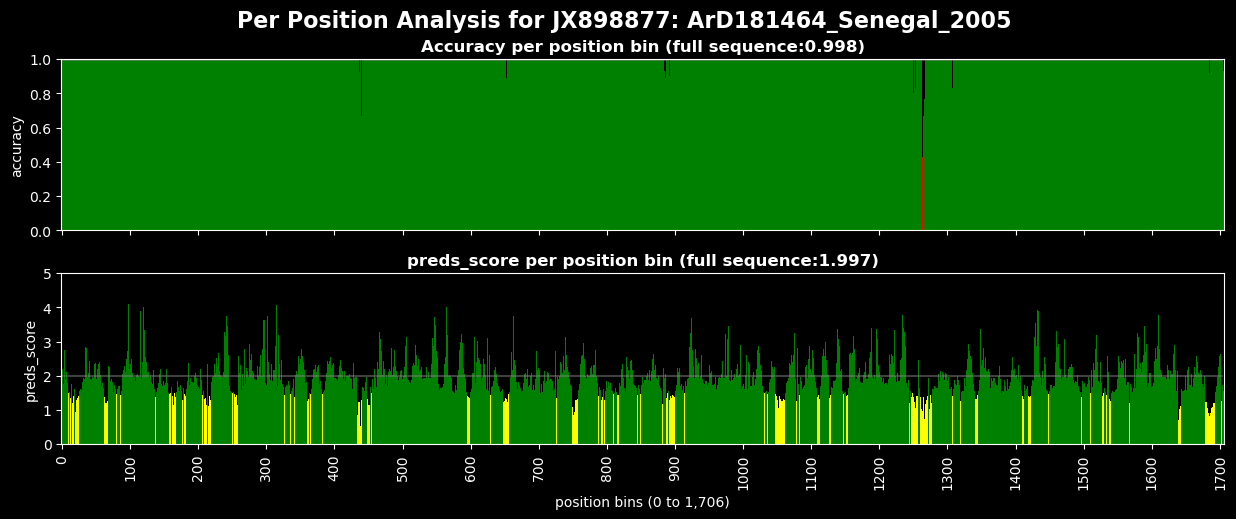

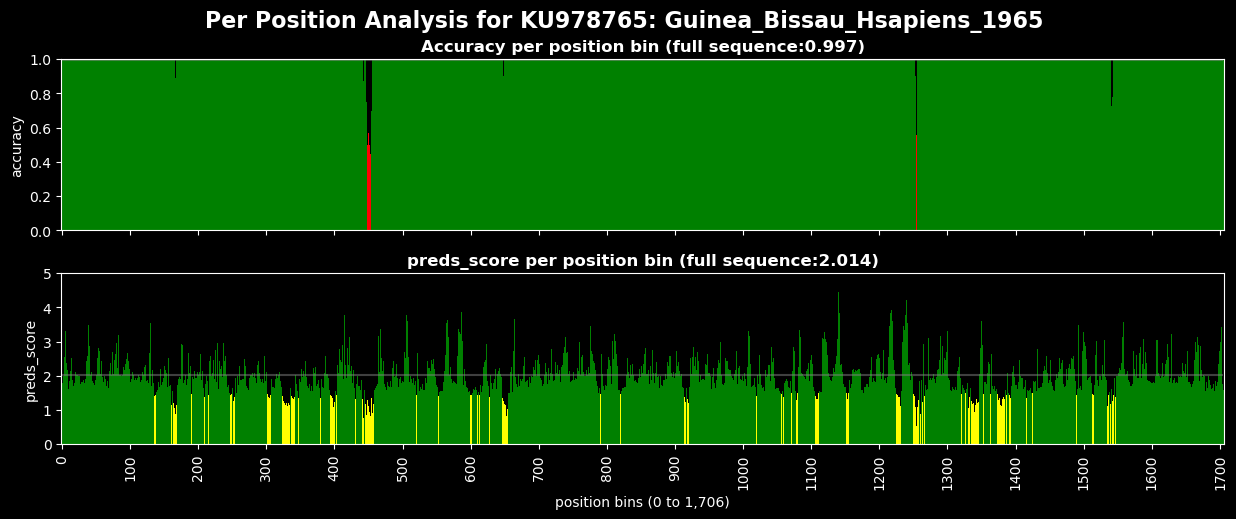

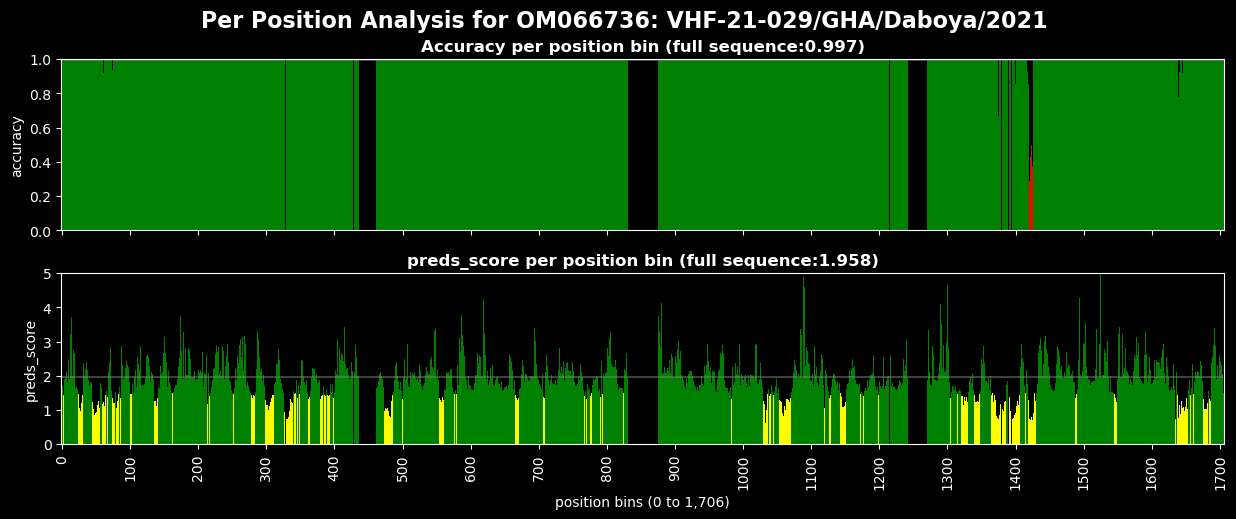

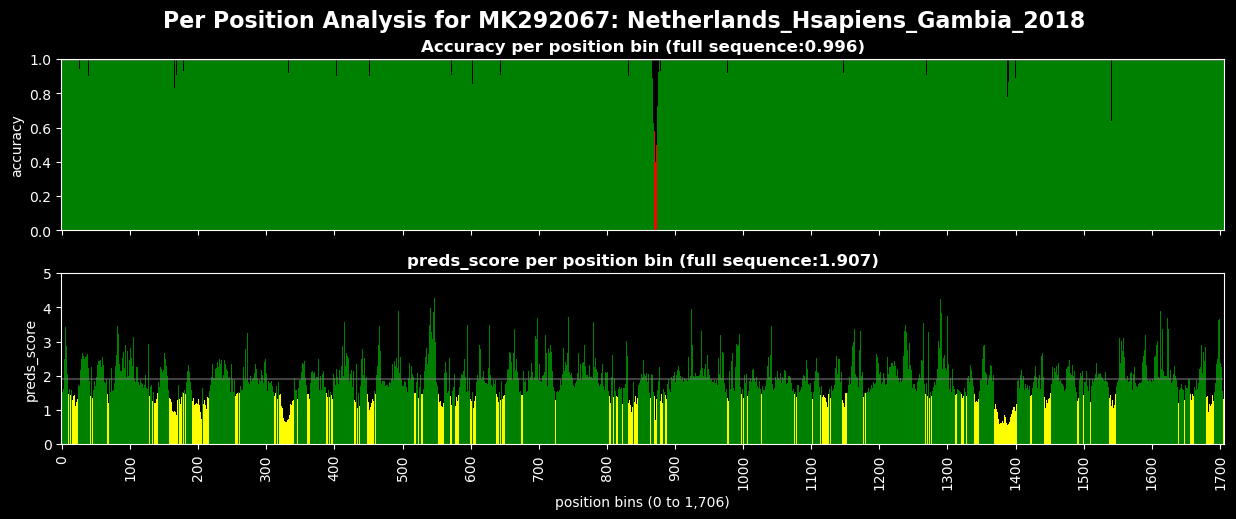

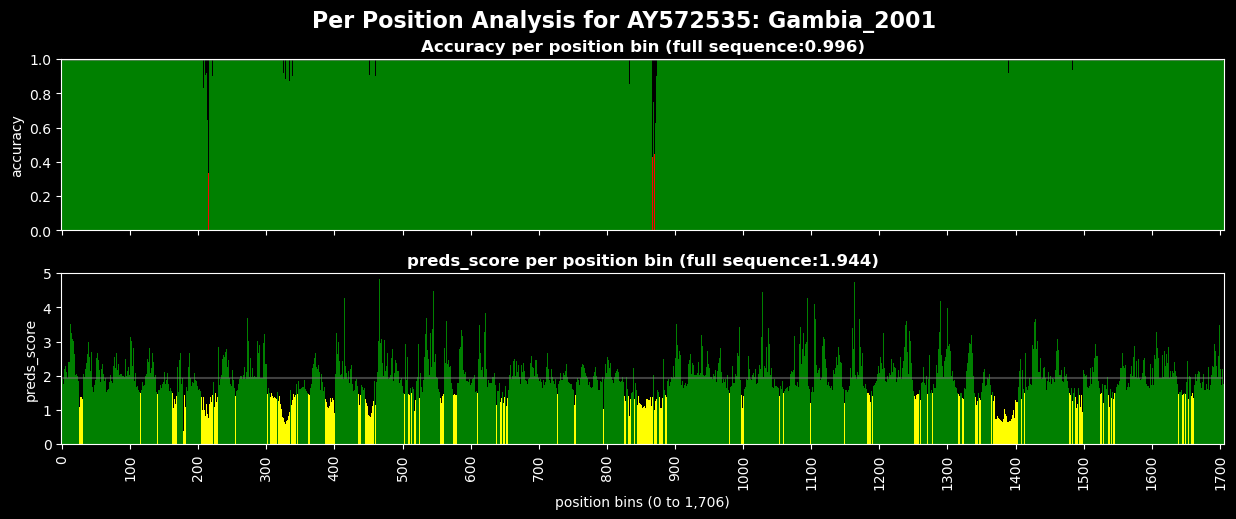

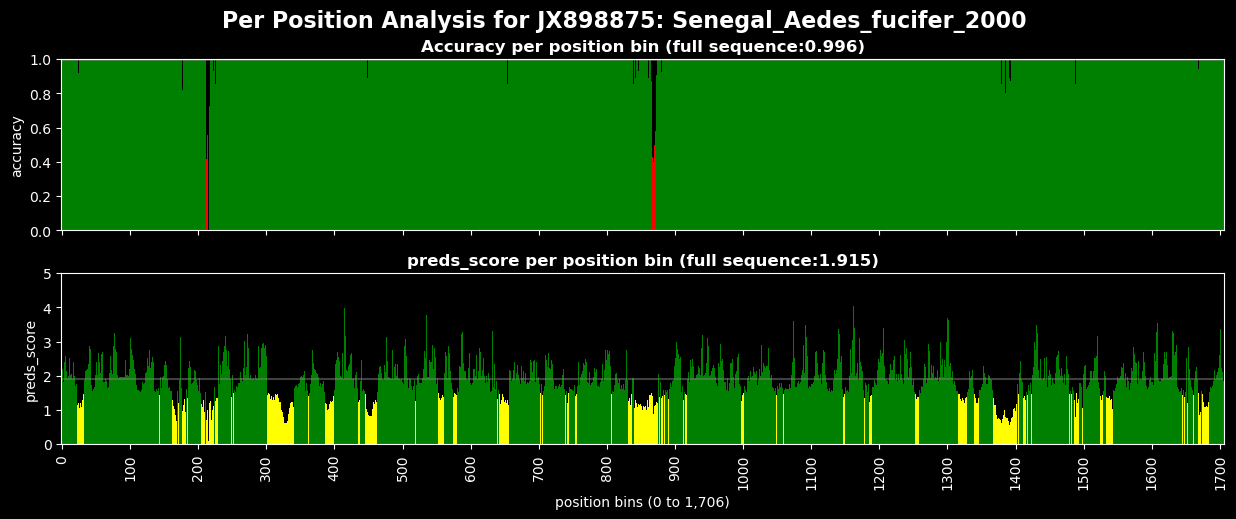

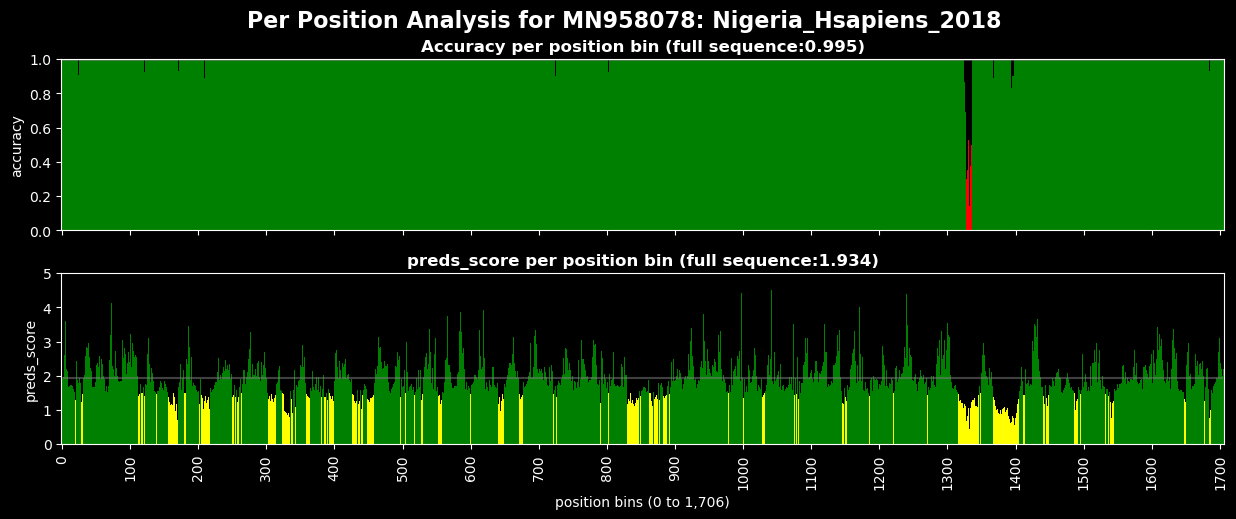

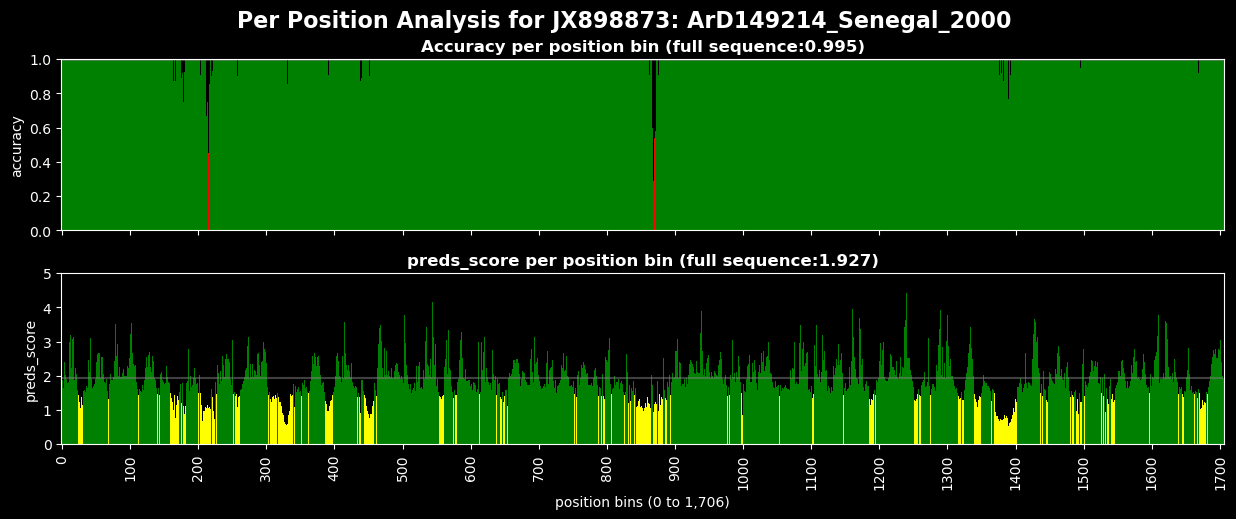

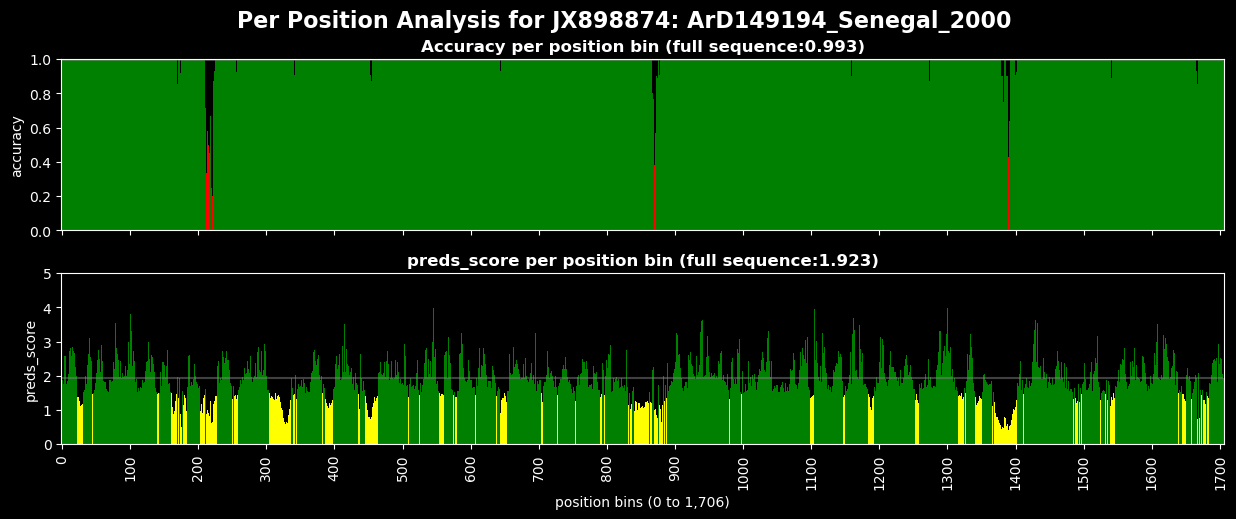

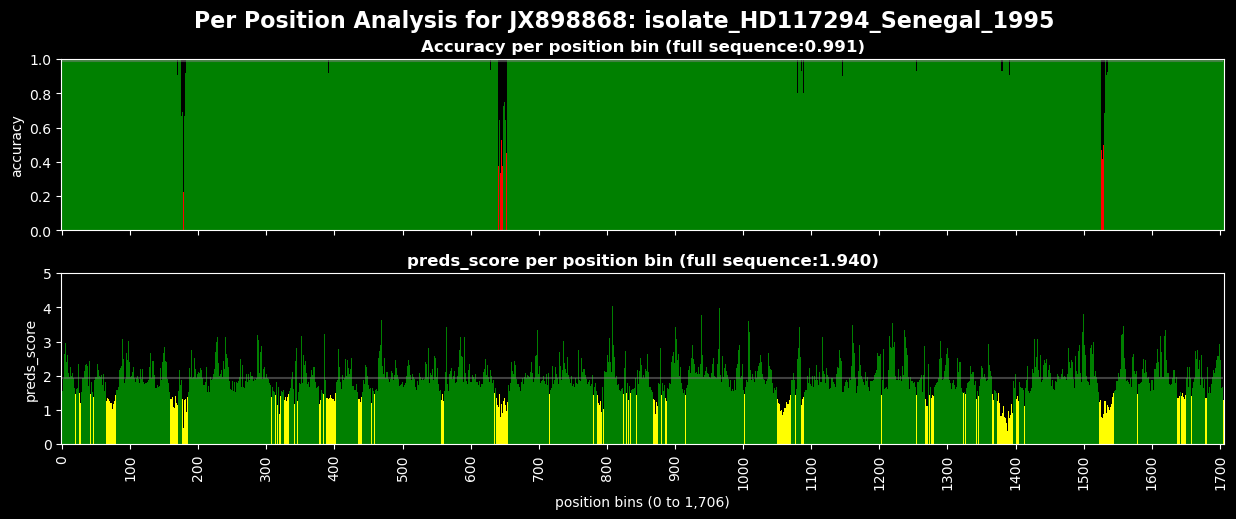

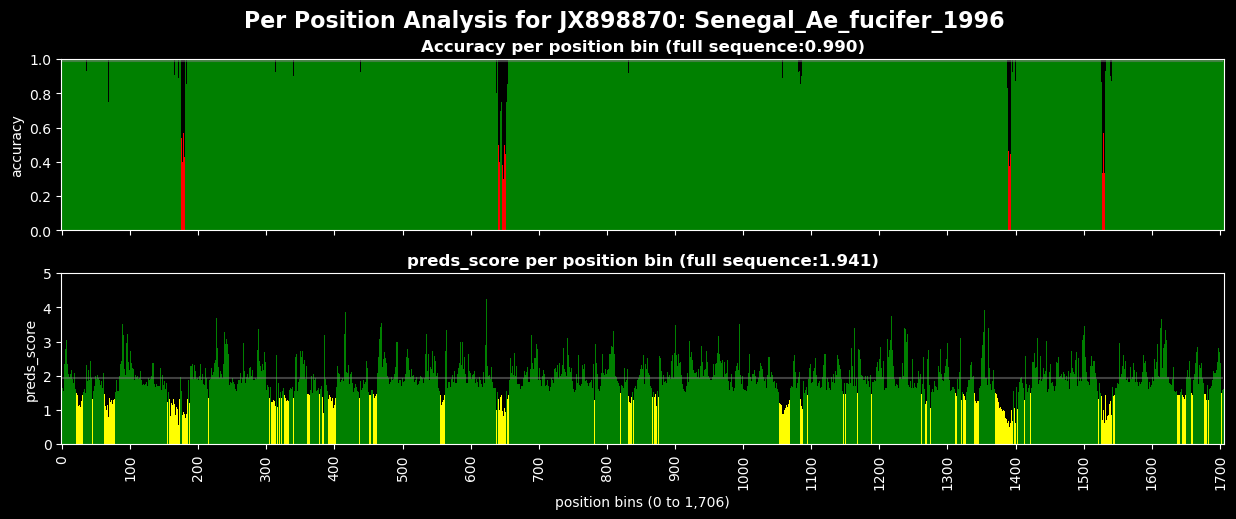

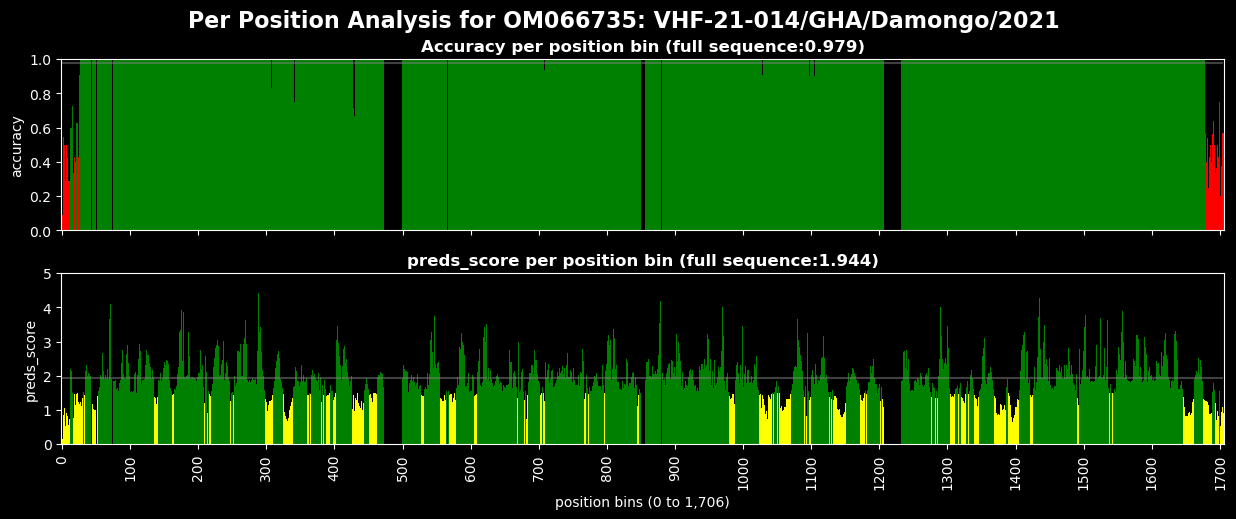

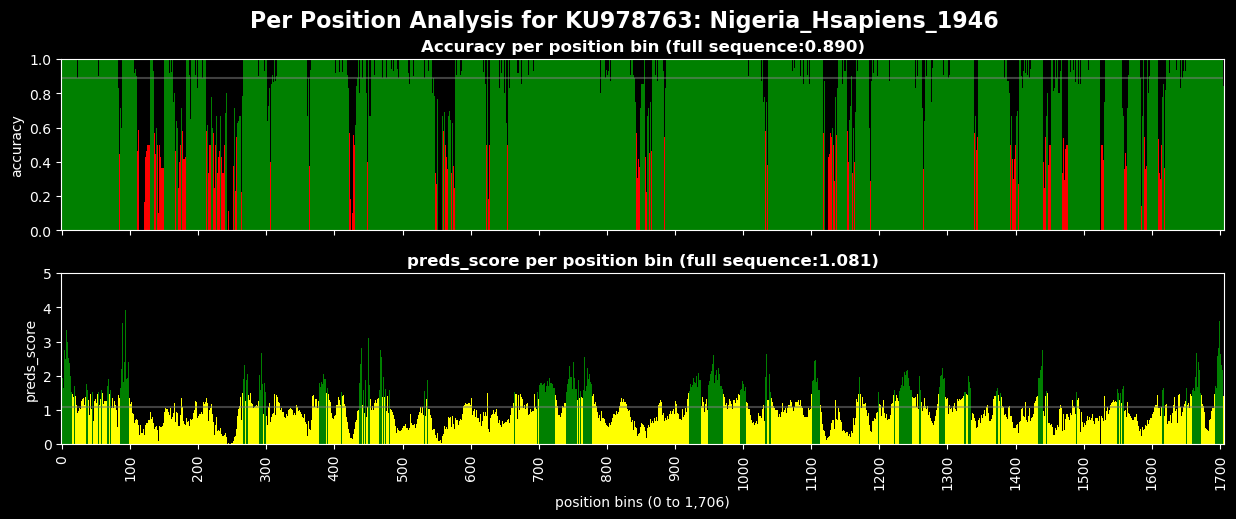

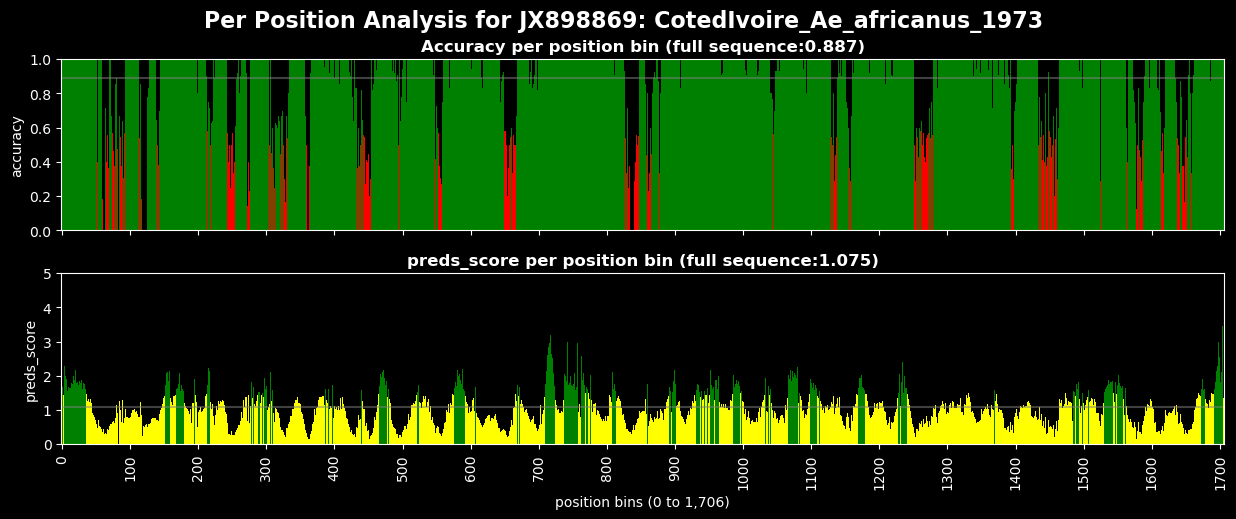

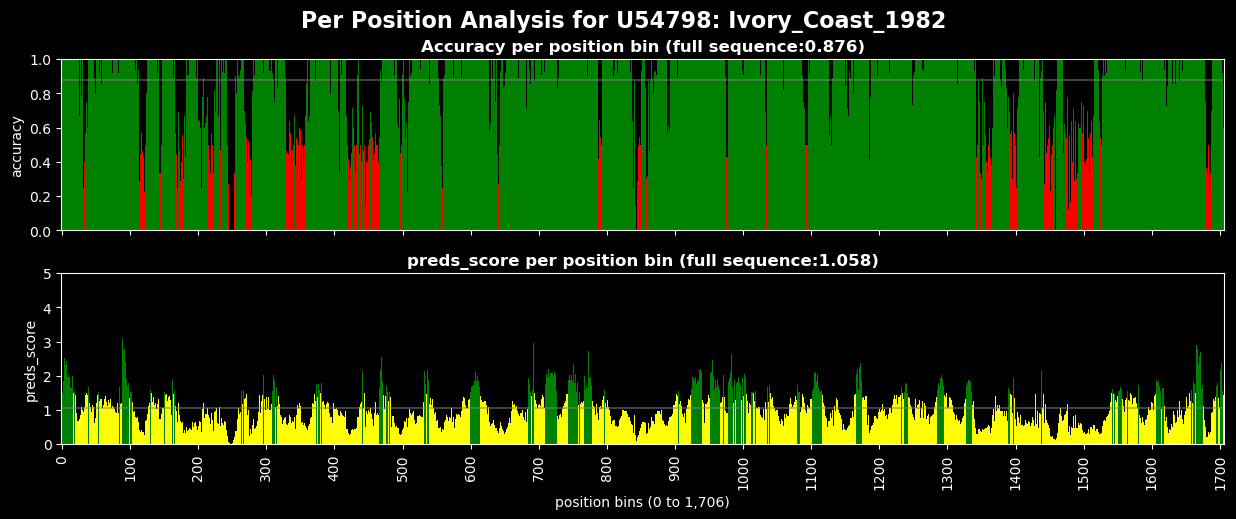

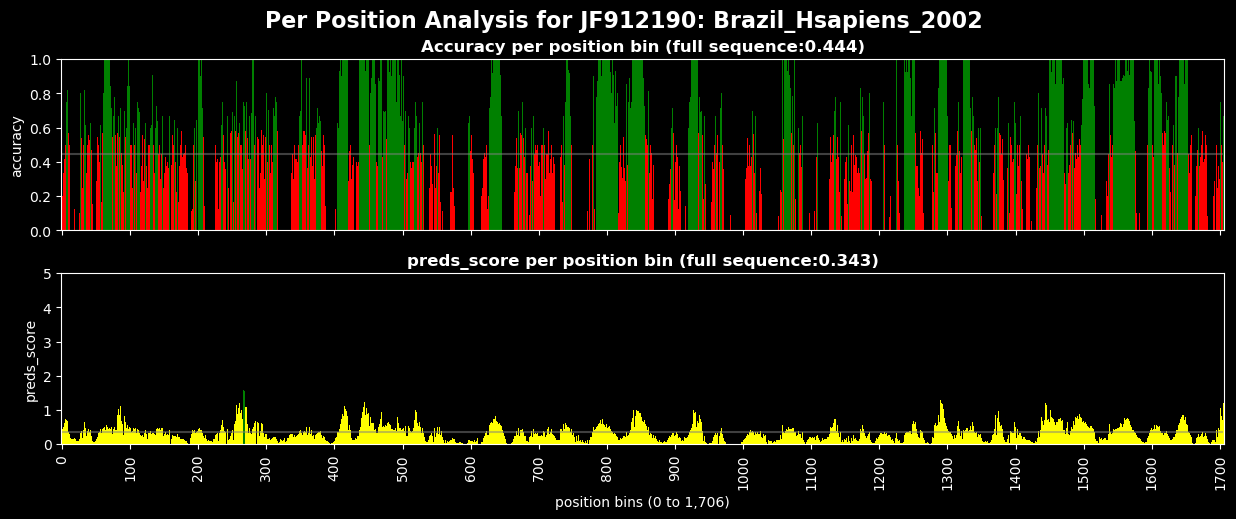

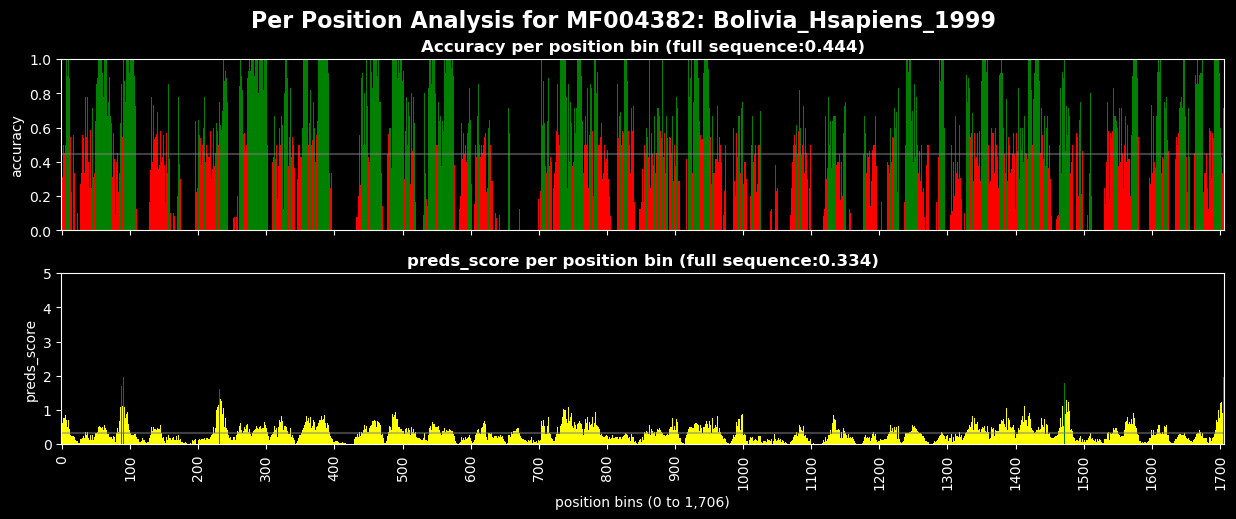

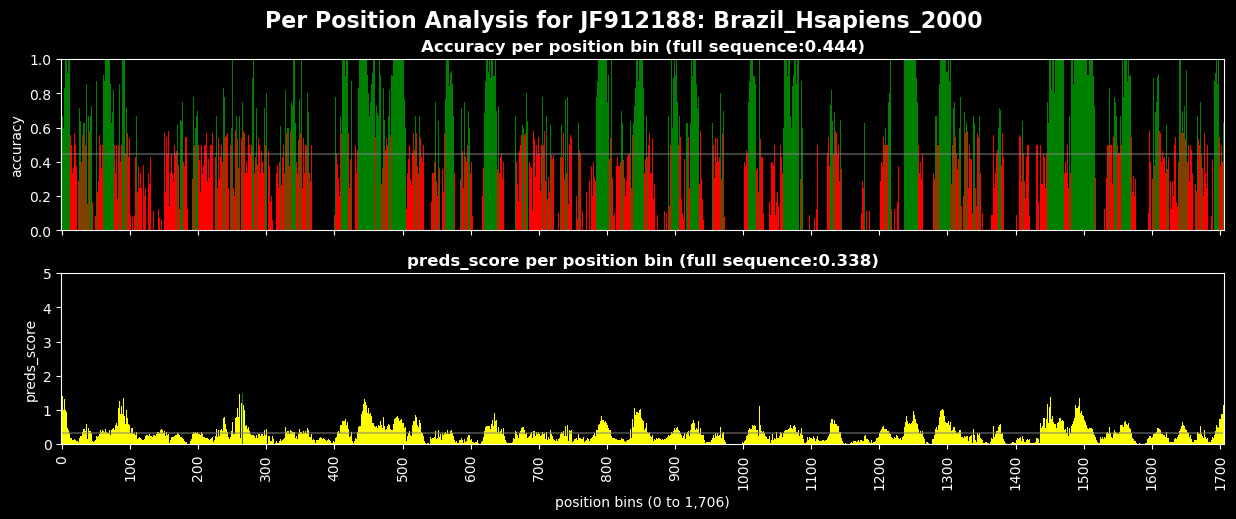

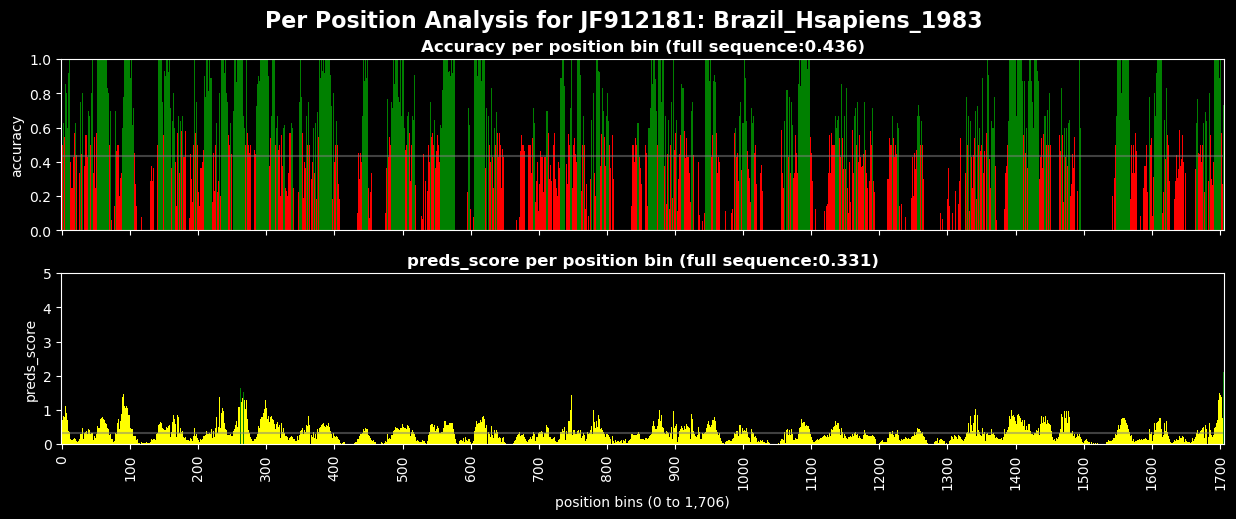

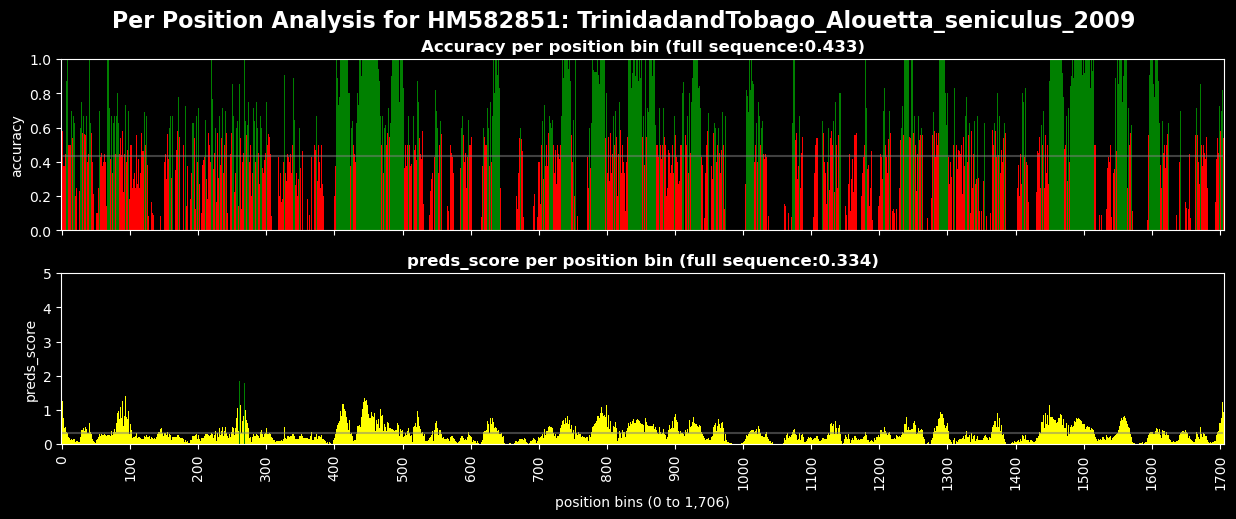

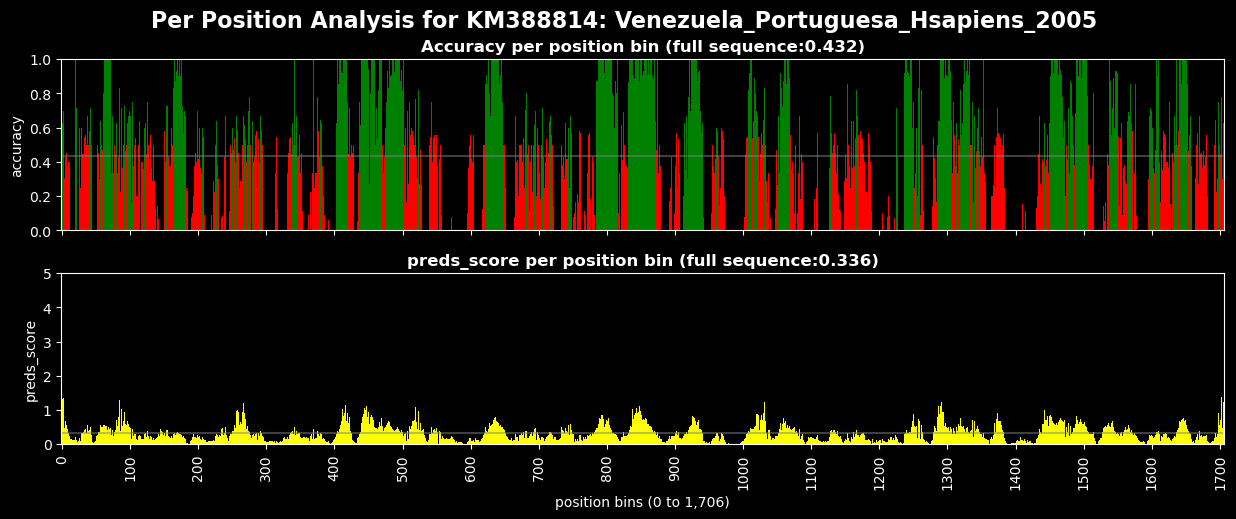

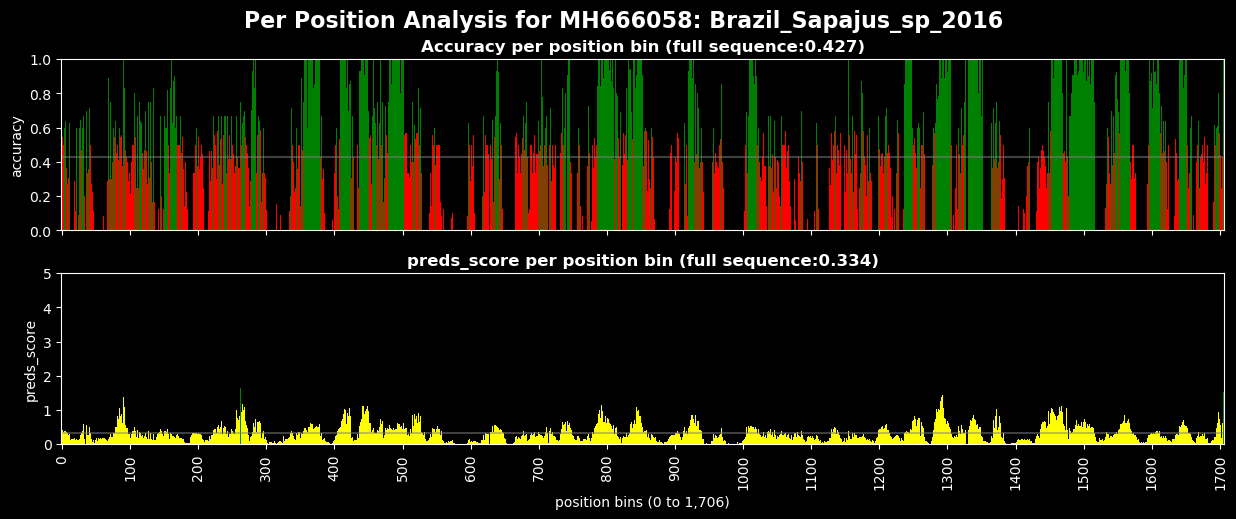

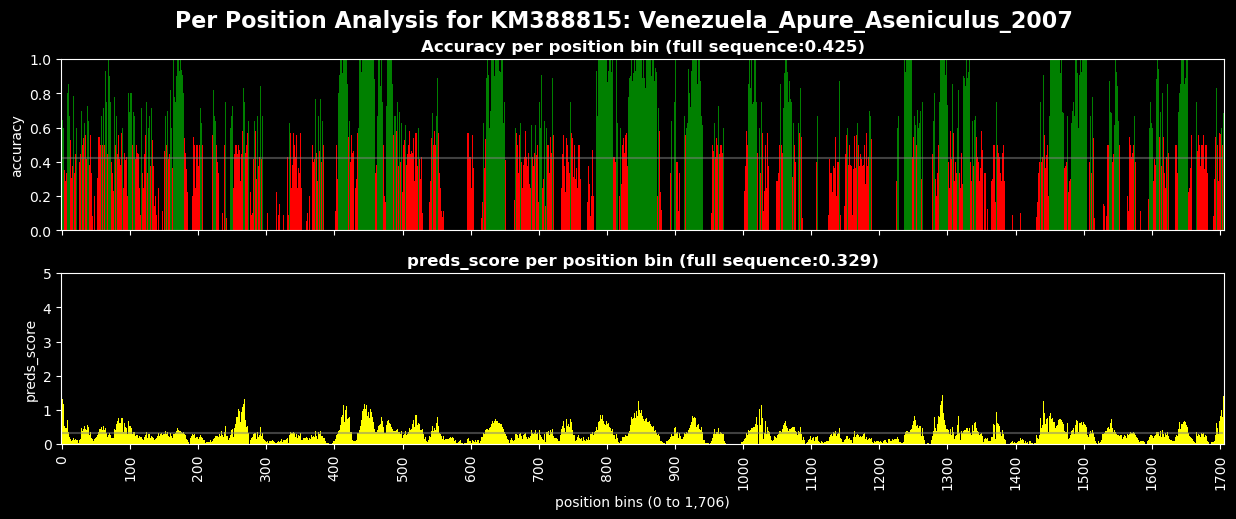

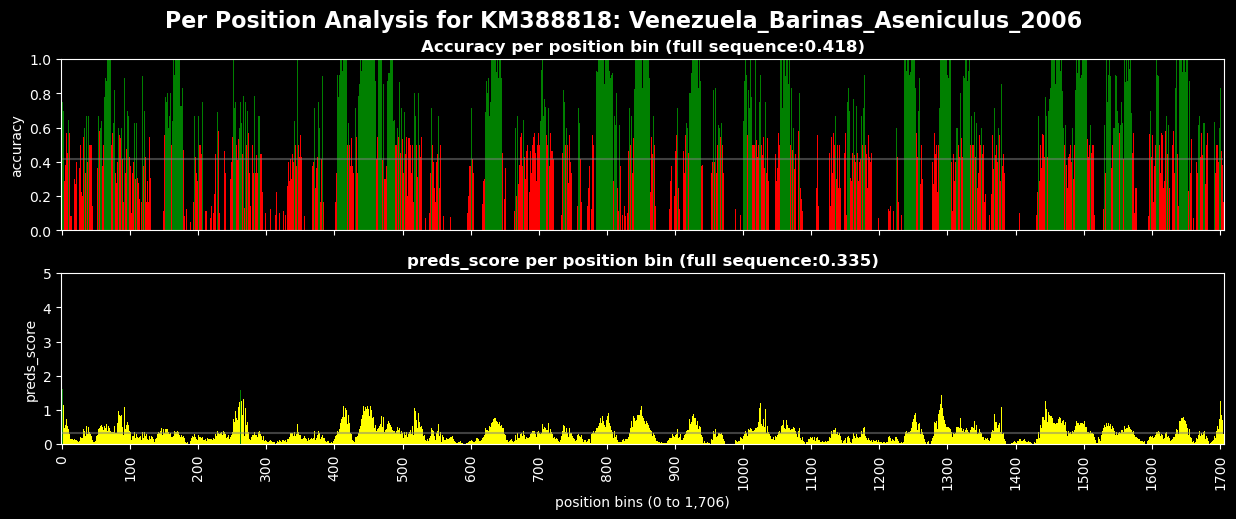

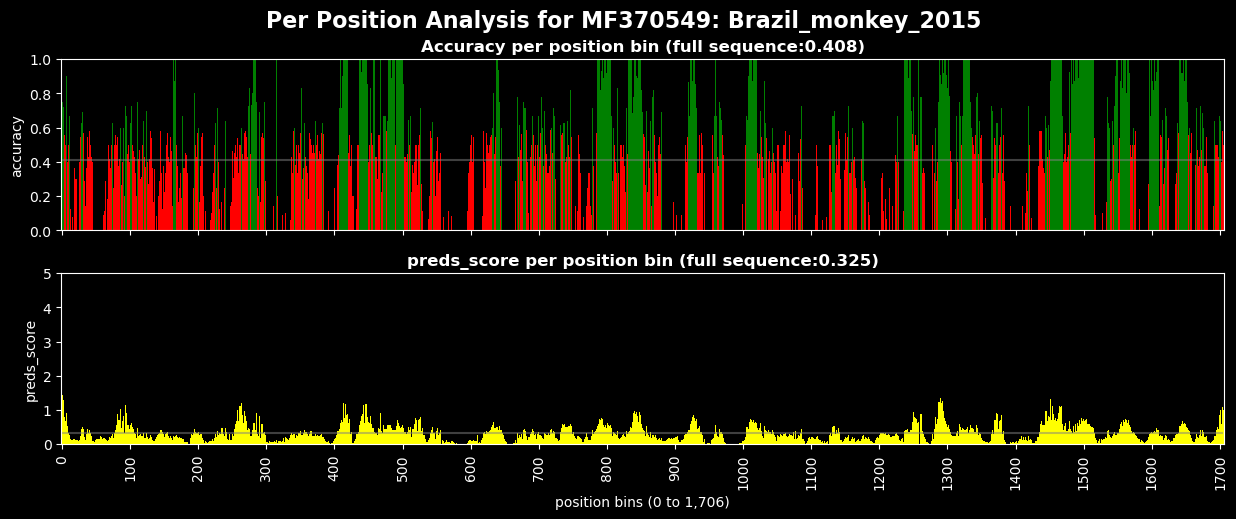

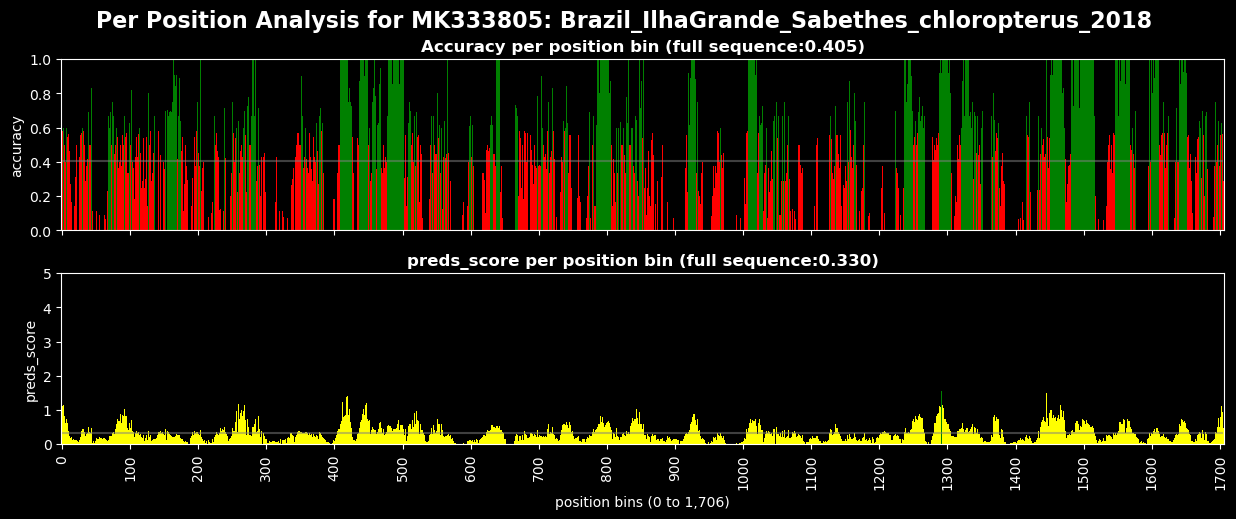

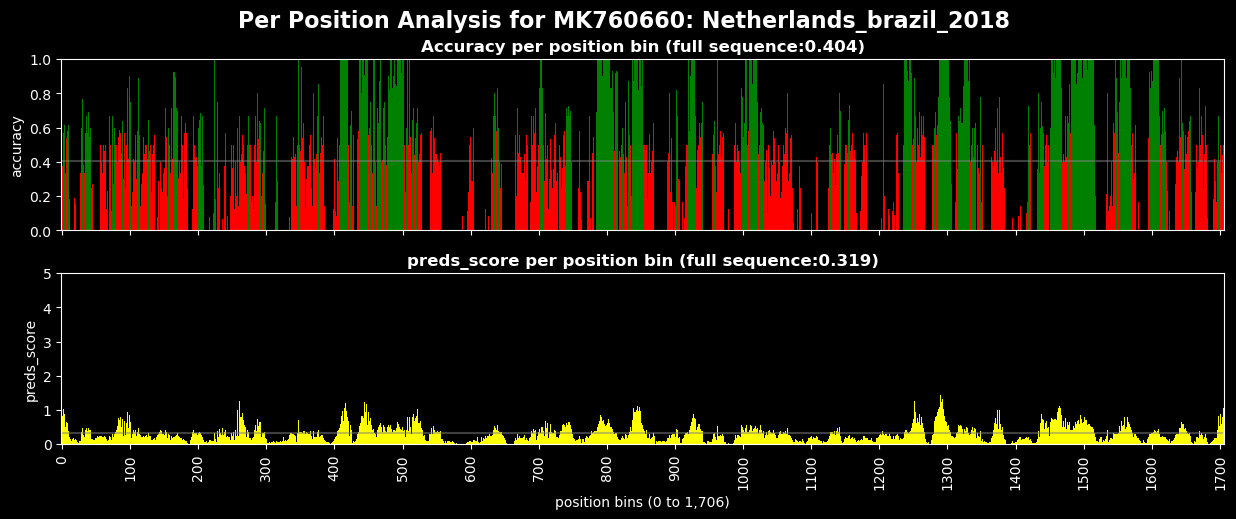

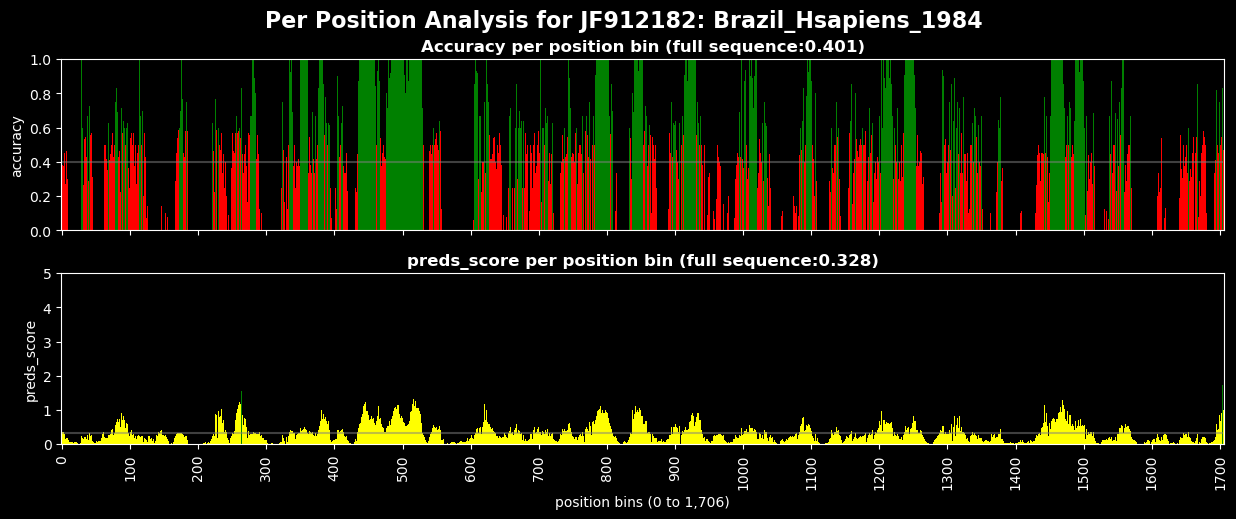

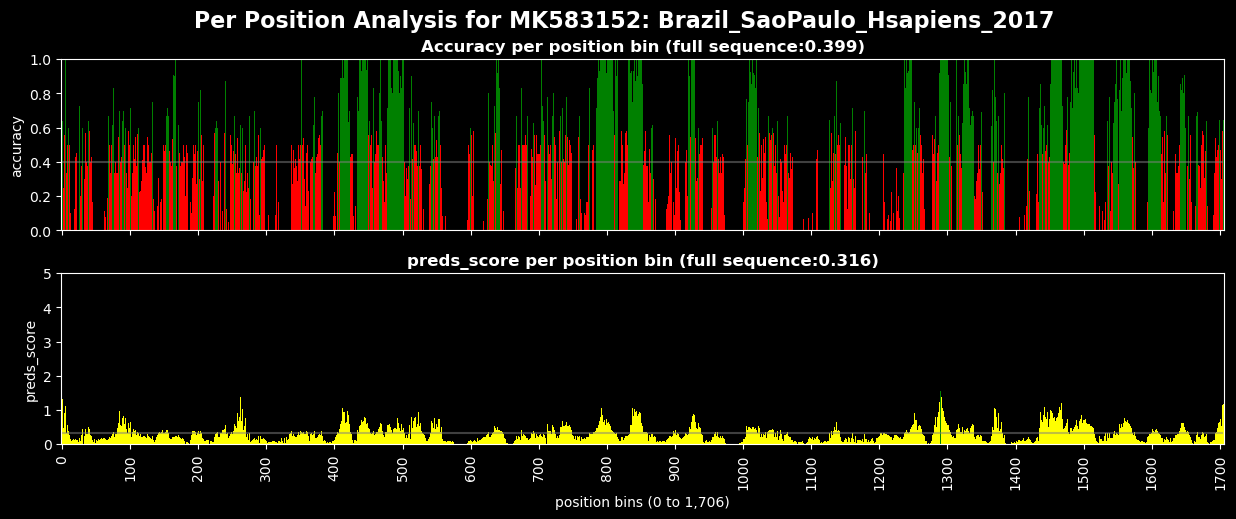

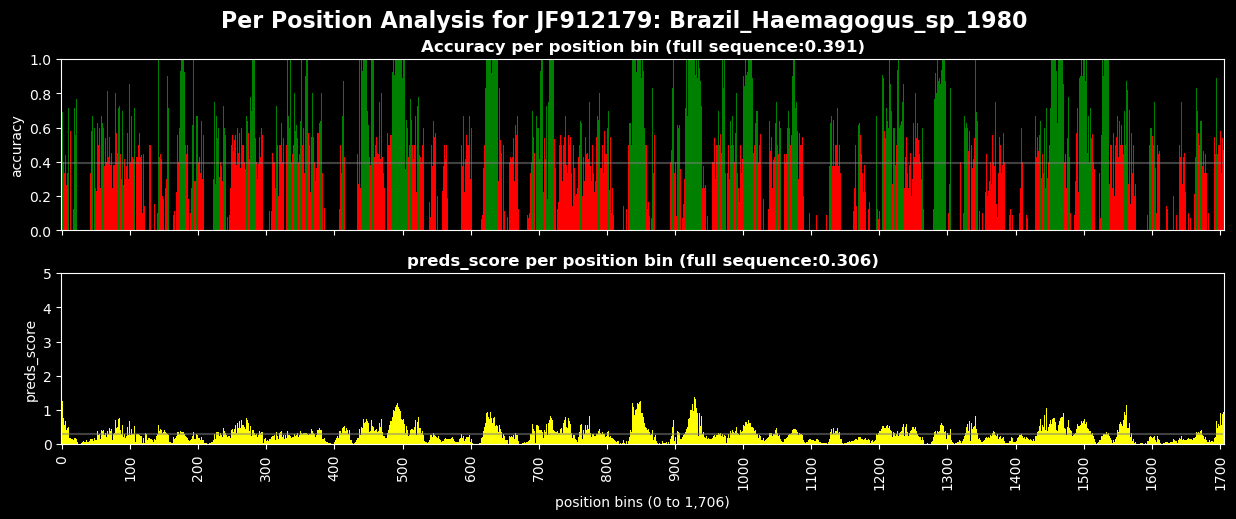

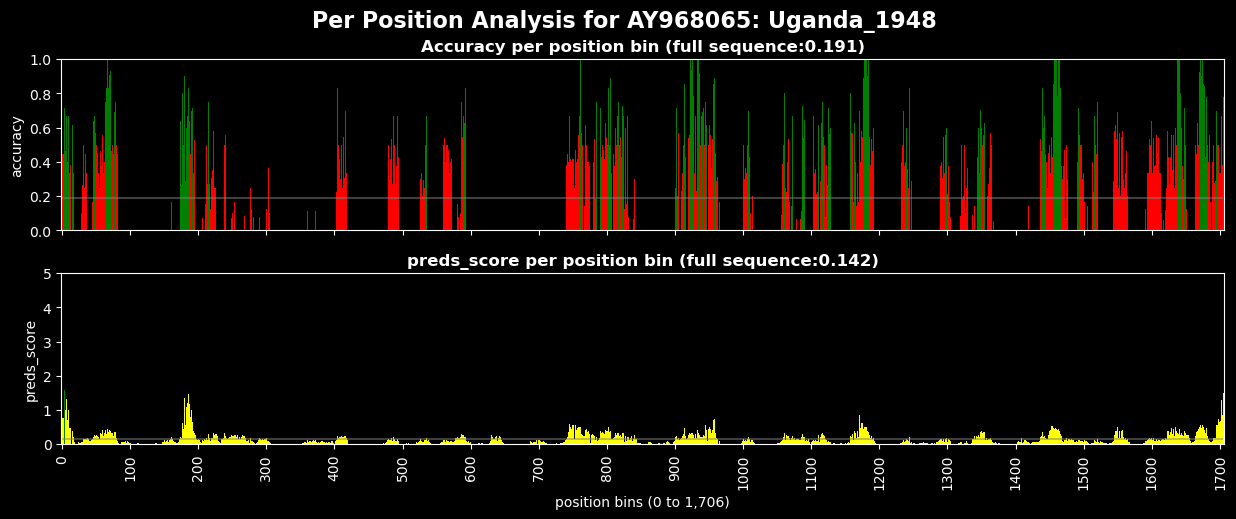

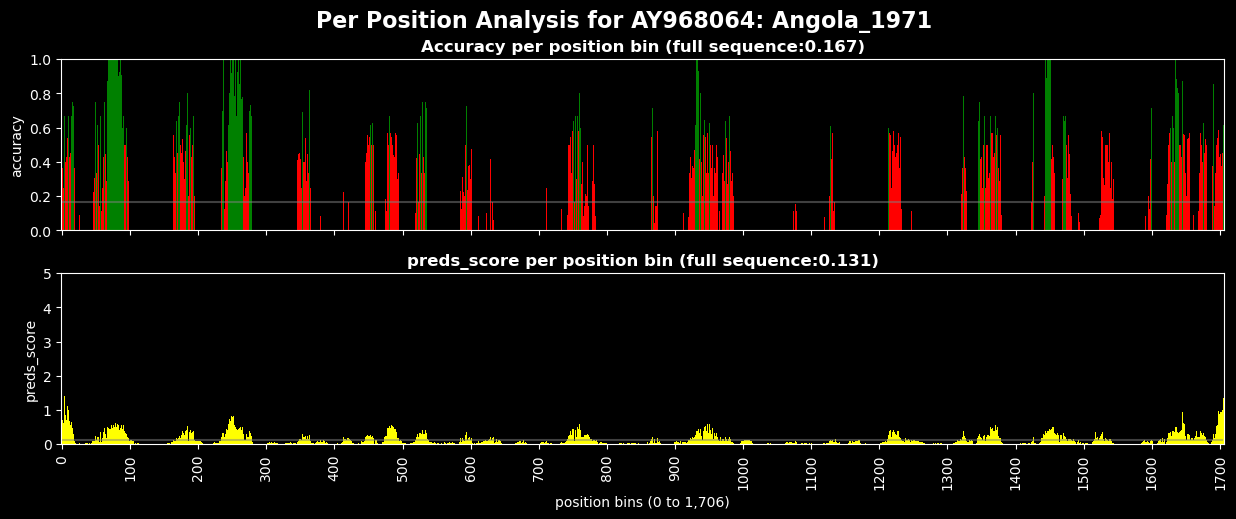

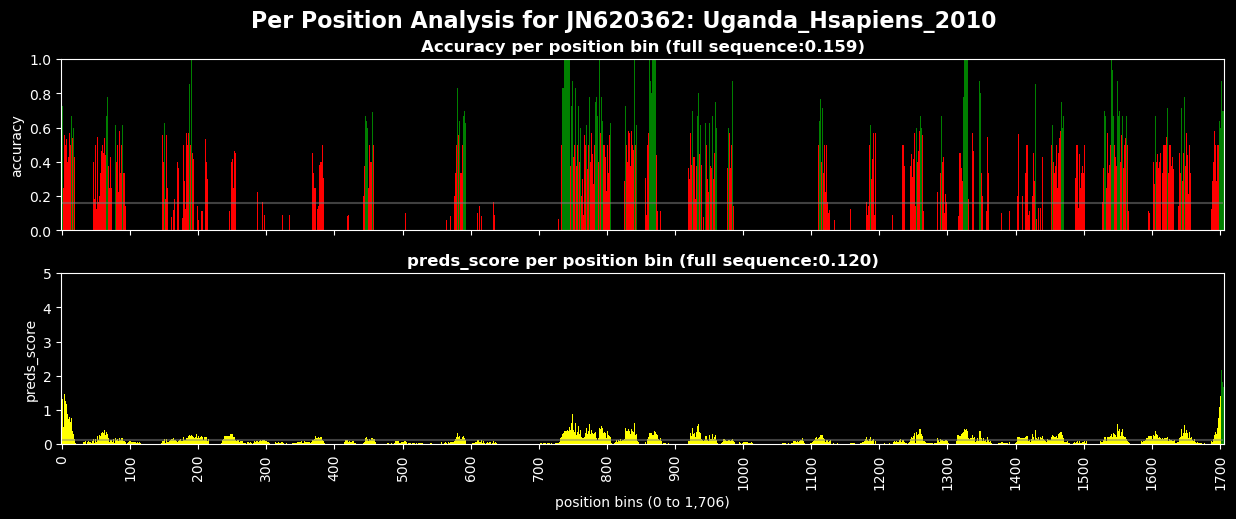

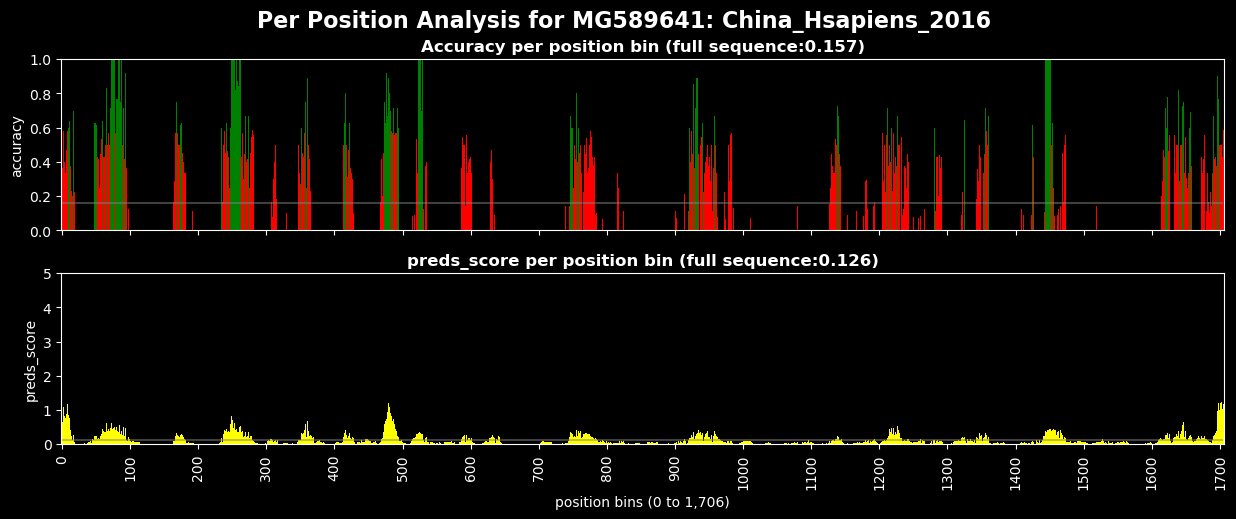

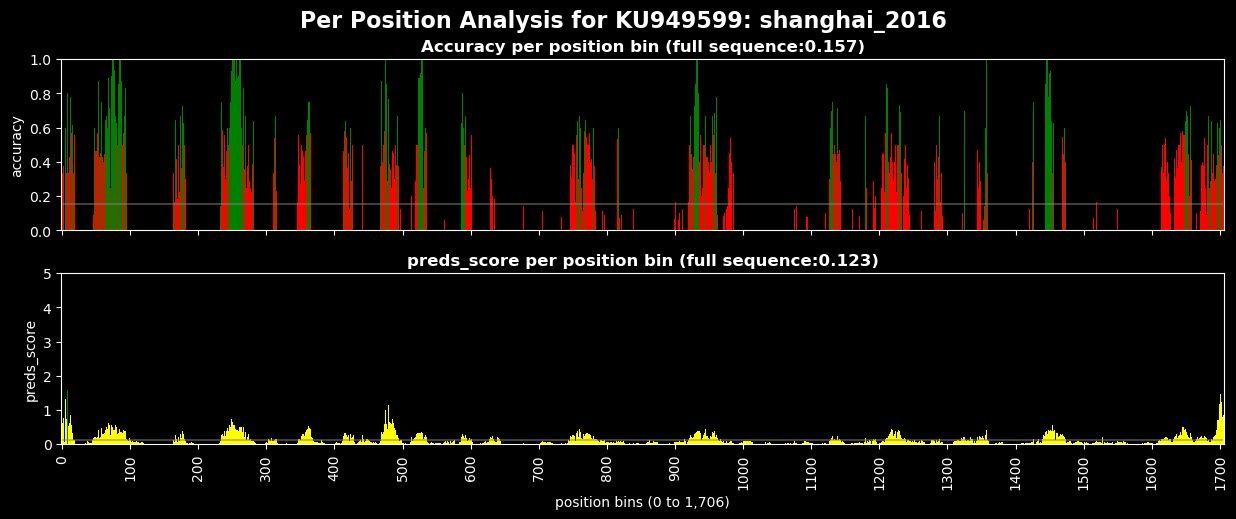

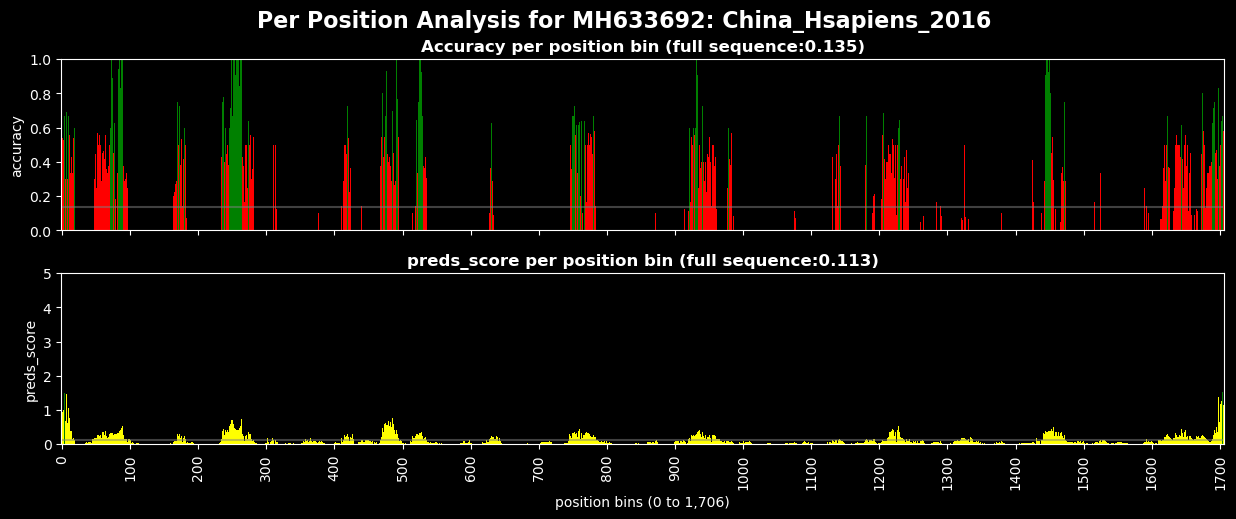

In [36]:
for idx in ordered_index:
    plot_analysis_per_position(df, idx)

## Compare sequences

In [37]:
fa = FastaFileReader(pfs.data/'ncbi/refsequences/yf/yf_2023_yellow_fever.fa')
aln = AlnFileReader(pfs.data/'ncbi/simreads/yf/single_69seq_150bp/single_69seq_150bp.aln')
refseq_meta = aln.parse_header_reference_sequences()

In [38]:
accessions = ['U21056','ON323052', 'MH633692']
ids = [k for k,v in refseq_meta.items() if v['refseq_accession'] in accessions]
pprint({k:refseq_meta[k] for k in ids})

{'11089:ncbi:6': {'organism': 'Senegal_1927',
                  'refseq_accession': 'U21056',
                  'refseq_length': '10237',
                  'refseqid': '11089:ncbi:6',
                  'refseqnb': '6',
                  'refsource': 'ncbi',
                  'reftaxonomyid': '11089'},
 '11089:ncbi:61': {'organism': 'China_Hsapiens_2016',
                   'refseq_accession': 'MH633692',
                   'refseq_length': '10237',
                   'refseqid': '11089:ncbi:61',
                   'refseqnb': '61',
                   'refsource': 'ncbi',
                   'reftaxonomyid': '11089'},
 '11089:ncbi:64': {'organism': 'Nigeria_2020',
                   'refseq_accession': 'ON323052',
                   'refseq_length': '10237',
                   'refseqid': '11089:ncbi:64',
                   'refseqnb': '64',
                   'refsource': 'ncbi',
                   'reftaxonomyid': '11089'}}


In [39]:
fa.reset_iterator()
seqs = {fa.parse_text(o['definition line'])['seqid']:o['sequence'] for o in fa if fa.parse_text(o['definition line'])['accession'] in accessions}
seqs

{'11089:ncbi:6': 'ATGTCTGGTCGTAAAGCTCAGGGAAAAACCCTGGGCGTCAATATGGTACGACGAGGAGTTCGCTCCTTGTCAAACAAAATAAAACAAAAAACAAAACAAATTGGAAACAGACCTGGACCTTCAAGAGGTGTTCAAGGATTTATCTTTTTCTTTTTGTTCAACATTTTGACTGGAAAAAAGATCACGGCCCACCTAAAGAGGTTGTGGAAAATGCTGGACCCAAGACAAGGCTTGGCTGTTCTAAGGAAAGTTAAGAGAGTGGTGGCCAGTTTGATGAGAGGATTGTCCTCAAGGAAACGCCGTTCCCATGATGTTCTGACTGTGCAATTCCTAATTTTGGGAATGCTGTTGATGACGGGTGGAGTGACCTTGGTGCGGAAAAACAGATGGTTGCTCCTAAATGTGACATCTGAGGACCTCGGGAAAACATTCTCTGTGGGCACAGGCAACTGCACAACAAACATTTTGGAAGCCAAGTACTGGTGCCCAGACTCAATGGAATACAACTGTCCCAATCTCAGTCCAAGAGAGGAGCCAGATGACATTGATTGCTGGTGCTATGGGGTGGAAAACGTTAGAGTCGCATATGGTAAGTGTGACTCAGCAGGCAGGTCTAGGAGGTCAAGAAGGGCCATTGACTTGCCTACGCATGAAAACCATGGTTTGAAGACCCGGCAAGAAAAATGGATGACTGGAAGAATGGGTGAAAGGCAACTCCAAAAGATTGAGAGATGGCTCGTGAGGAACCCCTTTTTTGCAGTGACAGCTCTGACCATTGCCTACCTTGTGGGAAGCAACATGACGCAACGAGTCGTGATTGCCCTACTGGTCTTGGCTGTTGGTCCGGCCTACTCAGCTCACTGCATTGGAATTACTGACAGGGATTTCATTGAGGGGGTGCATGGAGGAACTTGGGTTTCAGCTACCCTGGAGCAAGACAAGTGTGTCACTGTTATGGCCCCTGACAAGCCTTCATTGGACA

In [40]:
bin_limits = pos_bins.astype(int).tolist()
bin_limits[:5]

[-10, 5, 11, 17, 23]

In [41]:
def split_seq_in_bins(seq, bins):
    s = ''
    for i,c in enumerate(seq):
        if i-1 in bins:
            s += '|' + c
        else:
            s += c
    return s

b = seqs['11089:ncbi:6']
print(split_seq_in_bins(b, bin_limits))

ATGTCT|GGTCGT|AAAGCT|CAGGGA|AAAACC|CTGGGC|GTCAAT|ATGGTA|CGACGA|GGAGTT|CGCTCC|TTGTC|AAACAA|AATAAA|ACAAAA|AACAAA|ACAAAT|TGGAAA|CAGACC|TGGACC|TTCAAG|AGGTGT|TCAAG|GATTTA|TCTTTT|TCTTTT|TGTTCA|ACATTT|TGACTG|GAAAAA|AGATCA|CGGCCC|ACCTAA|AGAGGT|TGTGG|AAAATG|CTGGAC|CCAAGA|CAAGGC|TTGGCT|GTTCTA|AGGAAA|GTTAAG|AGAGTG|GTGGCC|AGTTT|GATGAG|AGGATT|GTCCTC|AAGGAA|ACGCCG|TTCCCA|TGATGT|TCTGAC|TGTGCA|ATTCCT|AATTT|TGGGAA|TGCTGT|TGATGA|CGGGTG|GAGTGA|CCTTGG|TGCGGA|AAAACA|GATGGT|TGCTCC|TAAATG|TGACA|TCTGAG|GACCTC|GGGAAA|ACATTC|TCTGTG|GGCACA|GGCAAC|TGCACA|ACAAAC|ATTTTG|GAAGC|CAAGTA|CTGGTG|CCCAGA|CTCAAT|GGAATA|CAACTG|TCCCAA|TCTCAG|TCCAAG|AGAGGA|GCCAG|ATGACA|TTGATT|GCTGGT|GCTATG|GGGTGG|AAAACG|TTAGAG|TCGCAT|ATGGTA|AGTGTG|ACTCAG|CAGGC|AGGTCT|AGGAGG|TCAAGA|AGGGCC|ATTGAC|TTGCCT|ACGCAT|GAAAAC|CATGGT|TTGAAG|ACCCG|GCAAGA|AAAATG|GATGAC|TGGAAG|AATGGG|TGAAAG|GCAACT|CCAAAA|GATTGA|GAGATG|GCTCGT|GAGGA|ACCCCT|TTTTTG|CAGTGA|CAGCTC|TGACCA|TTGCCT|ACCTTG|TGGGAA|GCAACA|TGACGC|AACGA|GTCGTG|ATTGCC|CTACTG|GTCTTG|GCTGTT|GGTCCG|GCCTAC|TCAG

In [42]:
fa.parse_text(all_seqs['11089:ncbi:6']['definition line']).keys()

NameError: name 'all_seqs' is not defined

In [ ]:
def compare_seqs(base, seq):
    comp = ''
    diffs = 0
    for i,(b,s) in enumerate(zip(base,seq)):
        if b == s:
            comp += ' '
        else:
            comp += s
            diffs += 1
    return comp, diffs

fa.reset_iterator()
all_seqs = {fa.parse_text(o['definition line'])['seqid']:o for o in fa}
b = all_seqs['11089:ncbi:6']['sequence']

p2seqdiffs = pfs.data / 'ncbi/infer_results/yf-ncbi/analysis/sequence-differences.txt'
p2seqdiffs.touch()

with open(p2seqdiffs, 'w') as f:
    for i, idx in enumerate(ordered_index):
        meta = fa.parse_text(all_seqs[idx]['definition line'])
        s = all_seqs[idx]['sequence']
        c, diffs = compare_seqs(b,s)
        line1 = f"{'='*refseq_length}"
        line2 = f"{idx:15s} {meta['accession']:15s} {meta['organism']:40s} {diffs} differences"
        line3 = split_seq_in_bins(b, bin_limits)
        line4 = split_seq_in_bins(c, bin_limits)
        line5 = split_seq_in_bins(s, bin_limits)
        f.write(line1+'\n')
        f.write(line2+'\n')
        f.write(line3+'\n')
        f.write(line4+'\n')
        f.write(line5+'\n')
        if i < 5:
            print(line1)
            print(line2)
            print(line3)
            print(line4)
            print(line5)
            print()

11089:ncbi:6    U21056          Senegal_1927                             0 differences
ATGTCT|GGTCGT|AAAGCT|CAGGGA|AAAACC|CTGGGC|GTCAAT|ATGGTA|CGACGA|GGAGTT|CGCTCC|TTGTC|AAACAA|AATAAA|ACAAAA|AACAAA|ACAAAT|TGGAAA|CAGACC|TGGACC|TTCAAG|AGGTGT|TCAAG|GATTTA|TCTTTT|TCTTTT|TGTTCA|ACATTT|TGACTG|GAAAAA|AGATCA|CGGCCC|ACCTAA|AGAGGT|TGTGG|AAAATG|CTGGAC|CCAAGA|CAAGGC|TTGGCT|GTTCTA|AGGAAA|GTTAAG|AGAGTG|GTGGCC|AGTTT|GATGAG|AGGATT|GTCCTC|AAGGAA|ACGCCG|TTCCCA|TGATGT|TCTGAC|TGTGCA|ATTCCT|AATTT|TGGGAA|TGCTGT|TGATGA|CGGGTG|GAGTGA|CCTTGG|TGCGGA|AAAACA|GATGGT|TGCTCC|TAAATG|TGACA|TCTGAG|GACCTC|GGGAAA|ACATTC|TCTGTG|GGCACA|GGCAAC|TGCACA|ACAAAC|ATTTTG|GAAGC|CAAGTA|CTGGTG|CCCAGA|CTCAAT|GGAATA|CAACTG|TCCCAA|TCTCAG|TCCAAG|AGAGGA|GCCAG|ATGACA|TTGATT|GCTGGT|GCTATG|GGGTGG|AAAACG|TTAGAG|TCGCAT|ATGGTA|AGTGTG|ACTCAG|CAGGC|AGGTCT|AGGAGG|TCAAGA|AGGGCC|ATTGAC|TTGCCT|ACGCAT|GAAAAC|CATGGT|TTGAAG|ACCCG|GCAAGA|AAAATG|GATGAC|TGGAAG|AATGGG|TGAAAG|GCAACT|CCAAAA|GATTGA|GAGATG|GCTCGT|GAGGA|ACCCCT|TTTTTG|CAGTGA|CAGCTC|TGACCA|TTGCCT|

In [ ]:
reader = TextFileBaseReader(p2seqdiffs, nlines=5)
l = 'U21056 JX898878 U54798 JF912190 AY968065 MH633692'.split(' ')

for block in reader:
    lines = block.split('\n')
    if any([accession in lines[1] for accession in l]):
        print('\n'.join([f"{l[:160]} ..." for l in lines]))


================================================================================================================================================================ ...
11089:ncbi:6    U21056          Senegal_1927                             0 differences ...
ATGTCT|GGTCGT|AAAGCT|CAGGGA|AAAACC|CTGGGC|GTCAAT|ATGGTA|CGACGA|GGAGTT|CGCTCC|TTGTC|AAACAA|AATAAA|ACAAAA|AACAAA|ACAAAT|TGGAAA|CAGACC|TGGACC|TTCAAG|AGGTGT|TCAAG|G ...
      |      |      |      |      |      |      |      |      |      |      |     |      |      |      |      |      |      |      |      |      |      |     |  ...
ATGTCT|GGTCGT|AAAGCT|CAGGGA|AAAACC|CTGGGC|GTCAAT|ATGGTA|CGACGA|GGAGTT|CGCTCC|TTGTC|AAACAA|AATAAA|ACAAAA|AACAAA|ACAAAT|TGGAAA|CAGACC|TGGACC|TTCAAG|AGGTGT|TCAAG|G ...
 ...
================================================================================================================================================================ ...
11089:ncbi:14   JX898878        ArD181250_Senegal_2005                   368 di

## Impact Mutation on Accuracy

In [ ]:
bin_limits[1:10]

[5, 11, 17, 23, 29, 35, 41, 47, 53]

In [ ]:
bin_low_limit = np.array(bin_limits)
bin_high_limit = bin_low_limit + 150
read_ranges = [(max(0,l),h) for l,h in zip(bin_low_limit[:-1], bin_high_limit[1:])]
nb_bins, len(read_ranges), read_ranges[:5]

(1706, 1706, [(0, 155), (5, 161), (11, 167), (17, 173), (23, 179)])

build a dataset as a dictionary:
```python
{
    'refseqid': {
        'accuracy': accuracy,
        'preds_score': preds_score,
        'probs_score': probs_score,
        'reads': {
            pos: {
                'range': (start, end)
                'read': 'sequence,
                'mutations': mutations
            }
        }
    }
}
```

In [ ]:
refseqid = '11089:ncbi:1'

base_seqid = '11089:ncbi:6'
base_seq = all_seqs[base_seqid]['sequence']

info = df_refseqs.loc[refseqid,'info']
seq = all_seqs[refseqid]['sequence']

accuracy = df_refseqs.loc[refseqid,'mean acc']
preds_score = df_['preds_score'].mean()
probs_score = df_['probs_score'].mean()

refseq_dict = {}
refseq_dict['refseqid'] = refseqid
refseq_dict['info'] = info
refseq_dict['definition line'] = all_seqs[refseqid]['definition line']
refseq_dict['sequence'] = seq
refseq_dict['accuracy'] = accuracy
refseq_dict['preds_score'] = preds_score
refseq_dict['probs_score'] = probs_score

base_reads = [base_seq[s:e] for k, (s,e) in enumerate(read_ranges)]
reads = [seq[s:e] for k, (s,e) in enumerate(read_ranges)]
mutations = [compare_seqs(base=b, seq=s)[0] for b,s in zip(base_reads, reads)]

refseq_dict['position'] = {i:{'base':b, 'read':r, 'mutation':m} for i,(b,r,m) in enumerate(zip(base_reads,reads, mutations))}

n = 400
print(refseq_dict['position'][n]['base'])
print(refseq_dict['position'][n]['mutation'])
print(refseq_dict['position'][n]['read'])


AGAGAGCTCAAGTGCGGAGATGGTATCTTCATATTTAGAGACTCTGATGACTGGCTGAACAAGTACTCATACTATCCAGAAGATCCTGTGAAGCTTGCATCAATAGTGAAAGCCTCTTTTGAAGAAGGGAAGTGTGGCCTAAATTCAGTTGACTCC
C C        A           C     TG G                 T     C CA                 T     C     C  AT G     C  TA T        CCAC  G  G  C  A     AT G           T   
CGCGAGCTCAAATGCGGAGATGGCATCTTTGTGTTTAGAGACTCTGATGATTGGCTCACAAAGTACTCATACTATCCTGAAGACCCTGTCAAATTGGCATCCATTATTAAAGCCTCCCACGAGGAGGGCAAATGTGGATTGAATTCAGTTGATTCC


In [ ]:
def analyze_position(df: pd.DataFrame, refseqid:str):
    base_seqid = '11089:ncbi:6'
    base_seq = all_seqs[base_seqid]['sequence']

    info = df_refseqs.loc[refseqid,'info']
    seq = all_seqs[refseqid]['sequence']

    accuracy = df_refseqs.loc[refseqid,'mean acc']
    preds_score = df_['preds_score'].mean()
    probs_score = df_['probs_score'].mean()

    refseq_dict = {}
    refseq_dict['refseqid'] = refseqid
    refseq_dict['info'] = info
    refseq_dict['definition line'] = all_seqs[refseqid]['definition line']
    refseq_dict['sequence'] = seq
    refseq_dict['accuracy'] = accuracy
    refseq_dict['preds_score'] = preds_score
    refseq_dict['probs_score'] = probs_score

    base_reads = [base_seq[s:e] for k, (s,e) in enumerate(read_ranges)]
    reads = [seq[s:e] for k, (s,e) in enumerate(read_ranges)]
    mutations = [compare_seqs(base=b, seq=s)[0] for b,s in zip(base_reads, reads)]
    nb_differences = [compare_seqs(base=b, seq=s)[1] for b,s in zip(base_reads, reads)]

    refseq_dict['position'] = {i:{'base':b, 'read':r, 'mutation':m, 'diffs': d} for i,(b,r,m,d) in enumerate(zip(base_reads,reads, mutations, nb_differences))}

    return refseq_dict

# pprint(analyze_position(df, '11089:ncbi:1'))

In [ ]:
genome_dict = {}
for idx in ordered_index:
    genome_dict[idx] = analyze_position(df, idx)

p2json = pfs.data / 'ncbi/infer_results/yf-ncbi/analysis/genome-analysis.json'
with open(p2json, 'w') as f:
    json.dump(genome_dict, f, indent=4)
  

In [ ]:
pprint(genome_dict['11089:ncbi:1'])

{'accuracy': 0.16676470588235295,
 'definition line': '>11089:ncbi:1\t1\tAY968064\t11089\tncbi\tAngola_1971',
 'info': 'AY968064: Angola_1971',
 'position': {0: {'base': 'ATGTCTGGTCGTAAAGCTCAGGGAAAAACCCTGGGCGTCAATATGGTACGACGAGGAGTTCGCTCCTTGTCAAACAAAATAAAACAAAAAACAAAACAAATTGGAAACAGACCTGGACCTTCAAGAGGTGTTCAAGGATTTATCTTTTTCTTTTT',
                  'diffs': 8,
                  'mutation': '           A           T                        '
                              'A       '
                              'G                                         '
                              'G                 C                          T  '
                              'C        ',
                  'read': 'ATGTCTGGTCGAAAAGCTCAGGGTAAAACCCTGGGCGTCAATATGGTAAGACGAGGGGTTCGCTCCTTGTCAAACAAAATAAAACAAAAAACAAAACAGATTGGAAACAGACCTGGCCCTTCAAGAGGTGTTCAAGGATTTATTTTCTTCTTTTT'},
              1: {'base': 'TGGTCGTAAAGCTCAGGGAAAAACCCTGGGCGTCAATATGGTACGACGAGGAGTTCGCTCCTTGTCAAACAAAATAAAACAAAAAACAAAACAAATTGGAAACAGAC

In [ ]:
refseqid = '11089:ncbi:1'
df_ = df.loc[df['refseqid'] == refseqid, :].groupby('bin').mean()
good_pos = list(df_.loc[df_.accuracy > 0.75, :].index)
poor_pos = list(df_.loc[df_.accuracy < 0.25, :].index)
len(good_pos), good_pos[:5], len(poor_pos), poor_pos[:5]

(74, [12, 67, 68, 69, 70], 1225, [0, 3, 6, 19, 20])

In [ ]:
for pos in good_pos:
    print(f"{pos}, {df_.loc[pos, 'accuracy']:.2f}")
    print(genome_dict[refseqid]['position'][good_pos[0]]['base'])
    print(genome_dict[refseqid]['position'][good_pos[0]]['mutation'])
    print(genome_dict[refseqid]['position'][good_pos[0]]['read'])
    print(genome_dict[refseqid]['position'][good_pos[0]]['diffs'])
    print()

12, 0.77
CAAACAAAATAAAACAAAAAACAAAACAAATTGGAAACAGACCTGGACCTTCAAGAGGTGTTCAAGGATTTATCTTTTTCTTTTTGTTCAACATTTTGACTGGAAAAAAGATCACGGCCCACCTAAAGAGGTTGTGGAAAATGCTGGACCCAAGAC
                            G                 C                          T  C           T      C       G      T G  T  T  T     A AAC T    GG     T  T     G 
CAAACAAAATAAAACAAAAAACAAAACAGATTGGAAACAGACCTGGCCCTTCAAGAGGTGTTCAAGGATTTATTTTCTTCTTTTTGTTTAACATTCTGACTGGGAAAAAGTTGACTGCTCATCTAAAAAAACTTTGGAGGATGCTTGATCCAAGGC
22

67, 0.88
CAAACAAAATAAAACAAAAAACAAAACAAATTGGAAACAGACCTGGACCTTCAAGAGGTGTTCAAGGATTTATCTTTTTCTTTTTGTTCAACATTTTGACTGGAAAAAAGATCACGGCCCACCTAAAGAGGTTGTGGAAAATGCTGGACCCAAGAC
                            G                 C                          T  C           T      C       G      T G  T  T  T     A AAC T    GG     T  T     G 
CAAACAAAATAAAACAAAAAACAAAACAGATTGGAAACAGACCTGGCCCTTCAAGAGGTGTTCAAGGATTTATTTTCTTCTTTTTGTTTAACATTCTGACTGGGAAAAAGTTGACTGCTCATCTAAAAAAACTTTGGAGGATGCTTGATCCAAGGC
22

68, 1.00
CAAACAAAATAAAACAAAAAACA

In [ ]:
def bp2color(string:str, rows=3)->np.array:
    """
    Adenine (A): Often represented in green.
    Cytosine (C): Commonly shown in blue.
    Guanine (G): Frequently depicted in yellow or black.
    Thymine (T): Typically illustrated in red.
    """
    # s2c = {'A':np.array([0.,1.,0.]), 'C':np.array([0.,0.,1.]), 'G':np.array([1.,1.,0.]), 'T':np.array([1.,0.,0.]), ' ':np.array([0.,0.,0.])}
    s2c = {
        'A':np.array([143,199,150], dtype=np.uint8), 
        'C':np.array([131,208,240], dtype=np.uint8), 
        'G':np.array([255,245,154], dtype=np.uint8), 
        'T':np.array([241,159,193], dtype=np.uint8), 
        ' ':np.array([0,0,0], dtype=np.uint8)}
    return np.row_stack([np.expand_dims(np.array([s2c[s] for s in string]),axis=0)]*rows)

bp2color('ACGT')

array([[[143, 199, 150],
        [131, 208, 240],
        [255, 245, 154],
        [241, 159, 193]],

       [[143, 199, 150],
        [131, 208, 240],
        [255, 245, 154],
        [241, 159, 193]],

       [[143, 199, 150],
        [131, 208, 240],
        [255, 245, 154],
        [241, 159, 193]]], dtype=uint8)

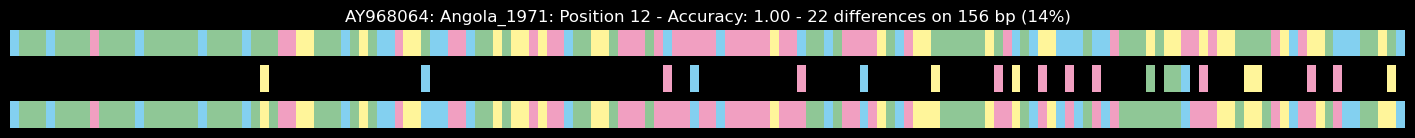

In [ ]:
def plot_reads(refseqid, position, acc):
    base = bp2color(genome_dict[refseqid]['position'][position]['base'])
    mutation = bp2color(genome_dict[refseqid]['position'][position]['mutation'])
    read = bp2color(genome_dict[refseqid]['position'][position]['read'])
    diffs = genome_dict[refseqid]['position'][position]['diffs']
    separator = np.zeros((1,base.shape[1],3), dtype=np.uint8)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,2))
    title = f"{genome_dict[refseqid]['info']}: Position {position} - Accuracy: {acc:.2f} - {diffs} differences on {base.shape[1]} bp ({diffs/base.shape[1]:.0%})"
    ax.set_title(title, fontsize=12)
    img = np.row_stack([base, separator, mutation, separator, read])
    ax.imshow(img, aspect='equal')
    ax.axis('off')
    plt.show()

plot_reads('11089:ncbi:1', good_pos[0], 1)

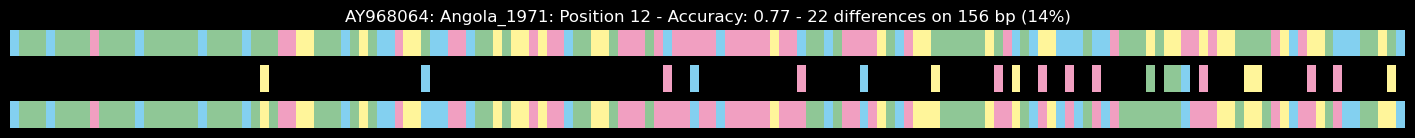

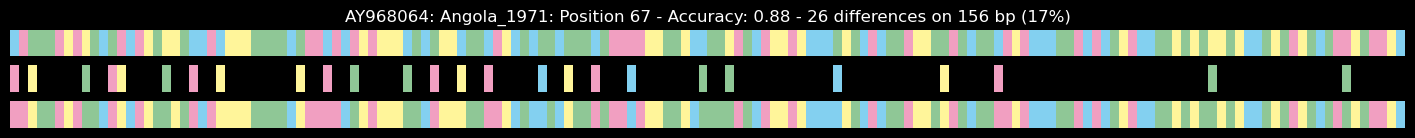

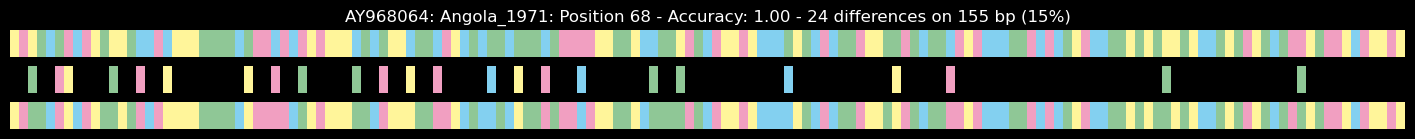

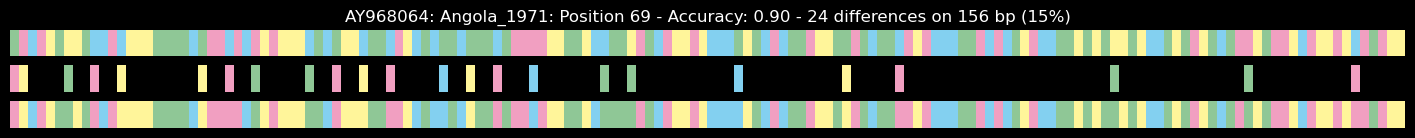

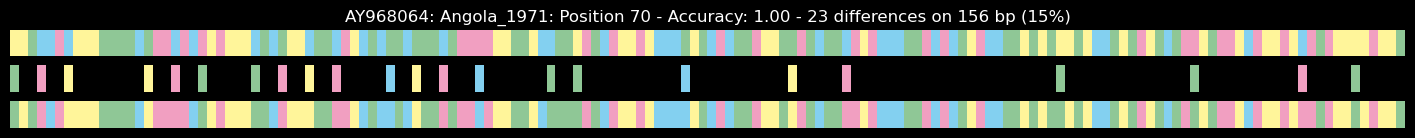

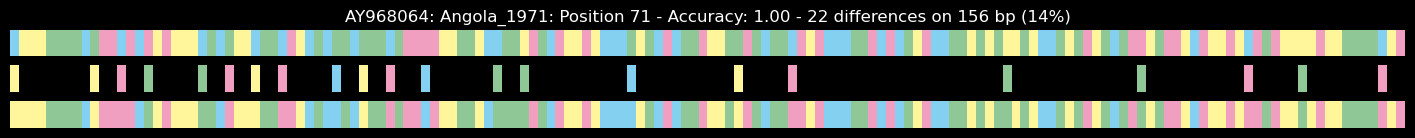

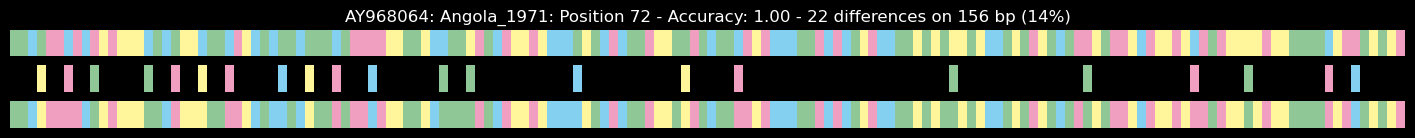

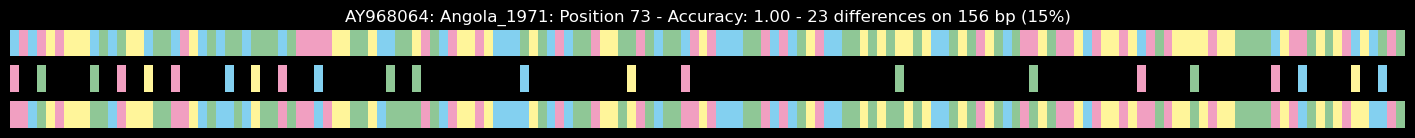

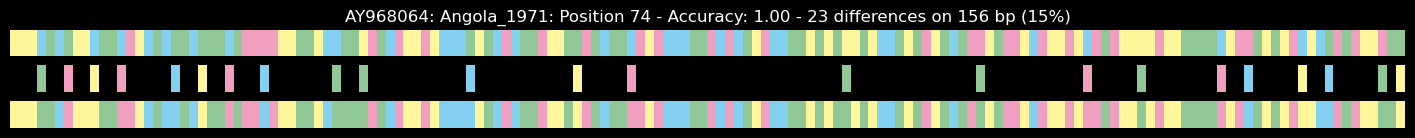

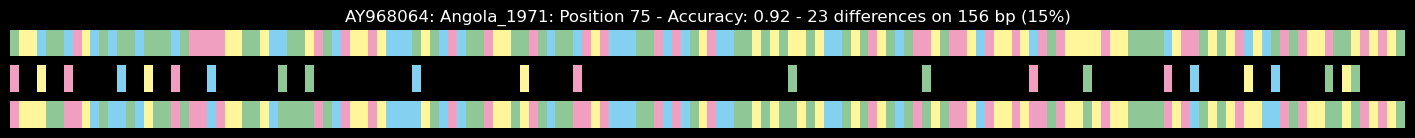

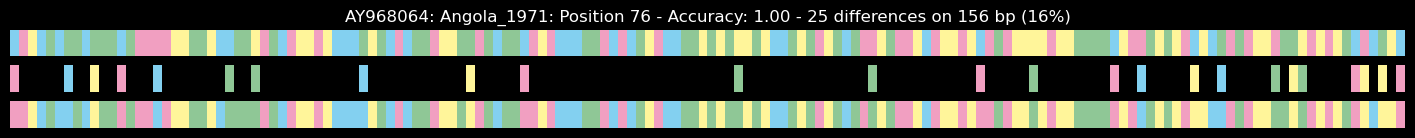

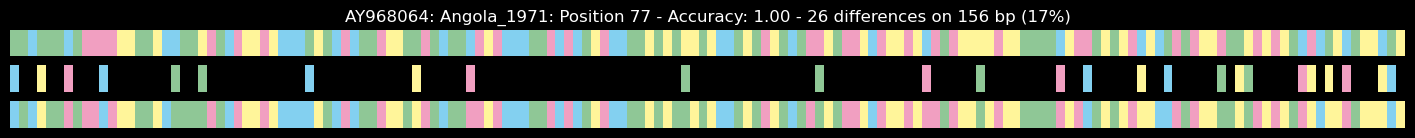

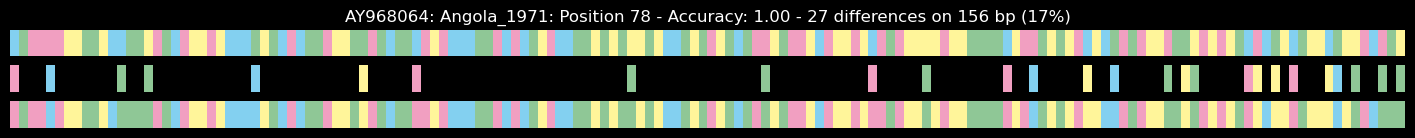

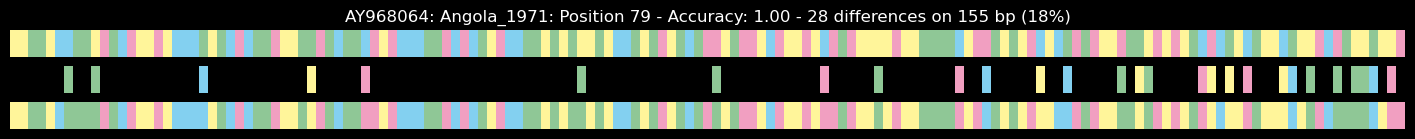

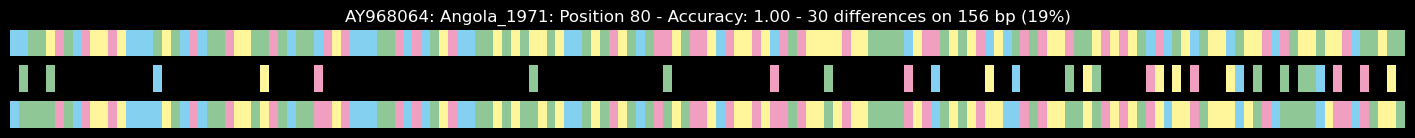

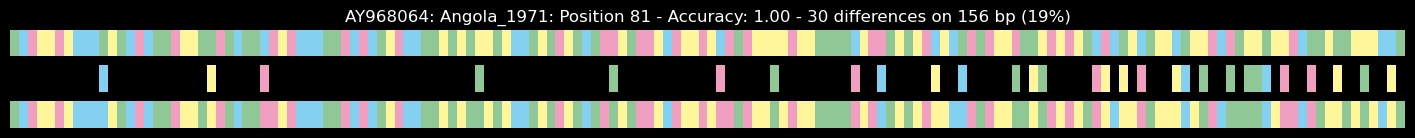

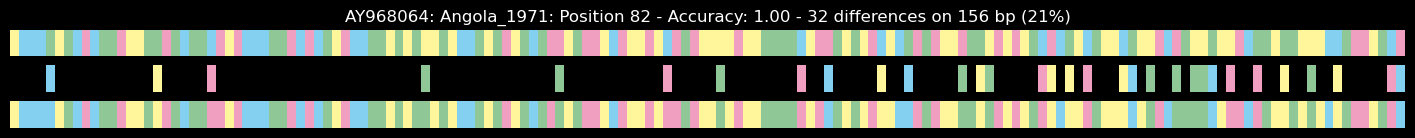

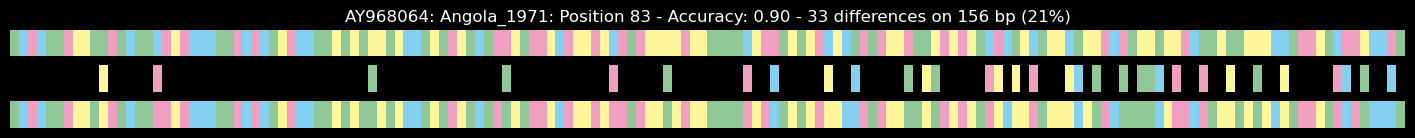

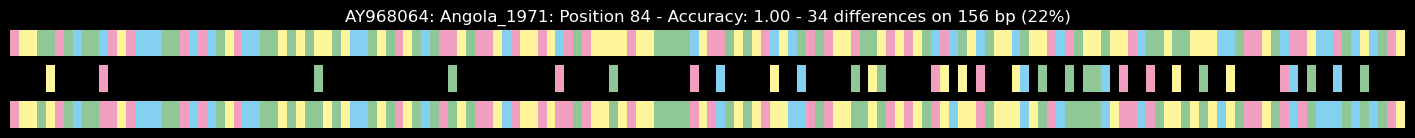

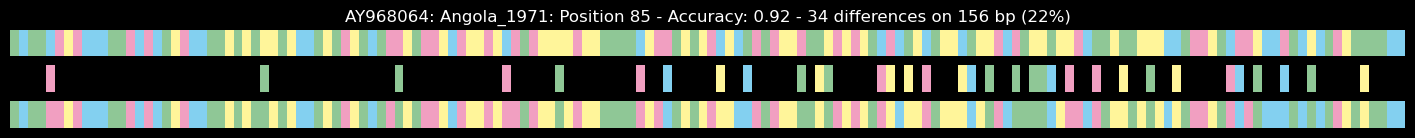

In [ ]:
for pos in good_pos[:20]:
    plot_reads(refseqid, pos, df_.loc[pos, 'accuracy'])

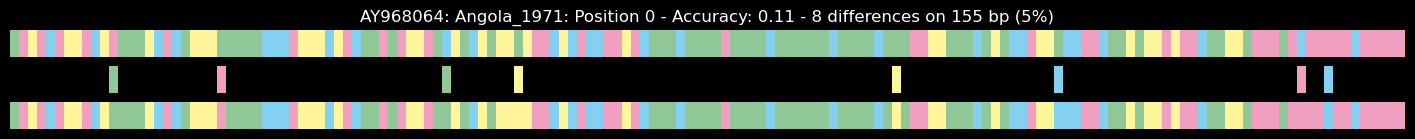

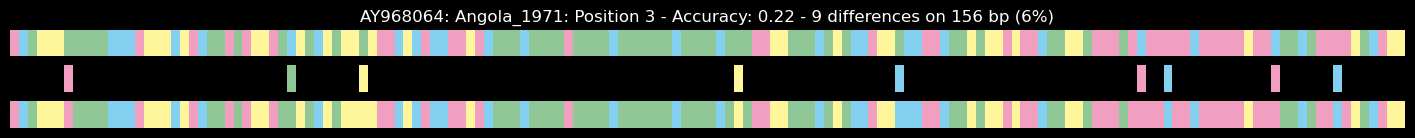

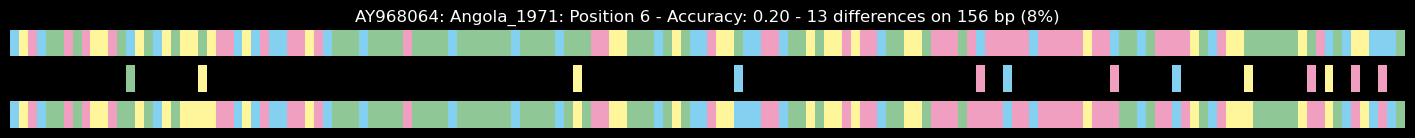

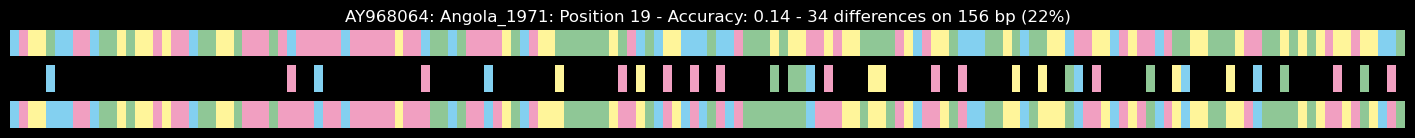

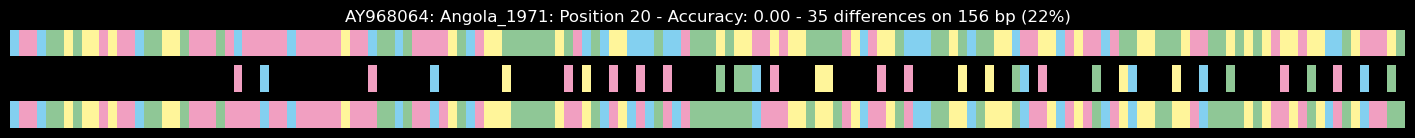

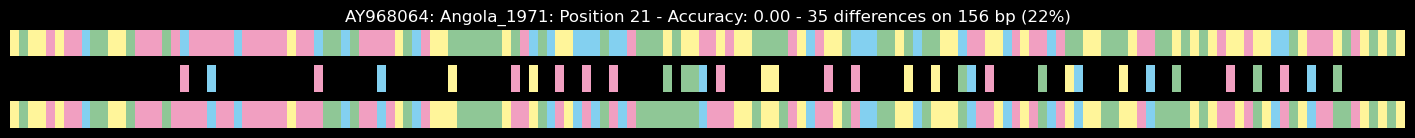

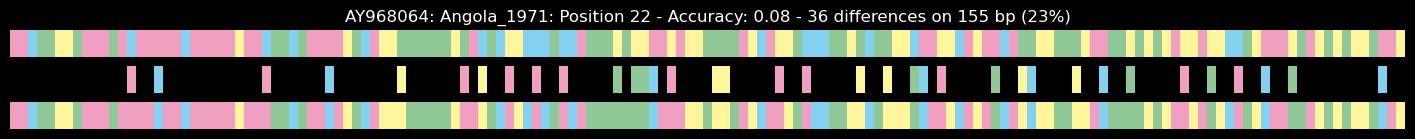

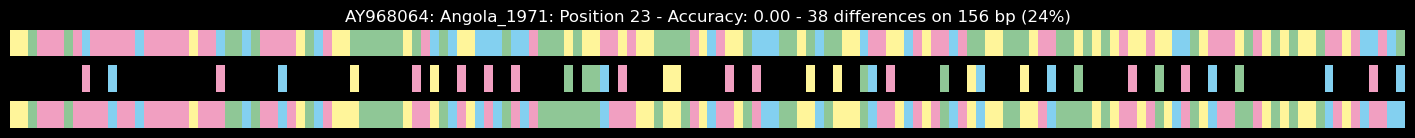

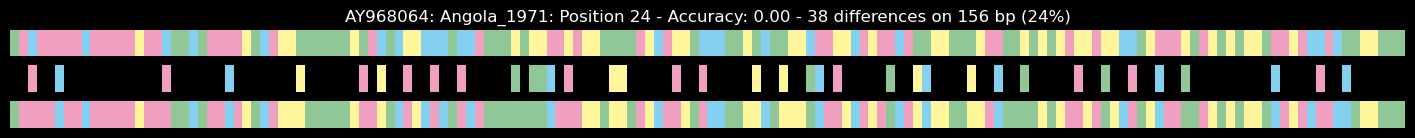

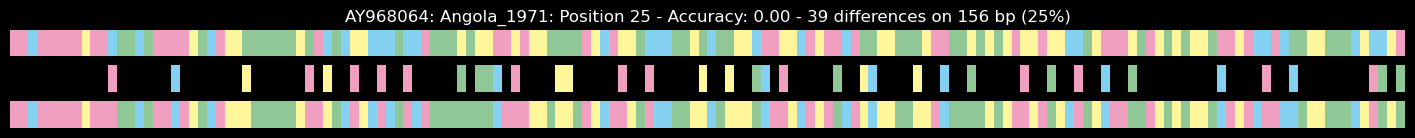

In [ ]:
for pos in poor_pos[:10]:
    plot_reads(refseqid, pos, df_.loc[pos, 'accuracy'])

# Sandbox

## Distance Matrix

In [ ]:
p2matrix = pfs.data / 'ncbi/other/yf/YF_2023_envelop_percentage_distance_matrix.csv'
dist_mx = pd.read_csv(p2matrix, index_col=0)
for col in dist_mx.columns:
    dist_mx[col] = dist_mx[col].str.rstrip('%').astype(float)/100
dist_mx

YFV_Cameroon_2023  YFV_CAR_2019  \
                                                                   
YFV_Cameroon_2023                             0.00          0.04   
YFV_CAR_2019                                  0.04          0.00   
U21056_senegal_1927                           0.19          0.19   
JX898870_senegal_1996                         0.19          0.18   
U23574_Senegal_1965                           0.19          0.18   
...                                            ...           ...   
MK760660_Netherlands_2018                     0.19          0.19   
MK333805_Brazil_IlhaGrande_2018               0.19          0.19   
MW308135_Brazil_2019                          0.19          0.19   
MZ604867_Brazil_2019                          0.19          0.19   
MZ712143_Brazil_2021                          0.19          0.19   

                                 U21056_senegal_1927  JX898870_senegal_1996  \
                                                                              
YFV_Cameroon_2023                               0.19                   0.19   
YFV_CAR_2019                                    0.19                   0.18   
U21056_senegal_1927                             0.00                   0.04   
JX898870_senegal_1996                           0.04                   0.00   
U23574_Senegal_1965                             0.04                   0.03   
...                                              ...                    ...   
MK760660_Netherlands_2018                       0.15                   0.15   
MK333805_Brazil_IlhaGrande_2018                 0.15                   0.15   
MW308135_Brazil_2019                            0.15                   0.15   
MZ604867_Brazil_2019                            0.15                   0.15   
MZ712143_Brazil_2021                            0.15                   0.15   

                                 U23574_Senegal_1965  JX898868_Senegal_1995  \
                                                                              
YFV_Cameroon_2023                               0.19                   0.19   
YFV_CAR_2019                                    0.18                   0.18   
U21056_senegal_1927                             0.04                   0.04   
JX898870_senegal_1996                           0.03                   0.00   
U23574_Senegal_1965                             0.00                   0.03   
...                                              ...                    ...   
MK760660_Netherlands_2018                       0.15                   0.15   
MK333805_Brazil_IlhaGrande_2018                 0.15                   0.15   
MW308135_Brazil_2019                            0.15                   0.15   
MZ604867_Brazil_2019                            0.15                   0.15   
MZ712143_Brazil_2021                            0.15                   0.15   

                                 JX898873_ArD149214_Senegal_2000  \
                                                                   
YFV_Cameroon_2023                                           0.19   
YFV_CAR_2019                                                0.18   
U21056_senegal_1927                                         0.05   
JX898870_senegal_1996                                       0.03   
U23574_Senegal_1965                                         0.04   
...                                                          ...   
MK760660_Netherlands_2018                                   0.15   
MK333805_Brazil_IlhaGrande_2018                             0.15   
MW308135_Brazil_2019                                        0.15   
MZ604867_Brazil_2019                                        0.16   
MZ712143_Brazil_2021                                        0.15   

                                 JX898874_ArD149194_Senegal_2000  \
                                                                   
YFV_Cameroon_2023                                           0.19   
YFV

Extract sequences accession from the distance matrix

In [ ]:
distance_accessions = {}
missing=[]
for col in dist_mx.columns:
    regex = re.compile(r'^(?P<accession>\w{1,2}\d*)_(?P<country>.*)_(?P<year>\d\d\d\d)$')
    match = regex.search(col)
    if match: 
        accession = match.group('accession')
        subdict = {
            'accession': accession, 
            'country': match.group('country'), 
            'year': match.group('year'),
            'definition line': col
            } 
        distance_accessions[accession] = subdict
    else:
        missing =+ 1
        print(col, 'could not find the accession')

distance_accessions['U21056']

YFV_Cameroon_2023 could not find the accession
YFV_CAR_2019 could not find the accession
Yellow_fever_YF118_CAR_2018 could not find the accession


{'accession': 'U21056',
 'country': 'senegal',
 'year': '1927',
 'definition line': 'U21056_senegal_1927'}

In [ ]:
print(f"{'Accession':10s} {'refseqid':15s} Variant")
for i, refseqid in enumerate(df_refseqs.index):
    accession = df_refseqs.loc[refseqid, 'refseq_accession']
    print(f"{accession:10s} {refseqid:15s} {distance_accessions.get(accession, 'not found')['definition line']}")

Accession  refseqid        Variant
AY968064   11089:ncbi:1    AY968064_angola_1971
U54798     11089:ncbi:2    U54798_Ivory_Coast_1982
AY572535   11089:ncbi:4    AY572535_Gambia_2001
U21056     11089:ncbi:6    U21056_senegal_1927
AY968065   11089:ncbi:7    AY968065_Uganda_1948
GQ379163   11089:ncbi:10   GQ379163_Peru_2007
MF289572   11089:ncbi:12   MF289572_Singapore_2017
KU978764   11089:ncbi:13   KU978764_Sudan_1941
JX898878   11089:ncbi:14   JX898878_ArD181250_Senegal_2005
JX898877   11089:ncbi:18   JX898877_ArD181464_Senegal_2005
JX898876   11089:ncbi:19   JX898876_Senegal_2001
KU978765   11089:ncbi:20   KU978765_GuineaBissau_1965
JX898870   11089:ncbi:21   JX898870_senegal_1996
JX898868   11089:ncbi:22   JX898868_Senegal_1995
JX898875   11089:ncbi:23   JX898875_Senegal_2000
JX898874   11089:ncbi:24   JX898874_ArD149194_Senegal_2000
JX898873   11089:ncbi:25   JX898873_ArD149214_Senegal_2000
MK292067   11089:ncbi:26   MK292067_Netherlands_2018
MN958078   11089:ncbi:28   MN958078_Nige

In [ ]:
file_stem = 'single_69seq_150bp'

p2aln = pfs.data / f"ncbi/simreads/yf/{file_stem[:-2] if file_stem[-1] in ['1', '2'] else file_stem}/{file_stem}.aln"
assert p2aln.exists()
aln = AlnFileReader(p2aln)
refseq_metadata = aln.parse_header_reference_sequences()
refseq_metadata['11089:ncbi:1']

{'organism': 'Angola_1971',
 'refseq_accession': 'AY968064',
 'refseq_length': '10237',
 'refseqid': '11089:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '11089'}

In [ ]:
for selected in selected_refseqs:
    accession = refseq_metadata[selected]['refseq_accession']
    print(f"{selected:14s}    {refseq_metadata[selected]['organism']:25s}    {refseq_metadata[selected]['refseq_accession']:20s}   {distance_accessions[accession]['definition line']:30s}")

11089:ncbi:1      Angola_1971                  AY968064               AY968064_angola_1971          
11089:ncbi:2      Ivory_Coast_1982             U54798                 U54798_Ivory_Coast_1982       
11089:ncbi:4      Gambia_2001                  AY572535               AY572535_Gambia_2001          
11089:ncbi:6      Senegal_1927                 U21056                 U21056_senegal_1927           
11089:ncbi:7      Uganda_1948                  AY968065               AY968065_Uganda_1948          
11089:ncbi:10     Peru_Hsapiens_2007           GQ379163               GQ379163_Peru_2007            
11089:ncbi:12     Singapore_2017               MF289572               MF289572_Singapore_2017       
11089:ncbi:13     Sudan_Hsapiens_1941          KU978764               KU978764_Sudan_1941           
11089:ncbi:14     ArD181250_Senegal_2005       JX898878               JX898878_ArD181250_Senegal_2005
11089:ncbi:18     ArD181464_Senegal_2005       JX898877               JX898877_ArD181464_S

In [ ]:
dist_mx.max().max(), dist_mx.min().min()

(0.29, 0.0)

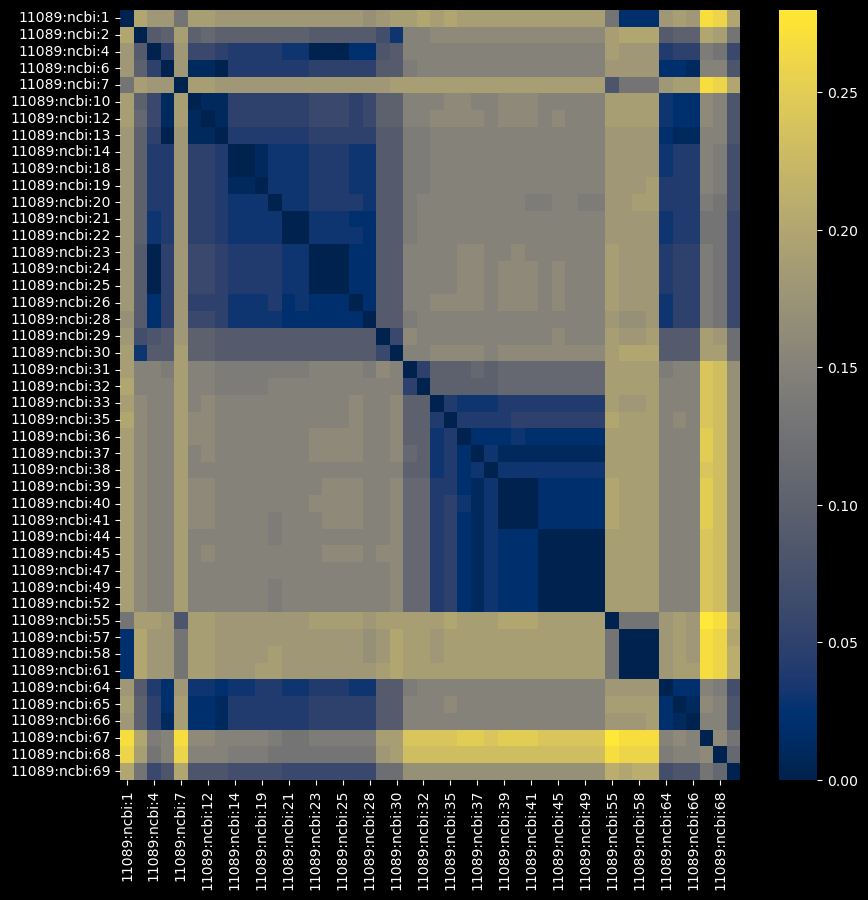

In [ ]:
refseqid2dist_mx_idx = {}
dist_mx_idx2refseqid = {}

for refseqid in selected_refseqs:
    accession = refseq_metadata[refseqid]['refseq_accession']
    idx = distance_accessions[accession]['definition line']
    refseqid2dist_mx_idx[refseqid] = idx
    dist_mx_idx2refseqid[idx] = refseqid

selected_dist_idxs = [refseqid2dist_mx_idx[rsid] for rsid in selected_refseqs]
selected_dist = dist_mx.loc[selected_dist_idxs, selected_dist_idxs]
selected_dist.index=selected_refseqs
selected_dist.columns=selected_refseqs
plt.figure(figsize=(10,10))
sns.heatmap(selected_dist, cmap='cividis');
# ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

## Successive predictions

#### Successive identical predictions (integer)

To evaluate and compare multiple lists of integers based on the criteria you've described, you can use a custom scoring function that takes into account both the number of elements equal to the given value y and the length of sequences of identical elements. Here's a suggested approach using a mathematical function as a metric:

Proposed Scoring Function

Let's define a scoring function S(L, y) for a list L and target value y:
```
S(L, y) = (C / N) * (1 + (M / N) * (1 - F / C))
```
Where:
- N is the total number of elements in the list
- C is the count of elements equal to y
- M is the maximum length of any continuous sequence of y in the list
- F is the number of "fragments" or separate sequences of y in the list

Explanation of the Function Components

1. (C / N): This represents the proportion of elements in the list that are equal to y. It ranges from 0 to 1.

2. (1 + (M / N) * (1 - F / C)): This factor rewards longer sequences and penalizes fragmentation.
   - (M / N) rewards longer continuous sequences of y
   - (1 - F / C) penalizes fragmentation; it's 1 when there's only one sequence (F = 1) and decreases as the number of fragments increases

Properties of the Scoring Function

1. The score will be highest (1.0) when all elements are equal to y (C = N, M = N, F = 1).
2. For the same number of matching elements (C), lists with longer continuous sequences will score higher.
3. For the same number of matching elements (C) and maximum sequence length (M), lists with fewer fragments will score higher.

Example Calculations

Let's say y = 1 and we have the following lists:

1. [1, 1, 1, 1, 1] (N=5, C=5, M=5, F=1)
   S = (5/5) * (1 + (5/5) * (1 - 1/5)) = 1 * (1 + 1 * 0.8) = 1.8

2. [1, 1, 1, 0, 1] (N=5, C=4, M=3, F=2)
   S = (4/5) * (1 + (3/5) * (1 - 2/4)) = 0.8 * (1 + 0.6 * 0.5) = 1.04

3. [1, 0, 1, 0, 1] (N=5, C=3, M=1, F=3)
   S = (3/5) * (1 + (1/5) * (1 - 3/3)) = 0.6 * 1 = 0.6

This scoring function provides a single metric that you can use to evaluate and compare multiple lists based on your specified criteria. The higher the score, the better the list matches your requirements.

[ref](https://www.perplexity.ai/search/successive-integers-scoring-pxKaeZFQQWGuvgiXuXPAGw)

### Successive close probabilities (float)

To evaluate your lists of probabilities based on the criteria you've described, you can use a custom scoring function that takes into account both the individual values and their sequence. Here's a suggested approach:

## Proposed Scoring Function

You can use a combination of techniques to create a scoring function that meets your requirements:

1. Average proximity to 1
2. Longest sequence bonus
3. Weighted scoring

Here's a Python function that implements this approach:

```python
import numpy as np

def score_probability_list(prob_list, sequence_threshold=0.9, sequence_weight=0.3):
    # Convert to numpy array for easier operations
    probs = np.array(prob_list)
    
    # 1. Calculate average proximity to 1
    base_score = np.mean(probs)
    
    # 2. Find the longest sequence of numbers above the threshold
    sequence_length = 0
    max_sequence = 0
    for prob in probs:
        if prob >= sequence_threshold:
            sequence_length += 1
            max_sequence = max(max_sequence, sequence_length)
        else:
            sequence_length = 0
    
    # Normalize the sequence bonus
    sequence_bonus = max_sequence / len(probs)
    
    # 3. Combine the scores with weighting
    final_score = (1 - sequence_weight) * base_score + sequence_weight * sequence_bonus
    
    return final_score
```

## How It Works

1. **Average proximity to 1**: This is simply the mean of all probabilities in the list. It ensures that lists with many elements close to 1 get a good score.

2. **Longest sequence bonus**: This part finds the longest continuous sequence of probabilities above a certain threshold (default 0.9). It's then normalized by dividing by the list length.

3. **Weighted scoring**: The final score is a weighted combination of the average proximity and the sequence bonus. You can adjust the `sequence_weight` to give more or less importance to the sequence aspect.

## Usage and Customization

You can call this function like this:

```python
list1 = [0.9, 0.95, 0.98, 0.99, 0.7, 0.8]
list2 = [0.7, 0.8, 0.9, 0.95, 0.98, 0.99]

score1 = score_probability_list(list1)
score2 = score_probability_list(list2)

print(f"Score for list1: {score1}")
print(f"Score for list2: {score2}")
```

You can customize the function by adjusting:

- `sequence_threshold`: The minimum value to consider as part of a "good" sequence.
- `sequence_weight`: How much importance to give to the sequence bonus vs. the average proximity.

## Advantages

This scoring function:
- Rewards lists with many elements close to 1
- Gives a bonus for longer sequences of high probabilities
- Is flexible and can be easily adjusted to emphasize different aspects

Remember to test this function with various input lists to ensure it behaves as expected for your specific use case.

# End of Section